In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-Constant
Time: Tue Nov 17 02:36:27 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

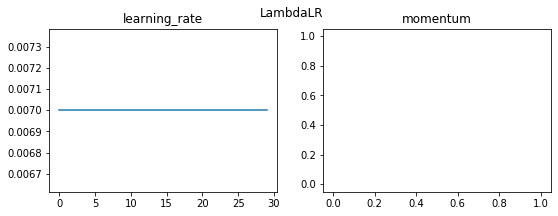

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'lr_lambda': lambda epoch: 1,
}
CFG.scheduler = optim.lr_scheduler.LambdaLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [35]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: AggMo
fold 0


epoch1 save best model... 0.22790434126294556
epoch2 save best model... 0.025394335347556578
epoch3 save best model... 0.022275875898285988
epoch4 save best model... 0.02135313930231781
epoch5 save best model... 0.020870045631920287
epoch6 save best model... 0.020513859170580236
epoch7 save best model... 0.020250829904932096
epoch8 save best model... 0.020071068902527554
epoch9 save best model... 0.01988386596746081
epoch10 save best model... 0.01971350024986783
epoch11 save best model... 0.019528729817352698
epoch12 save best model... 0.019379883617637914
epoch13 save best model... 0.01929240368883675
epoch14 save best model... 0.019147247898313884
epoch15 save best model... 0.018975052261271073
epoch16 save best model... 0.018863975533320313
epoch17 save best model... 0.01882006411264589
epoch18 save best model... 0.018661196697036607
epoch19 save best model... 0.018570921260328933
epoch20 save best model... 0.018514981730109195
epoch21 save best model... 0.018443535597557903
epoch22

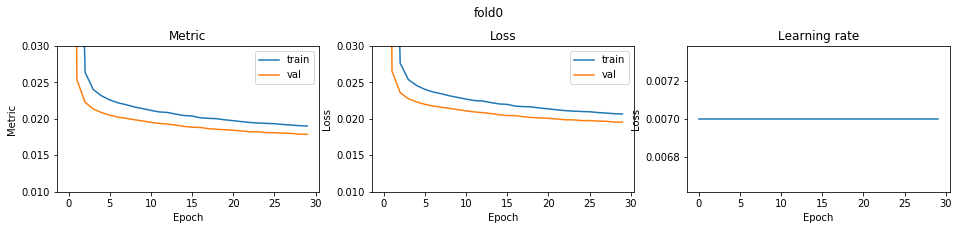

fold 1


epoch1 save best model... 0.24065871487502546
epoch2 save best model... 0.02567844070183522
epoch3 save best model... 0.02225172977090751
epoch4 save best model... 0.021407757820610333
epoch5 save best model... 0.020941034016256913
epoch6 save best model... 0.020625178982060437
epoch7 save best model... 0.02037726629310682
epoch8 save best model... 0.020298349692921863
epoch9 save best model... 0.019966578470510348
epoch10 save best model... 0.01989213692898168
epoch11 save best model... 0.01970889372422215
epoch12 save best model... 0.019607677698002965
epoch13 save best model... 0.01943886480414058
epoch14 save best model... 0.0192838409781035
epoch15 save best model... 0.01917629040214094
epoch16 save best model... 0.01904985375148977
epoch17 save best model... 0.01893009906891444
epoch18 save best model... 0.01887541801190629
epoch19 save best model... 0.018741307907463423
epoch20 save best model... 0.018676988205875236
epoch21 save best model... 0.01857776001501488
epoch22 save be

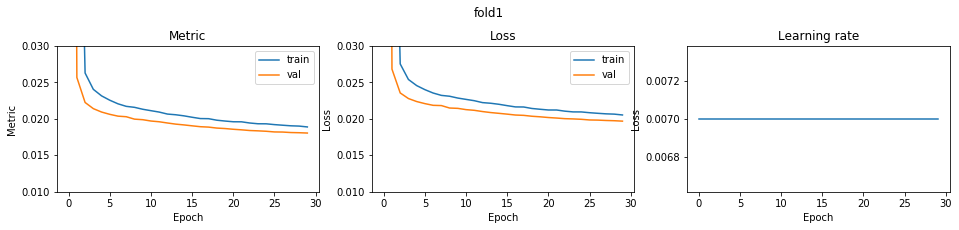

fold 2


epoch1 save best model... 0.24352102595137204
epoch2 save best model... 0.025613978842099778
epoch3 save best model... 0.022293242952035427
epoch4 save best model... 0.02140843861932213
epoch5 save best model... 0.020997881902074945
epoch6 save best model... 0.020747266837970138
epoch7 save best model... 0.020474164489309537
epoch8 save best model... 0.02030688986915558
epoch9 save best model... 0.020138610647530836
epoch10 save best model... 0.020074882260872798
epoch11 save best model... 0.019839939933145447
epoch12 save best model... 0.019694785526589723
epoch13 save best model... 0.019548277383575573
epoch14 save best model... 0.019439878854217333
epoch15 save best model... 0.019287568374646635
epoch16 save best model... 0.019193516154241985
epoch17 save best model... 0.01906327319332104
epoch18 save best model... 0.018969155369739404
epoch19 save best model... 0.01891904892805199
epoch20 save best model... 0.01877515890361182
epoch21 save best model... 0.018683508943106854
epoch22

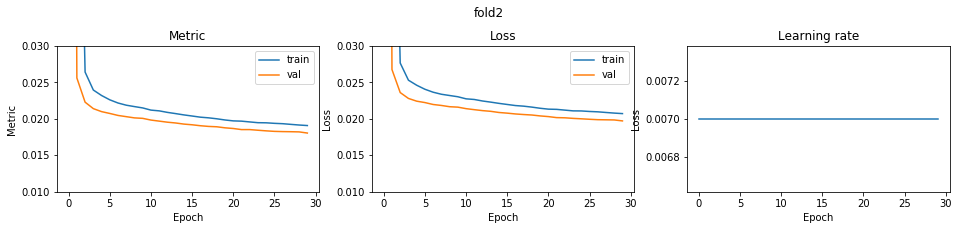

fold 3


epoch1 save best model... 0.2056085157570915
epoch2 save best model... 0.025008508227850418
epoch3 save best model... 0.022261623830316008
epoch4 save best model... 0.021437455903832083
epoch5 save best model... 0.020953491720496115
epoch6 save best model... 0.020719039449913764
epoch7 save best model... 0.020431354736955943
epoch8 save best model... 0.020191794455662403
epoch9 save best model... 0.020073651320010356
epoch10 save best model... 0.019921654908746006
epoch11 save best model... 0.019773417470259656
epoch12 save best model... 0.019656815471080957
epoch13 save best model... 0.019537369888657726
epoch14 save best model... 0.01942187873922407
epoch15 save best model... 0.019240684757658316
epoch16 save best model... 0.019163224028088236
epoch17 save best model... 0.019058570309896404
epoch18 save best model... 0.018938276609130084
epoch19 save best model... 0.018865446457830268
epoch20 save best model... 0.01877138546767702
epoch21 save best model... 0.018696932676237645
epoch

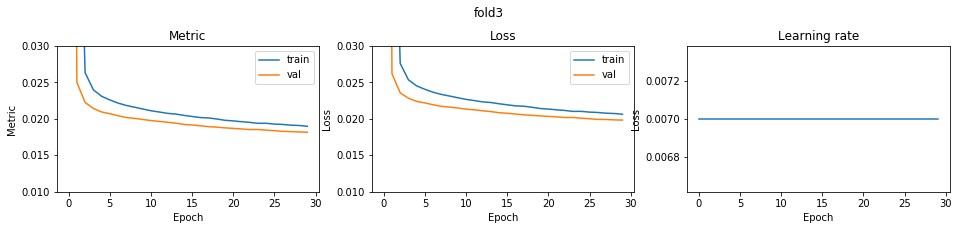

fold 4


epoch1 save best model... 0.21300618601687132
epoch2 save best model... 0.025084986995931095
epoch3 save best model... 0.021993812179545064
epoch4 save best model... 0.021175759320480405
epoch5 save best model... 0.020696337415851602
epoch6 save best model... 0.020406531708013768
epoch7 save best model... 0.02018461539951028
epoch8 save best model... 0.020001280922994254
epoch9 save best model... 0.019762554309057212
epoch10 save best model... 0.019638126042240845
epoch11 save best model... 0.019498192134540283
epoch12 save best model... 0.019343165269202142
epoch13 save best model... 0.01920301485255123
epoch14 save best model... 0.019059221577196295
epoch15 save best model... 0.01891672388737457
epoch16 save best model... 0.018800685460549825
epoch17 save best model... 0.01871983125330647
epoch18 save best model... 0.018618854658852133
epoch19 save best model... 0.018535113203125012
epoch20 save best model... 0.018482368027871995
epoch21 save best model... 0.018366312728621964
epoch2

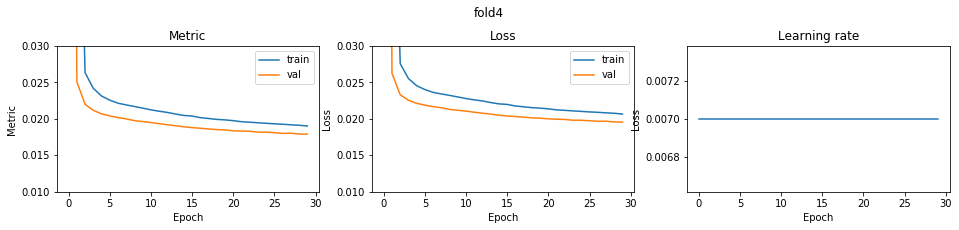

CV score: 0.018017555627680256

optimizer: Apollo
fold 0


epoch1 save best model... 0.7039063529979124
epoch2 save best model... 0.6988165043209571
epoch3 save best model... 0.6872653746387681
epoch4 save best model... 0.6804097403426377
epoch5 save best model... 0.6747696664447393
epoch6 save best model... 0.6670014281207717
epoch7 save best model... 0.6573470971850437
epoch8 save best model... 0.6499544951530144
epoch9 save best model... 0.6386004246177326
epoch10 save best model... 0.6286966831103001
epoch11 save best model... 0.6138810438555846
epoch12 save best model... 0.6019455419042931
epoch13 save best model... 0.5847169605365918
epoch14 save best model... 0.5674561189084498
epoch15 save best model... 0.5490824337429229
epoch16 save best model... 0.5267957703942319
epoch17 save best model... 0.4980392273031769
epoch18 save best model... 0.4703246742283293
epoch19 save best model... 0.4407019183277269
epoch20 save best model... 0.4090625333351535
epoch21 save best model... 0.37471209799781746
epoch22 save best model... 0.3399904490060

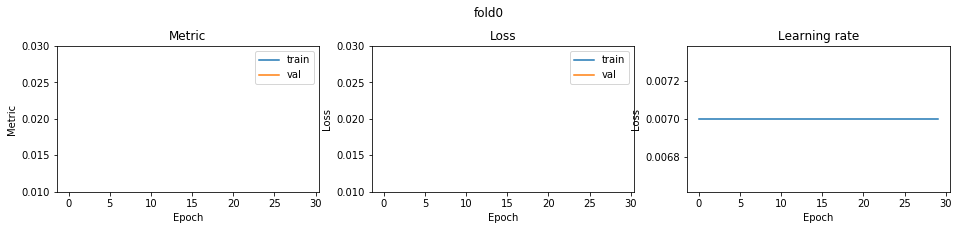

fold 1


epoch1 save best model... 0.7026041042671629
epoch2 save best model... 0.6946050419191424
epoch3 save best model... 0.686188830183698
epoch4 save best model... 0.6781582413786608
epoch5 save best model... 0.6727222166047278
epoch6 save best model... 0.662376865340572
epoch7 save best model... 0.6529996309825787
epoch8 save best model... 0.6434193436174356
epoch9 save best model... 0.6318338150096988
epoch10 save best model... 0.6198212380804704
epoch11 save best model... 0.6089905088109181
epoch12 save best model... 0.594549595725702
epoch13 save best model... 0.5795695394121397
epoch14 save best model... 0.5585868444304771
epoch15 save best model... 0.5385885280746892
epoch16 save best model... 0.513376437047805
epoch17 save best model... 0.4877624242757713
epoch18 save best model... 0.4602319913875761
epoch19 save best model... 0.427934426874581
epoch20 save best model... 0.3958131258784842
epoch21 save best model... 0.3640317589988413
epoch22 save best model... 0.32776418951628394
e

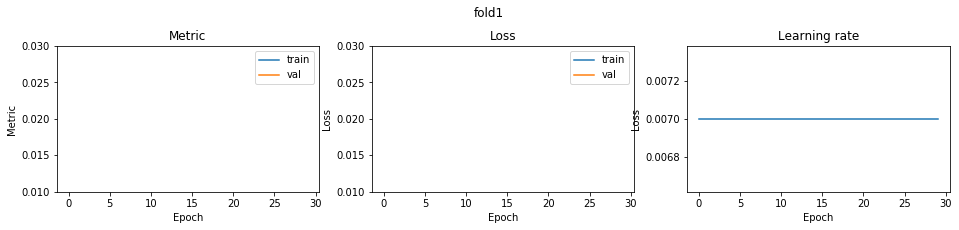

fold 2


epoch1 save best model... 0.7012703710711609
epoch2 save best model... 0.697018890153794
epoch3 save best model... 0.6864827169076977
epoch4 save best model... 0.678129461719333
epoch5 save best model... 0.6718436760005008
epoch6 save best model... 0.6612726343224005
epoch7 save best model... 0.6528794827127706
epoch8 save best model... 0.6439141341047749
epoch9 save best model... 0.6328638084767538
epoch10 save best model... 0.6212931784499232
epoch11 save best model... 0.608962756309783
epoch12 save best model... 0.5932623247916673
epoch13 save best model... 0.5785484017367568
epoch14 save best model... 0.5591107942053603
epoch15 save best model... 0.5343220756764997
epoch16 save best model... 0.5107398914785639
epoch17 save best model... 0.48211624330229247
epoch18 save best model... 0.45179377276578564
epoch19 save best model... 0.4213476231413785
epoch20 save best model... 0.388517817228143
epoch21 save best model... 0.35384151686511733
epoch22 save best model... 0.321676066882465

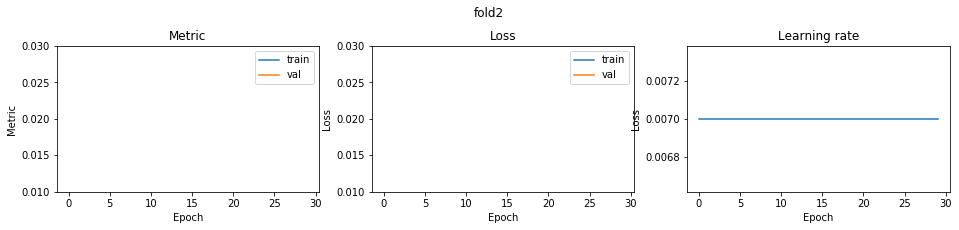

fold 3


epoch1 save best model... 0.6988382389170705
epoch2 save best model... 0.6927108961248724
epoch3 save best model... 0.6856278593284937
epoch4 save best model... 0.678394498124481
epoch5 save best model... 0.6683758202066182
epoch6 save best model... 0.6631659249509929
epoch7 save best model... 0.6531733743422123
epoch8 save best model... 0.6441003663936345
epoch9 save best model... 0.6354900887180841
epoch10 save best model... 0.6252993770775328
epoch11 save best model... 0.6125804651299479
epoch12 save best model... 0.5970665705502712
epoch13 save best model... 0.5818577355567306
epoch14 save best model... 0.5659500761564338
epoch15 save best model... 0.5430975145250898
epoch16 save best model... 0.5199701552238986
epoch17 save best model... 0.49312048800170827
epoch18 save best model... 0.4665988560961156
epoch19 save best model... 0.4352279056313369
epoch20 save best model... 0.4052871164401191
epoch21 save best model... 0.3678155321873945
epoch22 save best model... 0.33662502365123

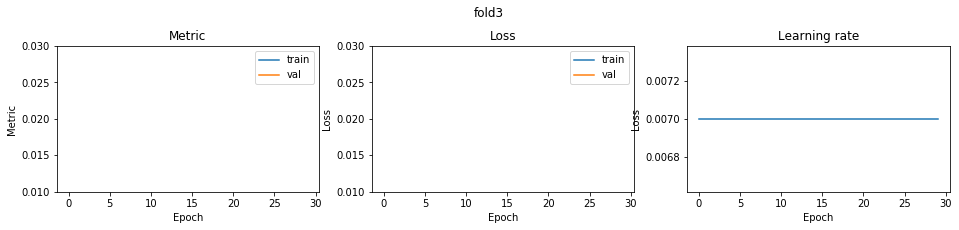

fold 4


epoch1 save best model... 0.7072412000158653
epoch2 save best model... 0.698019442308465
epoch3 save best model... 0.6922336977815302
epoch4 save best model... 0.6825900534834025
epoch5 save best model... 0.6730423382311584
epoch6 save best model... 0.6629217254002164
epoch7 save best model... 0.6572324354447645
epoch8 save best model... 0.6467682073491038
epoch9 save best model... 0.6357196460280712
epoch10 save best model... 0.6235434548458368
epoch11 save best model... 0.6098029549681244
epoch12 save best model... 0.5968124690794456
epoch13 save best model... 0.5799101231309982
epoch14 save best model... 0.5588258829095097
epoch15 save best model... 0.5355050279230626
epoch16 save best model... 0.5104880834630519
epoch17 save best model... 0.4834494821031436
epoch18 save best model... 0.455070735653332
epoch19 save best model... 0.4206197505659829
epoch20 save best model... 0.3881824971467324
epoch21 save best model... 0.3547162643733492
epoch22 save best model... 0.3214155654565077

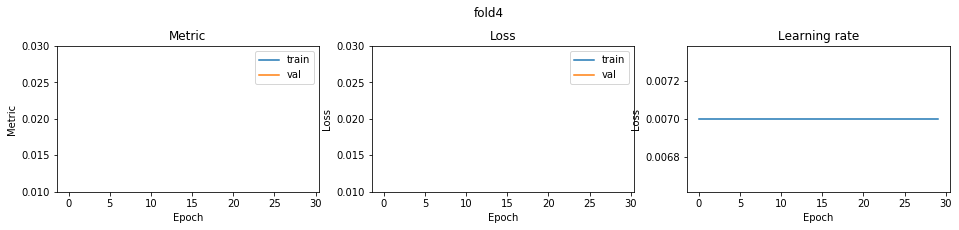

CV score: 0.13689226317013822

optimizer: PID
fold 0


epoch1 save best model... 0.7030631851769797
epoch2 save best model... 0.6924268961767401
epoch3 save best model... 0.6858774902880328
epoch4 save best model... 0.677931257885518
epoch5 save best model... 0.6710178560167891
epoch6 save best model... 0.6636602265688173
epoch7 save best model... 0.653272567523096
epoch8 save best model... 0.642310832926244
epoch9 save best model... 0.6328822085689032
epoch10 save best model... 0.6192764153784662
epoch11 save best model... 0.6096703842995107
epoch12 save best model... 0.5945602275244467
epoch13 save best model... 0.5781267996529512
epoch14 save best model... 0.5579343963864181
epoch15 save best model... 0.5358056241396076
epoch16 save best model... 0.5118250573143057
epoch17 save best model... 0.482780737268626
epoch18 save best model... 0.45531142910683614
epoch19 save best model... 0.4219436163239707
epoch20 save best model... 0.3907477186046592
epoch21 save best model... 0.35660759355864385
epoch22 save best model... 0.3238661724641274

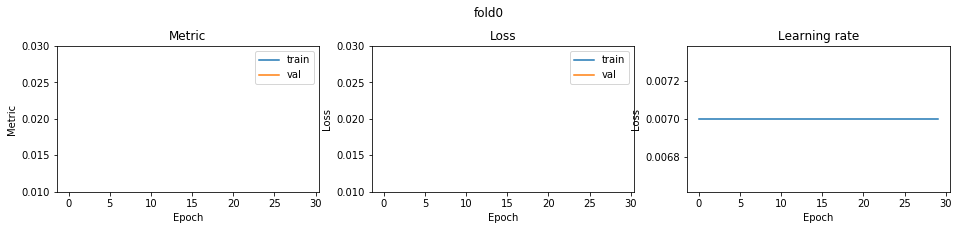

fold 1


epoch1 save best model... 0.703469315974526
epoch2 save best model... 0.6928486288558054
epoch3 save best model... 0.6867881971493102
epoch4 save best model... 0.6797750618985259
epoch5 save best model... 0.671116265981174
epoch6 save best model... 0.6606348228226439
epoch7 save best model... 0.6534786551246938
epoch8 save best model... 0.6446522063615789
epoch9 save best model... 0.6338980622431716
epoch10 save best model... 0.6224479260002461
epoch11 save best model... 0.6096336487133212
epoch12 save best model... 0.5947843506901702
epoch13 save best model... 0.57833263322144
epoch14 save best model... 0.5583932248191807
epoch15 save best model... 0.5394026390727763
epoch16 save best model... 0.514111038695492
epoch17 save best model... 0.48457568064994055
epoch18 save best model... 0.45834217990387216
epoch19 save best model... 0.42381991191724083
epoch20 save best model... 0.3919755511442494
epoch21 save best model... 0.3573826122498507
epoch22 save best model... 0.324297241657789


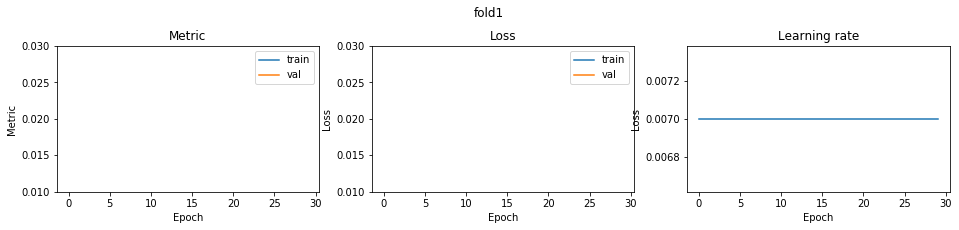

fold 2


epoch1 save best model... 0.7090766421752847
epoch2 save best model... 0.6970108508058767
epoch3 save best model... 0.689379162765576
epoch4 save best model... 0.6822178095721743
epoch5 save best model... 0.673713075894651
epoch6 save best model... 0.6657118293331327
epoch7 save best model... 0.6577765942298897
epoch8 save best model... 0.647943233161669
epoch9 save best model... 0.6371964325555014
epoch10 save best model... 0.6262581510026679
epoch11 save best model... 0.613923372861654
epoch12 save best model... 0.5968843010243807
epoch13 save best model... 0.5815755426000968
epoch14 save best model... 0.5628336278798505
epoch15 save best model... 0.5395251403068948
epoch16 save best model... 0.5177906285551258
epoch17 save best model... 0.49205461777975845
epoch18 save best model... 0.46335217191000194
epoch19 save best model... 0.4298465905346504
epoch20 save best model... 0.39498302317420725
epoch21 save best model... 0.3651750605832637
epoch22 save best model... 0.328262875667599

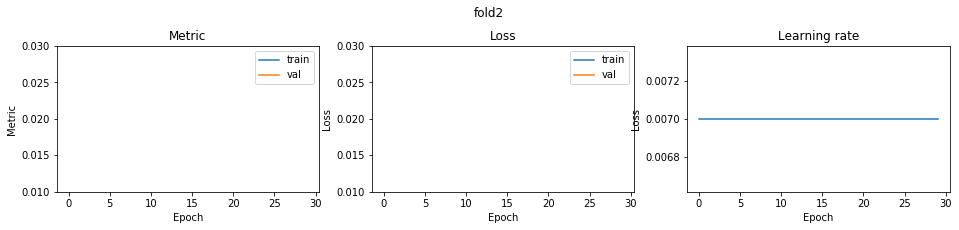

fold 3


epoch1 save best model... 0.6942561561534508
epoch2 save best model... 0.687098095493056
epoch3 save best model... 0.6798224353301497
epoch4 save best model... 0.6741140729202496
epoch5 save best model... 0.6647285706089949
epoch6 save best model... 0.6562728471527882
epoch7 save best model... 0.647925685777208
epoch8 save best model... 0.6403412146014342
epoch9 save best model... 0.6291134843522161
epoch10 save best model... 0.6189917575525532
epoch11 save best model... 0.6051410185448944
epoch12 save best model... 0.5927603700437959
epoch13 save best model... 0.57639491810614
epoch14 save best model... 0.5592335223065422
epoch15 save best model... 0.5371416381388427
epoch16 save best model... 0.5150178014010123
epoch17 save best model... 0.4889424414596688
epoch18 save best model... 0.4609812387708651
epoch19 save best model... 0.4334596993575607
epoch20 save best model... 0.400600792674649
epoch21 save best model... 0.36579259989744983
epoch22 save best model... 0.3317273121895714
e

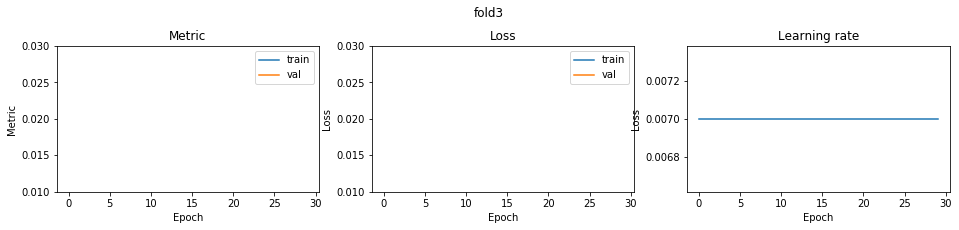

fold 4


epoch1 save best model... 0.7030464104204894
epoch2 save best model... 0.6970071276662562
epoch3 save best model... 0.6888804896545845
epoch4 save best model... 0.6810897828506174
epoch5 save best model... 0.6719839246778119
epoch6 save best model... 0.6634943078210522
epoch7 save best model... 0.6556494610999332
epoch8 save best model... 0.6460245057227672
epoch9 save best model... 0.636762251533517
epoch10 save best model... 0.6261614225176853
epoch11 save best model... 0.6148345704773835
epoch12 save best model... 0.6018168653877015
epoch13 save best model... 0.5852699444071306
epoch14 save best model... 0.5677731131638373
epoch15 save best model... 0.5471344867708471
epoch16 save best model... 0.5249622434852879
epoch17 save best model... 0.5001332210788423
epoch18 save best model... 0.4710064634375257
epoch19 save best model... 0.44116864618516455
epoch20 save best model... 0.40667424621506
epoch21 save best model... 0.37456874740150903
epoch22 save best model... 0.341183087100743

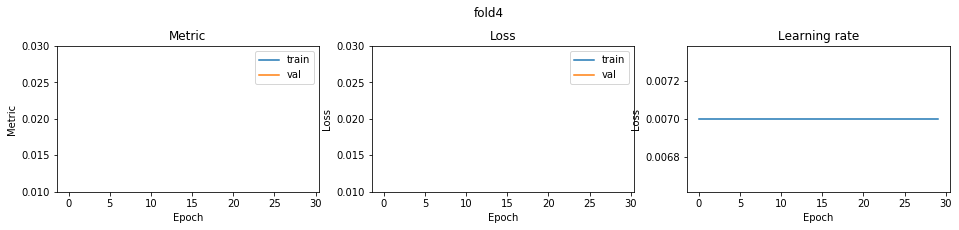

CV score: 0.13608063927965444

optimizer: QHM
fold 0


epoch1 save best model... 0.7100165212887566
epoch2 save best model... 0.7004199772869536
epoch3 save best model... 0.6912441770959824
epoch4 save best model... 0.6855582010230062
epoch5 save best model... 0.6754513721802783
epoch6 save best model... 0.6680574615072281
epoch7 save best model... 0.6599507146109752
epoch8 save best model... 0.6492650299517603
epoch9 save best model... 0.6397040769831195
epoch10 save best model... 0.6286935703086418
epoch11 save best model... 0.6154180937313002
epoch12 save best model... 0.6017923730109439
epoch13 save best model... 0.5874318003382932
epoch14 save best model... 0.565432712184541
epoch15 save best model... 0.5459294053036422
epoch16 save best model... 0.5244863907405619
epoch17 save best model... 0.4995213776215877
epoch18 save best model... 0.46977428144908984
epoch19 save best model... 0.4409070151949255
epoch20 save best model... 0.40691285687318424
epoch21 save best model... 0.3703344198864522
epoch22 save best model... 0.3358560740676

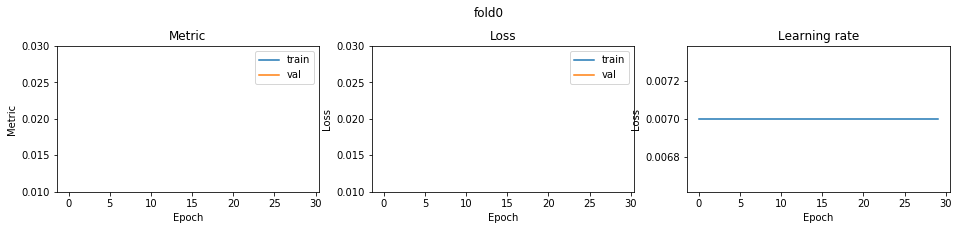

fold 1


epoch1 save best model... 0.7024340213200693
epoch2 save best model... 0.6935882085573974
epoch3 save best model... 0.6859819149069266
epoch4 save best model... 0.6809050346675672
epoch5 save best model... 0.6704908936407767
epoch6 save best model... 0.6616570486732322
epoch7 save best model... 0.654170125512388
epoch8 save best model... 0.643265705522575
epoch9 save best model... 0.6314271595163534
epoch10 save best model... 0.6202716828750624
epoch11 save best model... 0.6083090277760033
epoch12 save best model... 0.5947106750713825
epoch13 save best model... 0.5770686313214566
epoch14 save best model... 0.5572954604636023
epoch15 save best model... 0.5344208156255851
epoch16 save best model... 0.5109022373244876
epoch17 save best model... 0.4833769971090179
epoch18 save best model... 0.4544331672306239
epoch19 save best model... 0.41928444090805395
epoch20 save best model... 0.3904152313460791
epoch21 save best model... 0.35930667832191615
epoch22 save best model... 0.32490629541029

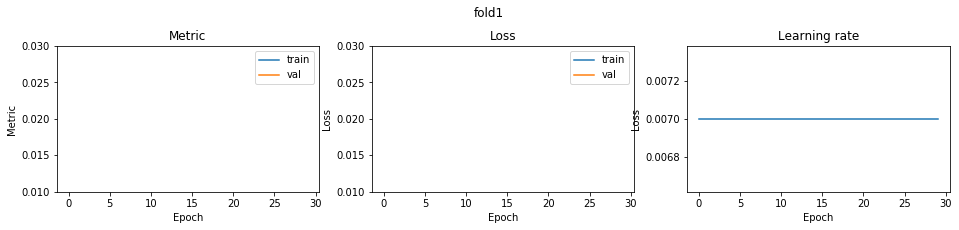

fold 2


epoch1 save best model... 0.7019058965990228
epoch2 save best model... 0.6967187674449175
epoch3 save best model... 0.6902989811276923
epoch4 save best model... 0.6803861698927219
epoch5 save best model... 0.674552109633146
epoch6 save best model... 0.66681844320621
epoch7 save best model... 0.6581040740855111
epoch8 save best model... 0.6492914248229866
epoch9 save best model... 0.6409513646960394
epoch10 save best model... 0.6319583816961809
epoch11 save best model... 0.618612994933677
epoch12 save best model... 0.6066133335392305
epoch13 save best model... 0.5939894168788139
epoch14 save best model... 0.5748815821009688
epoch15 save best model... 0.5575849112657133
epoch16 save best model... 0.5363839591356149
epoch17 save best model... 0.512135576457634
epoch18 save best model... 0.4843021546227157
epoch19 save best model... 0.4560782456892339
epoch20 save best model... 0.4238106097969169
epoch21 save best model... 0.3964129781826234
epoch22 save best model... 0.35692121971574287
e

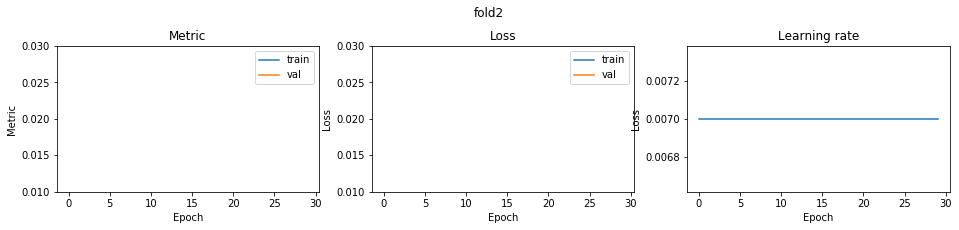

fold 3


epoch1 save best model... 0.7021031109510087
epoch2 save best model... 0.6937654688852523
epoch3 save best model... 0.6868316748147674
epoch4 save best model... 0.6790937538027492
epoch5 save best model... 0.6717787866168793
epoch6 save best model... 0.6624947569907933
epoch7 save best model... 0.6543108528187171
epoch8 save best model... 0.6448995262995396
epoch9 save best model... 0.6359367052623515
epoch10 save best model... 0.625239542269218
epoch11 save best model... 0.6121329197307925
epoch12 save best model... 0.5980196258201687
epoch13 save best model... 0.5820825519485734
epoch14 save best model... 0.5632273932252767
epoch15 save best model... 0.5421529178738865
epoch16 save best model... 0.5209588612673766
epoch17 save best model... 0.4949045591989791
epoch18 save best model... 0.464978147381259
epoch19 save best model... 0.4358356947372063
epoch20 save best model... 0.40506143238658515
epoch21 save best model... 0.3718288525497723
epoch22 save best model... 0.336497877208953

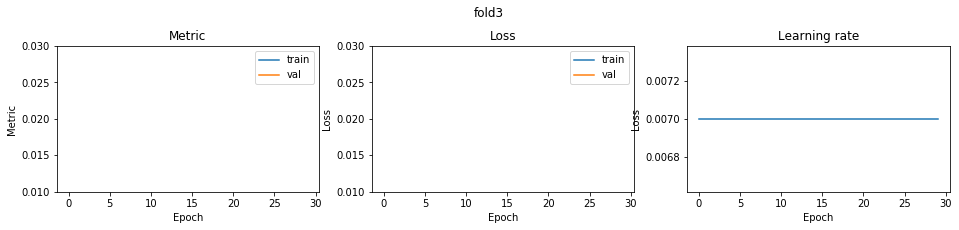

fold 4


epoch1 save best model... 0.7064377536806268
epoch2 save best model... 0.6990525558760606
epoch3 save best model... 0.6902900861173121
epoch4 save best model... 0.6820263131604379
epoch5 save best model... 0.6742003365638316
epoch6 save best model... 0.6641264955926864
epoch7 save best model... 0.6556746284076456
epoch8 save best model... 0.6449438094821226
epoch9 save best model... 0.635470938383854
epoch10 save best model... 0.6236613668178914
epoch11 save best model... 0.6116314464658159
epoch12 save best model... 0.5968252310991831
epoch13 save best model... 0.5789871346977685
epoch14 save best model... 0.5628528994416865
epoch15 save best model... 0.5403142278178135
epoch16 save best model... 0.515011276633973
epoch17 save best model... 0.48649705364655255
epoch18 save best model... 0.4587596542471362
epoch19 save best model... 0.42676170202213976
epoch20 save best model... 0.39313701737442974
epoch21 save best model... 0.3601306559963487
epoch22 save best model... 0.3248267179876

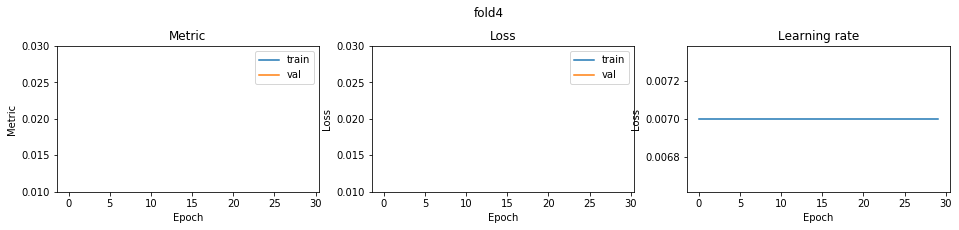

CV score: 0.13933325898791382

optimizer: SGDP
fold 0


epoch1 save best model... 0.7023057885484978
epoch2 save best model... 0.6927497441513392
epoch3 save best model... 0.6883266631454433
epoch4 save best model... 0.679359902444896
epoch5 save best model... 0.6692821983595916
epoch6 save best model... 0.662372236670014
epoch7 save best model... 0.6511834122596949
epoch8 save best model... 0.6393400899098511
epoch9 save best model... 0.6321413941426809
epoch10 save best model... 0.6156464576449644
epoch11 save best model... 0.6006433303100916
epoch12 save best model... 0.5875881428327538
epoch13 save best model... 0.5696938044117904
epoch14 save best model... 0.5497236184487311
epoch15 save best model... 0.5252165403615913
epoch16 save best model... 0.4967398681238735
epoch17 save best model... 0.47002645196023995
epoch18 save best model... 0.4382834318151235
epoch19 save best model... 0.4054421738638693
epoch20 save best model... 0.370743831591617
epoch21 save best model... 0.33692995410302234
epoch22 save best model... 0.302928009459532

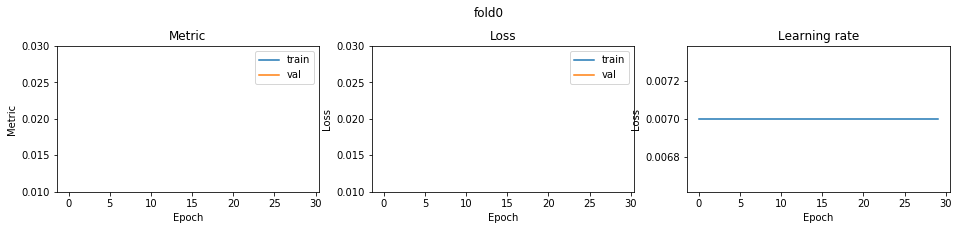

fold 1


epoch1 save best model... 0.7013997035896786
epoch2 save best model... 0.6917171196612717
epoch3 save best model... 0.6870738899118403
epoch4 save best model... 0.6766217512431463
epoch5 save best model... 0.6681880018493259
epoch6 save best model... 0.6609360291165299
epoch7 save best model... 0.6516404324388363
epoch8 save best model... 0.6426424634812442
epoch9 save best model... 0.6335869408273077
epoch10 save best model... 0.6229838413838021
epoch11 save best model... 0.6100573378941224
epoch12 save best model... 0.5966435228129622
epoch13 save best model... 0.5802873052940143
epoch14 save best model... 0.5611420533167634
epoch15 save best model... 0.540250969302494
epoch16 save best model... 0.5175294715713384
epoch17 save best model... 0.49259621844011386
epoch18 save best model... 0.46337818964979705
epoch19 save best model... 0.43349049138327506
epoch20 save best model... 0.4020925682249415
epoch21 save best model... 0.3653856007092416
epoch22 save best model... 0.333091456713

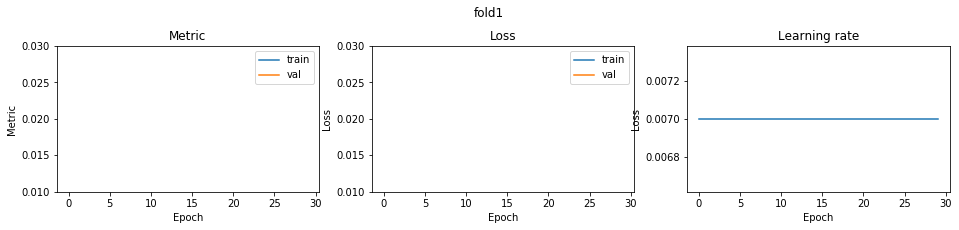

fold 2


epoch1 save best model... 0.7083552843564517
epoch2 save best model... 0.6988507798359589
epoch3 save best model... 0.6900771956395984
epoch4 save best model... 0.6825177776674987
epoch5 save best model... 0.6752224631232372
epoch6 save best model... 0.6674548214783997
epoch7 save best model... 0.6582543261775288
epoch8 save best model... 0.6509045663415557
epoch9 save best model... 0.6385618851732953
epoch10 save best model... 0.6302040571448309
epoch11 save best model... 0.617250939712733
epoch12 save best model... 0.601324783585071
epoch13 save best model... 0.5860322439390805
epoch14 save best model... 0.567253089896311
epoch15 save best model... 0.5474256096192606
epoch16 save best model... 0.5210524842119293
epoch17 save best model... 0.4958807049647201
epoch18 save best model... 0.4672326606983312
epoch19 save best model... 0.43703927713202084
epoch20 save best model... 0.40105275376887656
epoch21 save best model... 0.3687328910890107
epoch22 save best model... 0.333468217524071

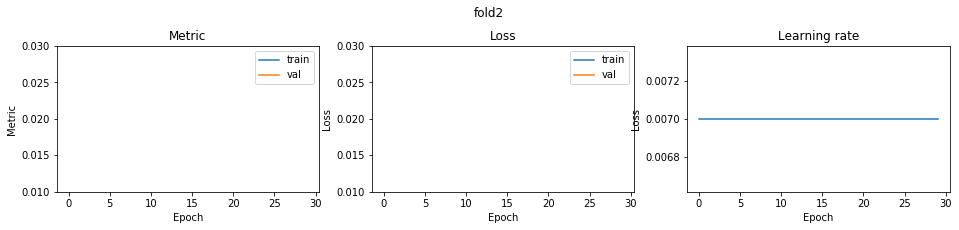

fold 3


epoch1 save best model... 0.7019993710083408
epoch2 save best model... 0.6945912260944045
epoch3 save best model... 0.6888411732360823
epoch4 save best model... 0.6792723746940595
epoch5 save best model... 0.670475835490607
epoch6 save best model... 0.6619951953105883
epoch7 save best model... 0.6546582336849395
epoch8 save best model... 0.6437020777841364
epoch9 save best model... 0.6354266638907865
epoch10 save best model... 0.6222887868218651
epoch11 save best model... 0.6126173924476519
epoch12 save best model... 0.5954660426239761
epoch13 save best model... 0.5796830382325383
epoch14 save best model... 0.5615521756011425
epoch15 save best model... 0.5420378180734118
epoch16 save best model... 0.518138753064401
epoch17 save best model... 0.49073905959759323
epoch18 save best model... 0.46427574852876075
epoch19 save best model... 0.42981031348330556
epoch20 save best model... 0.3987474778382816
epoch21 save best model... 0.3651494030936161
epoch22 save best model... 0.3341968748048

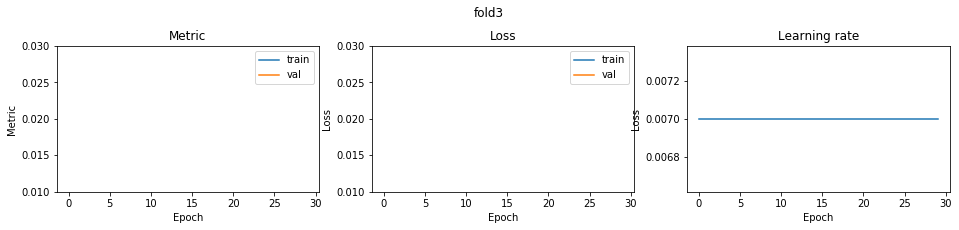

fold 4


epoch1 save best model... 0.705800934207195
epoch2 save best model... 0.6989052660644461
epoch3 save best model... 0.6893541510121426
epoch4 save best model... 0.6837605247193426
epoch5 save best model... 0.676215347260712
epoch6 save best model... 0.6657665846831163
epoch7 save best model... 0.6581608653068542
epoch8 save best model... 0.6493500322035614
epoch9 save best model... 0.640395822258908
epoch10 save best model... 0.6285656451092766
epoch11 save best model... 0.6169266884039094
epoch12 save best model... 0.6029471628486703
epoch13 save best model... 0.5907074328435581
epoch14 save best model... 0.5710212844650946
epoch15 save best model... 0.5524698208296217
epoch16 save best model... 0.5277153563933926
epoch17 save best model... 0.5051228640427079
epoch18 save best model... 0.47809615964770047
epoch19 save best model... 0.4491744578970864
epoch20 save best model... 0.4158274737333111
epoch21 save best model... 0.38252394635204845
epoch22 save best model... 0.348945229172978

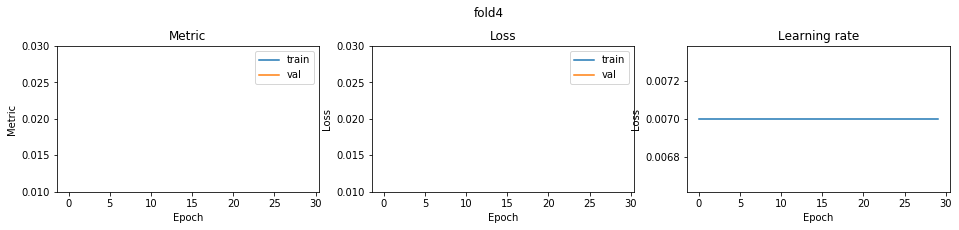

CV score: 0.13655832749619293

optimizer: SGDW
fold 0


epoch1 save best model... 0.7064299943235306
epoch2 save best model... 0.6953980601458452
epoch3 save best model... 0.6894289090312966
epoch4 save best model... 0.6812877237117915
epoch5 save best model... 0.6744885486187859
epoch6 save best model... 0.6668780889760932
epoch7 save best model... 0.6581359588475325
epoch8 save best model... 0.651459918098189
epoch9 save best model... 0.6390282139148147
epoch10 save best model... 0.6274773634919273
epoch11 save best model... 0.6153702111613506
epoch12 save best model... 0.6023505331715039
epoch13 save best model... 0.5871207876194583
epoch14 save best model... 0.5687298293537323
epoch15 save best model... 0.5487893794555055
epoch16 save best model... 0.5259923176233209
epoch17 save best model... 0.5015211611239405
epoch18 save best model... 0.4730892601072924
epoch19 save best model... 0.44181412157002237
epoch20 save best model... 0.41063070700489035
epoch21 save best model... 0.37405029840784354
epoch22 save best model... 0.338141720781

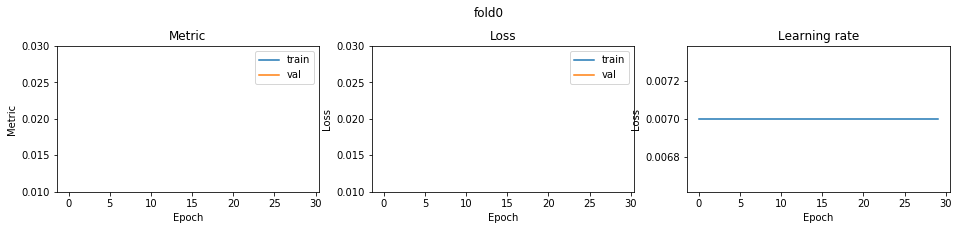

fold 1


epoch1 save best model... 0.7021474371224771
epoch2 save best model... 0.6972645283370063
epoch3 save best model... 0.6869486070597299
epoch4 save best model... 0.6802178978458248
epoch5 save best model... 0.6730569476118716
epoch6 save best model... 0.6642475693935848
epoch7 save best model... 0.656962124639721
epoch8 save best model... 0.6476675898318791
epoch9 save best model... 0.6367450889109153
epoch10 save best model... 0.6266165838531655
epoch11 save best model... 0.6127448904131344
epoch12 save best model... 0.6001489921049639
epoch13 save best model... 0.5856281793261476
epoch14 save best model... 0.5656927385643093
epoch15 save best model... 0.5463628429409365
epoch16 save best model... 0.5208756521829686
epoch17 save best model... 0.49813783122619154
epoch18 save best model... 0.47026517963485476
epoch19 save best model... 0.4397137555032527
epoch20 save best model... 0.40828831204251187
epoch21 save best model... 0.374442522856879
epoch22 save best model... 0.3397313859759

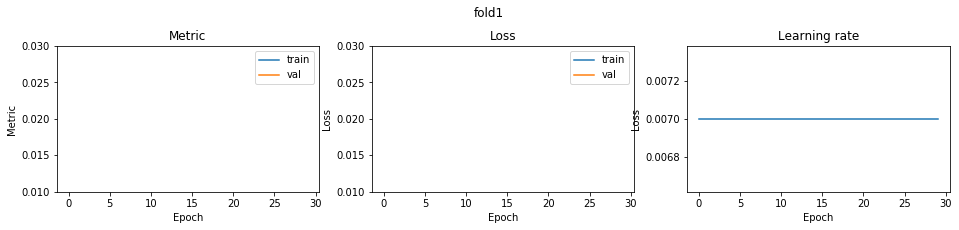

fold 2


epoch1 save best model... 0.7025834206134373
epoch2 save best model... 0.6967423015559934
epoch3 save best model... 0.6872206446140713
epoch4 save best model... 0.682520074082768
epoch5 save best model... 0.6722502048560443
epoch6 save best model... 0.6631044594023108
epoch7 save best model... 0.6551587461311634
epoch8 save best model... 0.648181201711443
epoch9 save best model... 0.63734351453327
epoch10 save best model... 0.6256224549177921
epoch11 save best model... 0.6119321061853777
epoch12 save best model... 0.5977234842022722
epoch13 save best model... 0.5801134212980186
epoch14 save best model... 0.561704684835709
epoch15 save best model... 0.5420184413021641
epoch16 save best model... 0.5188330249896107
epoch17 save best model... 0.48905563539186464
epoch18 save best model... 0.4649168785706444
epoch19 save best model... 0.42923465853238274
epoch20 save best model... 0.3976756058010324
epoch21 save best model... 0.36287500635451514
epoch22 save best model... 0.3295534215977860

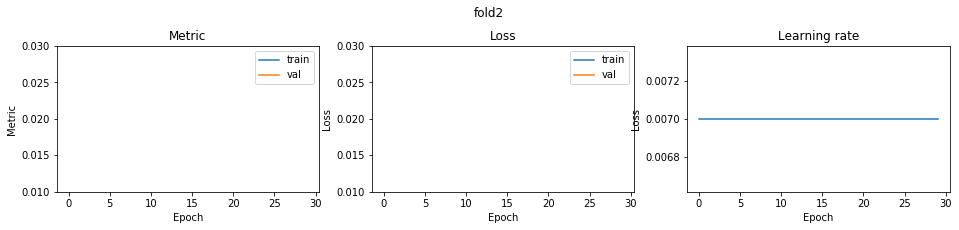

fold 3


epoch1 save best model... 0.7066791858108277
epoch2 save best model... 0.6966558208769709
epoch3 save best model... 0.6906326583957889
epoch4 save best model... 0.6839240454324014
epoch5 save best model... 0.6753818029966333
epoch6 save best model... 0.6674996520229244
epoch7 save best model... 0.6598112592121463
epoch8 save best model... 0.6512199312244841
epoch9 save best model... 0.6424472950857159
epoch10 save best model... 0.6315990891977975
epoch11 save best model... 0.6212721696747191
epoch12 save best model... 0.6088545975489605
epoch13 save best model... 0.5946725237342383
epoch14 save best model... 0.5795983270523488
epoch15 save best model... 0.5592777347238841
epoch16 save best model... 0.5413606944008135
epoch17 save best model... 0.5139866281750534
epoch18 save best model... 0.4876996582488536
epoch19 save best model... 0.46040694116188347
epoch20 save best model... 0.431076141696313
epoch21 save best model... 0.3990367025747929
epoch22 save best model... 0.36226838543366

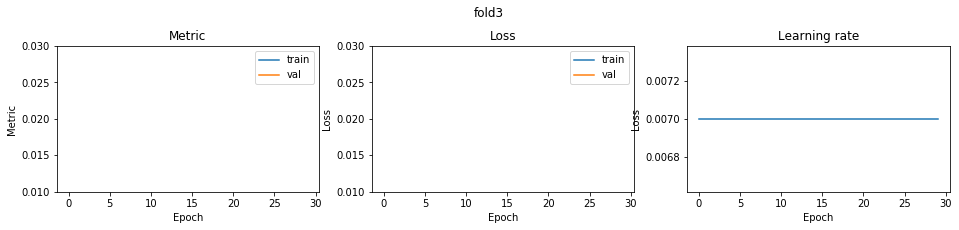

fold 4


epoch1 save best model... 0.704513961280397
epoch2 save best model... 0.695943126347179
epoch3 save best model... 0.68915094729165
epoch4 save best model... 0.6803250457268369
epoch5 save best model... 0.6724899444058707
epoch6 save best model... 0.6632900791450622
epoch7 save best model... 0.6545011836195318
epoch8 save best model... 0.6448414799292701
epoch9 save best model... 0.6347607786400171
epoch10 save best model... 0.623098250239205
epoch11 save best model... 0.6095960259437561
epoch12 save best model... 0.5960698365893614
epoch13 save best model... 0.5795838486632345
epoch14 save best model... 0.5594964375800043
epoch15 save best model... 0.5394425948551412
epoch16 save best model... 0.5150998059600795
epoch17 save best model... 0.49110942424565623
epoch18 save best model... 0.4590960283078474
epoch19 save best model... 0.42694326320107273
epoch20 save best model... 0.3958137876216263
epoch21 save best model... 0.36323470330727126
epoch22 save best model... 0.3273880479683365

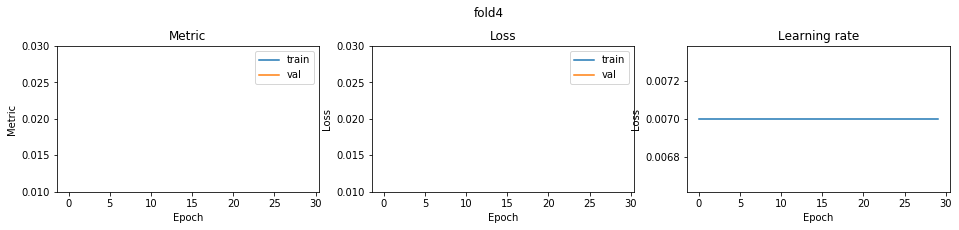

CV score: 0.1417696643464825

optimizer: SGD
fold 0


epoch1 save best model... 0.7047862804832111
epoch2 save best model... 0.6962169581230789
epoch3 save best model... 0.6878680012220674
epoch4 save best model... 0.6783055039636094
epoch5 save best model... 0.6729867468390758
epoch6 save best model... 0.6622348461715941
epoch7 save best model... 0.6526038897879303
epoch8 save best model... 0.6448685202620296
epoch9 save best model... 0.632257588876407
epoch10 save best model... 0.619955779479685
epoch11 save best model... 0.6074437735292526
epoch12 save best model... 0.5933589396281231
epoch13 save best model... 0.577175932240106
epoch14 save best model... 0.5577821502381414
epoch15 save best model... 0.5366736548093566
epoch16 save best model... 0.5112269298633845
epoch17 save best model... 0.4845806869667592
epoch18 save best model... 0.4558276665916747
epoch19 save best model... 0.4232487034960597
epoch20 save best model... 0.3882134419231589
epoch21 save best model... 0.35640320513134394
epoch22 save best model... 0.3227552615428568

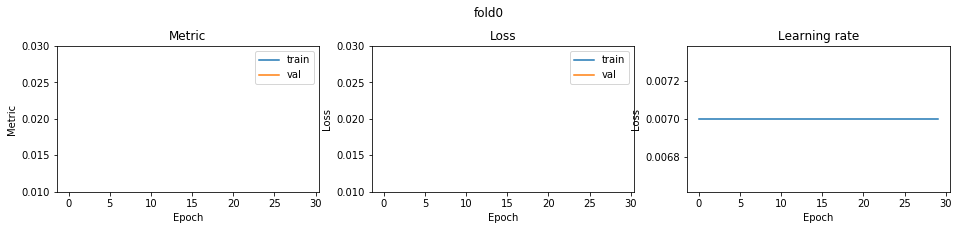

fold 1


epoch1 save best model... 0.7042755928797884
epoch2 save best model... 0.6970991577964134
epoch3 save best model... 0.6908792430867255
epoch4 save best model... 0.6826594877715642
epoch5 save best model... 0.6732109352678067
epoch6 save best model... 0.6656842137366282
epoch7 save best model... 0.6559764358660006
epoch8 save best model... 0.646937159205602
epoch9 save best model... 0.6374659868274253
epoch10 save best model... 0.6249388576395882
epoch11 save best model... 0.6123496931081047
epoch12 save best model... 0.597267582017812
epoch13 save best model... 0.5812603864155915
epoch14 save best model... 0.561668762003107
epoch15 save best model... 0.5411773667462624
epoch16 save best model... 0.5155012525005258
epoch17 save best model... 0.48686513855398095
epoch18 save best model... 0.4572071319263056
epoch19 save best model... 0.4289149830555367
epoch20 save best model... 0.3937174928883644
epoch21 save best model... 0.3601492023815677
epoch22 save best model... 0.3278036898905553

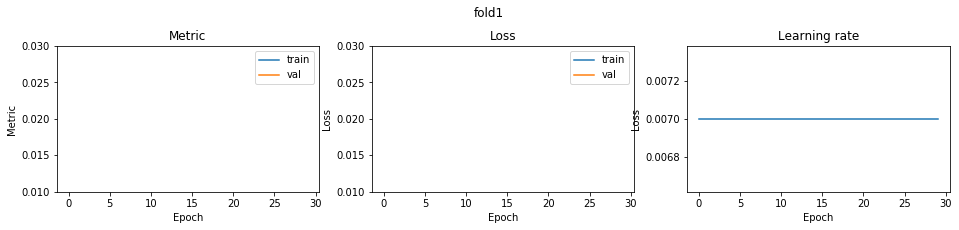

fold 2


epoch1 save best model... 0.7010165892964101
epoch2 save best model... 0.6932666854316266
epoch3 save best model... 0.6838297184058489
epoch4 save best model... 0.6778993201190612
epoch5 save best model... 0.6674222025683323
epoch6 save best model... 0.6575188766065777
epoch7 save best model... 0.6506865316003351
epoch8 save best model... 0.6413574108476654
epoch9 save best model... 0.6291563342904469
epoch10 save best model... 0.6173120043385841
epoch11 save best model... 0.6034210392325526
epoch12 save best model... 0.5899698238460804
epoch13 save best model... 0.5711055114698942
epoch14 save best model... 0.550712633619115
epoch15 save best model... 0.5287736601182013
epoch16 save best model... 0.5050890670873277
epoch17 save best model... 0.47532203111786536
epoch18 save best model... 0.44470158577182617
epoch19 save best model... 0.4121877984295513
epoch20 save best model... 0.3807423696699379
epoch21 save best model... 0.34392496191116256
epoch22 save best model... 0.313101555348

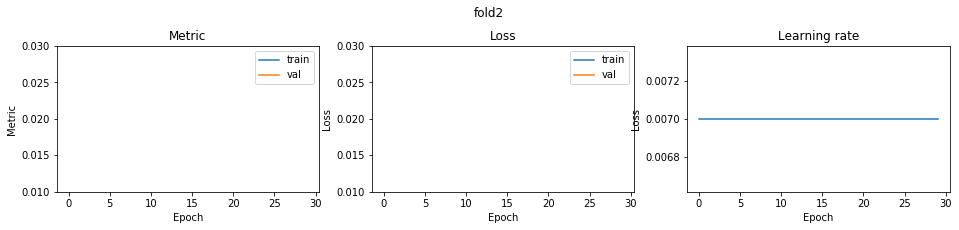

fold 3


epoch1 save best model... 0.7070768105141937
epoch2 save best model... 0.6977918754134471
epoch3 save best model... 0.6891415992467441
epoch4 save best model... 0.6812787863822625
epoch5 save best model... 0.6756271260202882
epoch6 save best model... 0.6661410038454929
epoch7 save best model... 0.6587888659268686
epoch8 save best model... 0.6493403906159629
epoch9 save best model... 0.6385939555179013
epoch10 save best model... 0.6287555735312181
epoch11 save best model... 0.6162223762423139
epoch12 save best model... 0.6047998390328096
epoch13 save best model... 0.5890675980572276
epoch14 save best model... 0.5705469540420045
epoch15 save best model... 0.5527401606694441
epoch16 save best model... 0.5299703679215121
epoch17 save best model... 0.5045737427025015
epoch18 save best model... 0.47537628883381366
epoch19 save best model... 0.4469518181810618
epoch20 save best model... 0.4159356421924669
epoch21 save best model... 0.3832075616493312
epoch22 save best model... 0.3488678663901

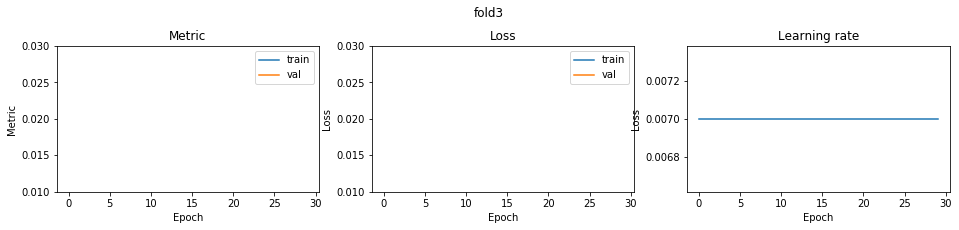

fold 4


epoch1 save best model... 0.7063460730474468
epoch2 save best model... 0.6996765344180931
epoch3 save best model... 0.6928050638874462
epoch4 save best model... 0.6840275758219743
epoch5 save best model... 0.6753730487986415
epoch6 save best model... 0.6671654461185047
epoch7 save best model... 0.6586695202119258
epoch8 save best model... 0.6502054261998327
epoch9 save best model... 0.6394656159340113
epoch10 save best model... 0.6283608164222474
epoch11 save best model... 0.614874500973078
epoch12 save best model... 0.6011642737649296
epoch13 save best model... 0.5840981529350976
epoch14 save best model... 0.5643057290948333
epoch15 save best model... 0.542456313553595
epoch16 save best model... 0.5199017532865658
epoch17 save best model... 0.49529459385502583
epoch18 save best model... 0.4650732705153202
epoch19 save best model... 0.43160812648390856
epoch20 save best model... 0.3988151615464334
epoch21 save best model... 0.3645257412844204
epoch22 save best model... 0.33109440307953

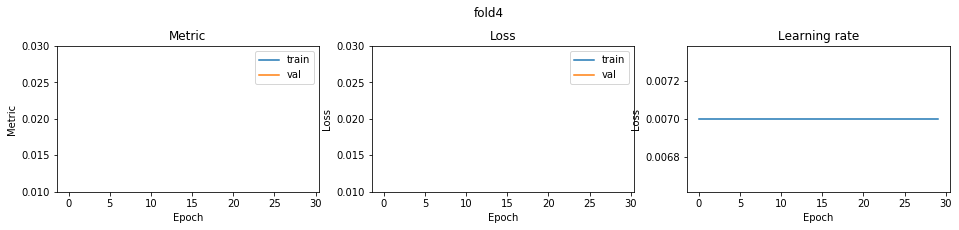

CV score: 0.13611751974435948

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019207456188620086
epoch2 save best model... 0.01825399353404387
epoch3 save best model... 0.017971758917822652
epoch4 save best model... 0.017422622682395177
epoch5 save best model... 0.017228647256121547
epoch7 save best model... 0.016906998458409636
epoch8 save best model... 0.016837542646634552
epoch9 save best model... 0.016755978271772488
epoch10 save best model... 0.016723993376898737
epoch11 save best model... 0.01657234111329825
epoch14 save best model... 0.016539575400972284
epoch15 save best model... 0.016476956491437073
epoch18 save best model... 0.016446070925911764
epoch19 save best model... 0.01641430546378967
epoch20 save best model... 0.016409097283077267
epoch22 save best model... 0.016328359031646696
epoch23 save best model... 0.016265200305484014
fold0 score: 0.016265200330492932


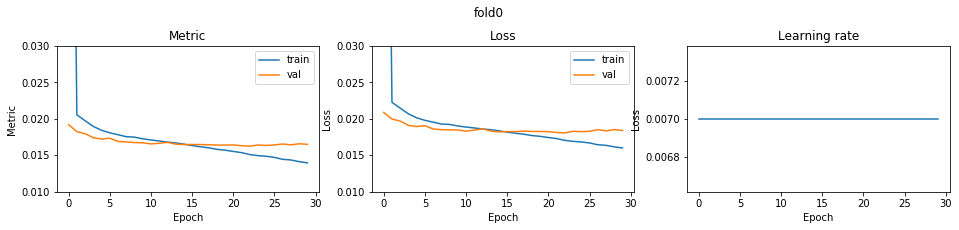

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01961196964366014
epoch2 save best model... 0.018505186145952472
epoch3 save best model... 0.018088732466464925
epoch4 save best model... 0.017551326298376208
epoch6 save best model... 0.017339689122998013
epoch7 save best model... 0.0172247381400895
epoch8 save best model... 0.01707478939016823
epoch9 save best model... 0.016997500051362118
epoch10 save best model... 0.01697555363244458
epoch12 save best model... 0.016862020540306007
epoch13 save best model... 0.01683942281816551
epoch16 save best model... 0.016801630987092517
epoch17 save best model... 0.016798777521245638
epoch18 save best model... 0.01673059019975841
epoch19 save best model... 0.016683493916978254
epoch22 save best model... 0.01666462268446071
epoch23 save best model... 0.016642503918030384
fold1 score: 0.016642503841621917


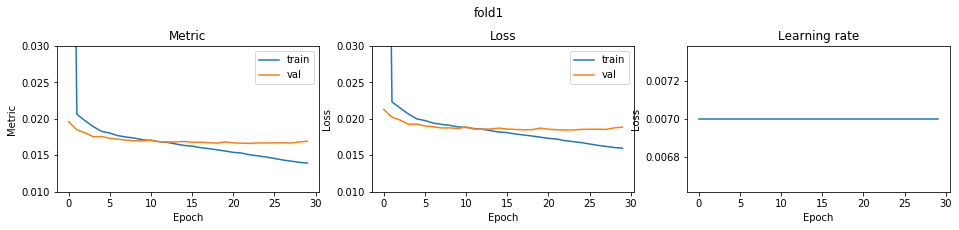

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01931642720572978
epoch2 save best model... 0.01843772965041366
epoch3 save best model... 0.017811845216707436
epoch4 save best model... 0.01754266510983451
epoch5 save best model... 0.017419450771420902
epoch6 save best model... 0.01713824398454052
epoch7 save best model... 0.01706909208320205
epoch8 save best model... 0.017025205766746942
epoch9 save best model... 0.016892302729992342
epoch10 save best model... 0.01685520926968713
epoch11 save best model... 0.01675008404125729
epoch12 save best model... 0.016732436917360646
epoch14 save best model... 0.01655708062408399
epoch17 save best model... 0.016537102198410304
epoch18 save best model... 0.016524922417586692
epoch19 save best model... 0.016470708993791272
fold2 score: 0.016470708941669146


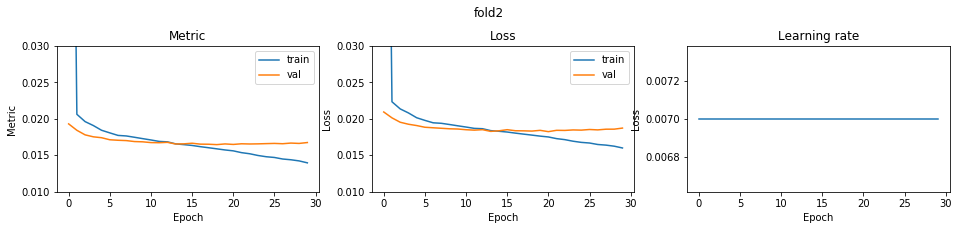

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019342106799669308
epoch2 save best model... 0.01857741132404036
epoch3 save best model... 0.01817074916739195
epoch4 save best model... 0.01770236577397395
epoch5 save best model... 0.017532012728732376
epoch6 save best model... 0.017319976954226612
epoch8 save best model... 0.017149245954099578
epoch10 save best model... 0.017041495951966027
epoch12 save best model... 0.016924611778170347
epoch13 save best model... 0.01692186536432874
epoch14 save best model... 0.01680804509160391
epoch16 save best model... 0.01671847097473834
epoch17 save best model... 0.01668834551184487
epoch18 save best model... 0.016642968797449507
epoch19 save best model... 0.016616980629657014
epoch21 save best model... 0.016564415093163424
fold3 score: 0.016564414969550637


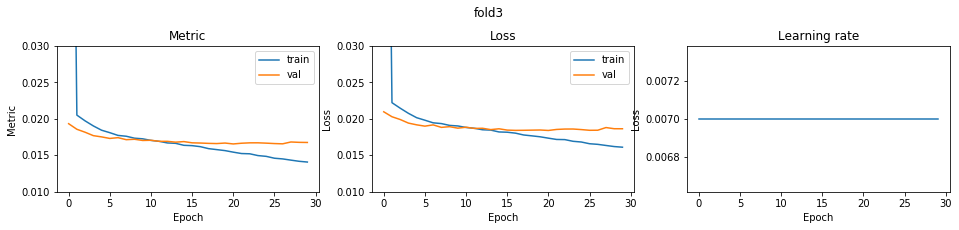

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019347576043464598
epoch2 save best model... 0.01827010081737283
epoch3 save best model... 0.017951707107466824
epoch4 save best model... 0.01763713894271905
epoch5 save best model... 0.017363224206980242
epoch6 save best model... 0.017175042422611378
epoch8 save best model... 0.017059565089846664
epoch9 save best model... 0.016958599812977
epoch10 save best model... 0.016949750979882845
epoch11 save best model... 0.0168536108890909
epoch12 save best model... 0.016806828163156883
epoch13 save best model... 0.016692696654307816
epoch17 save best model... 0.0166223927852878
epoch19 save best model... 0.016560032263245424
epoch20 save best model... 0.016528769742044067
fold4 score: 0.016528769568816545


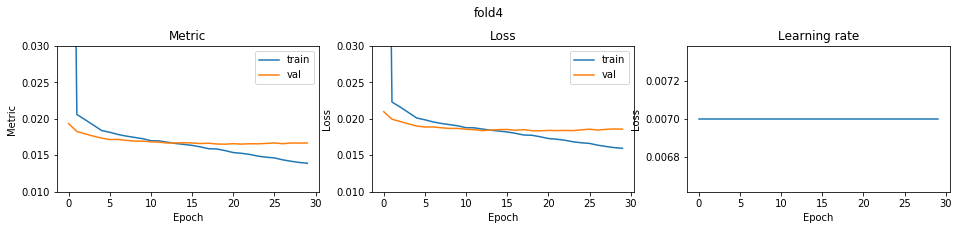

CV score: 0.01649431385457264

optimizer: AdaBound
fold 0


epoch1 save best model... 0.022285758261834026
epoch2 save best model... 0.02161738666915812
epoch3 save best model... 0.02127144378705421
epoch4 save best model... 0.021112452087614152
epoch5 save best model... 0.02096669846352249
epoch6 save best model... 0.02087132722597595
epoch7 save best model... 0.020830962971565663
epoch8 save best model... 0.02073989716487892
epoch9 save best model... 0.02067981278163154
epoch10 save best model... 0.02060720497288302
epoch11 save best model... 0.020596604541385365
epoch12 save best model... 0.020536315576056684
epoch13 save best model... 0.020498290994885572
epoch14 save best model... 0.02044924726383018
epoch15 save best model... 0.020427336918873232
epoch17 save best model... 0.02039827742361398
epoch18 save best model... 0.020383948918457455
epoch19 save best model... 0.0203714843253883
epoch20 save best model... 0.020321859276783493
epoch21 save best model... 0.02028818659331641
epoch23 save best model... 0.020284064238835848
epoch24 save 

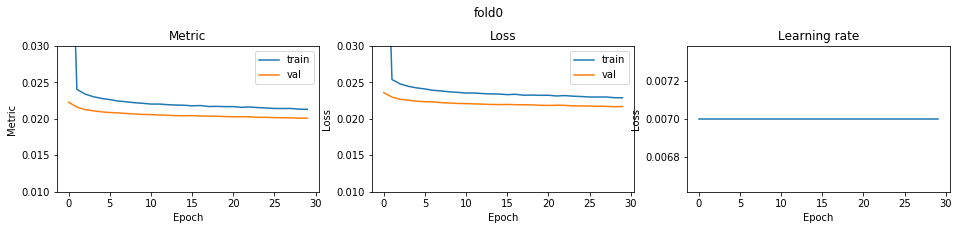

fold 1


epoch1 save best model... 0.02242248769069511
epoch2 save best model... 0.02162146424133255
epoch3 save best model... 0.02132112617265135
epoch4 save best model... 0.02111862670255905
epoch5 save best model... 0.0210321259536961
epoch6 save best model... 0.020881450088475282
epoch7 save best model... 0.020797980720112363
epoch8 save best model... 0.020723482085475482
epoch9 save best model... 0.02067780570698086
epoch10 save best model... 0.020639478536456396
epoch11 save best model... 0.02061018808414885
epoch12 save best model... 0.020569607362110404
epoch13 save best model... 0.020493652131752207
epoch15 save best model... 0.020459488955173386
epoch16 save best model... 0.020411763028308536
epoch17 save best model... 0.020361000448329544
epoch20 save best model... 0.02030602075188408
epoch22 save best model... 0.020228634677754362
epoch23 save best model... 0.020207074517288683
epoch24 save best model... 0.020180929508200267
epoch25 save best model... 0.02016287683162352
epoch27 sav

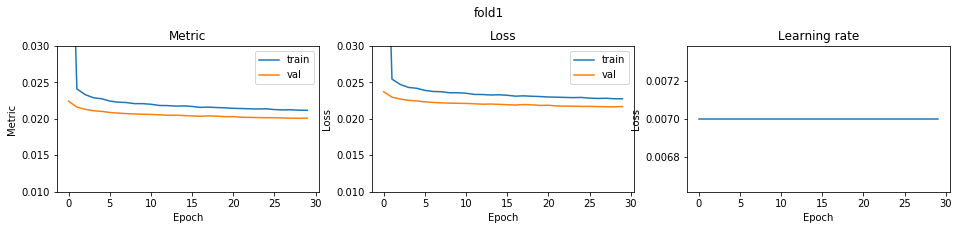

fold 2


epoch1 save best model... 0.022582083008971212
epoch2 save best model... 0.02167687552780979
epoch3 save best model... 0.021360005836659694
epoch4 save best model... 0.02113372290718729
epoch5 save best model... 0.020991500243833162
epoch6 save best model... 0.02086534155636693
epoch7 save best model... 0.020766395043372077
epoch8 save best model... 0.020666821537453212
epoch9 save best model... 0.020632510926717914
epoch11 save best model... 0.02054499693454249
epoch13 save best model... 0.020453841885304393
epoch15 save best model... 0.020415352992280575
epoch16 save best model... 0.020380677942650877
epoch17 save best model... 0.02033017803637931
epoch18 save best model... 0.020287112717589505
epoch20 save best model... 0.02023880621496869
epoch22 save best model... 0.020238614816614993
epoch23 save best model... 0.020158918293082216
epoch24 save best model... 0.020154924969462387
epoch25 save best model... 0.02013443665709249
epoch26 save best model... 0.02011797109847529
epoch27 s

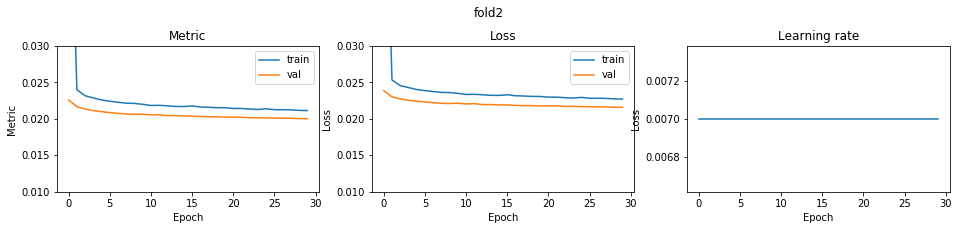

fold 3


epoch1 save best model... 0.022498222231729155
epoch2 save best model... 0.021698706358637247
epoch3 save best model... 0.021441439540042694
epoch4 save best model... 0.021232739056976074
epoch5 save best model... 0.021105374248193445
epoch6 save best model... 0.020960941124104966
epoch7 save best model... 0.020898586543009603
epoch8 save best model... 0.020844335122148512
epoch9 save best model... 0.02081861758354313
epoch10 save best model... 0.02072853794435977
epoch11 save best model... 0.020667396394582573
epoch12 save best model... 0.020643874981222093
epoch13 save best model... 0.020620855169290155
epoch14 save best model... 0.02056734391566629
epoch15 save best model... 0.020546328447810066
epoch16 save best model... 0.02053602342546869
epoch17 save best model... 0.020476599842530585
epoch18 save best model... 0.020458606166811766
epoch19 save best model... 0.0204573046780936
epoch20 save best model... 0.02039377088266041
epoch21 save best model... 0.020382976851050567
epoch22 

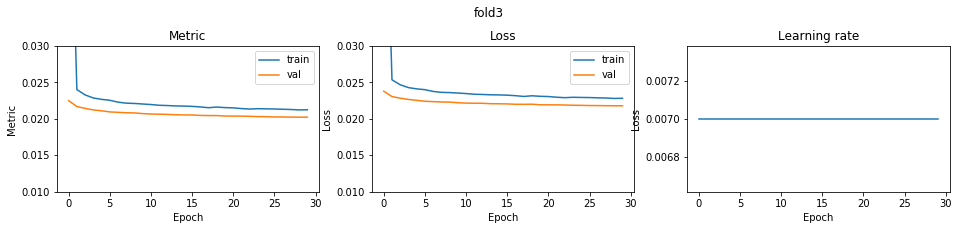

fold 4


epoch1 save best model... 0.02235848114216925
epoch2 save best model... 0.02156207610965454
epoch3 save best model... 0.02120350830019335
epoch4 save best model... 0.021046599712655593
epoch5 save best model... 0.0208855485055672
epoch6 save best model... 0.020825308333055577
epoch7 save best model... 0.020729622050508822
epoch8 save best model... 0.020671658155111627
epoch9 save best model... 0.020644769055560945
epoch10 save best model... 0.020558123900671754
epoch11 save best model... 0.020530245240972904
epoch12 save best model... 0.020508395260144745
epoch13 save best model... 0.02045343857267044
epoch14 save best model... 0.02041876220434972
epoch15 save best model... 0.020408930947711363
epoch16 save best model... 0.02036185339517501
epoch17 save best model... 0.020343813131264238
epoch18 save best model... 0.020315122909012308
epoch19 save best model... 0.02028093753819585
epoch20 save best model... 0.02025781117617269
epoch22 save best model... 0.02024151873361141
epoch23 save

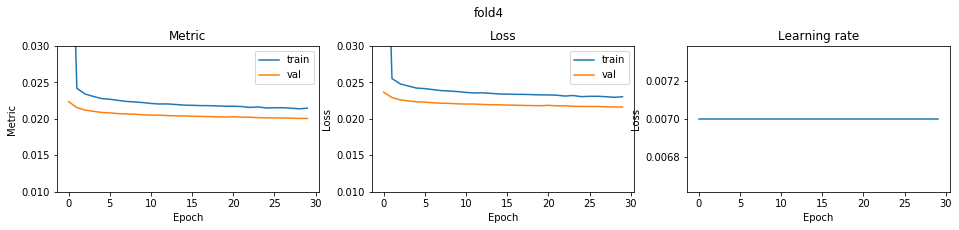

CV score: 0.020099573496562047

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019727686352196207
epoch2 save best model... 0.01858988045067749
epoch3 save best model... 0.018089978758389965
epoch4 save best model... 0.017641699836846093
epoch5 save best model... 0.017398324125109065
epoch6 save best model... 0.017191872104221705
epoch7 save best model... 0.017078503371473056
epoch8 save best model... 0.016944861188870355
epoch9 save best model... 0.016808928417758953
epoch11 save best model... 0.01671288290521414
epoch13 save best model... 0.016649639917058118
epoch14 save best model... 0.016625351385809565
epoch15 save best model... 0.01649338538484788
epoch17 save best model... 0.01647379201389255
epoch18 save best model... 0.016453208510418146
epoch20 save best model... 0.01640944295225491
epoch21 save best model... 0.016399059985639158
epoch23 save best model... 0.01629607518562084
fold0 score: 0.016296075121046607


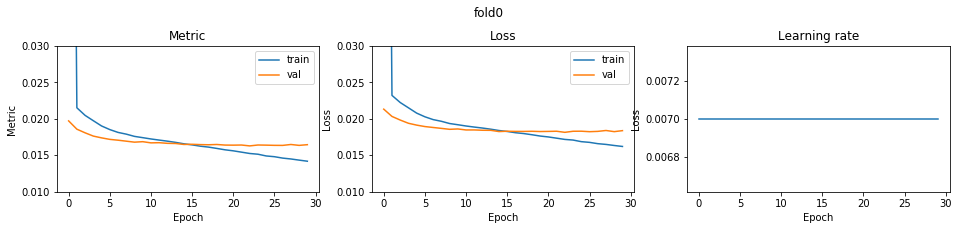

fold 1


epoch1 save best model... 0.020107851819724937
epoch2 save best model... 0.018892066226030815
epoch3 save best model... 0.018146036912963612
epoch4 save best model... 0.017935730113316218
epoch5 save best model... 0.01759616471869469
epoch6 save best model... 0.01746934302079906
epoch7 save best model... 0.017330806569965915
epoch9 save best model... 0.017160387435793456
epoch10 save best model... 0.017087184880281072
epoch11 save best model... 0.017010991879174216
epoch12 save best model... 0.016852974823760292
epoch13 save best model... 0.016797657955016056
epoch15 save best model... 0.01678108343908444
epoch16 save best model... 0.016688449057037643
epoch20 save best model... 0.016654217236956054
fold1 score: 0.016654217249202005


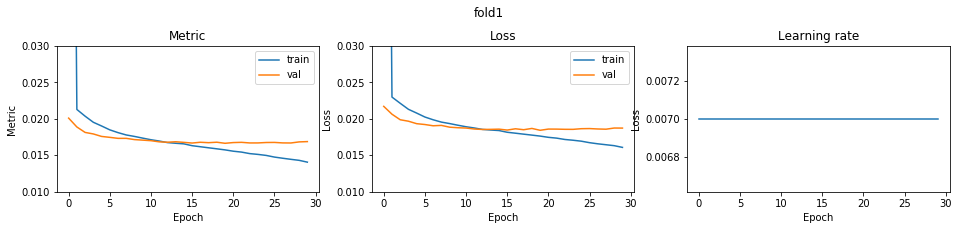

fold 2


epoch1 save best model... 0.019880531933332637
epoch2 save best model... 0.018589188187752546
epoch3 save best model... 0.017911190909750914
epoch4 save best model... 0.01767275070843297
epoch5 save best model... 0.017480433890101617
epoch6 save best model... 0.0172450129754585
epoch8 save best model... 0.016963969347423453
epoch9 save best model... 0.016876225959612315
epoch10 save best model... 0.01679032211000765
epoch11 save best model... 0.01673693645925457
epoch13 save best model... 0.01670323145879472
epoch14 save best model... 0.01661142867332671
epoch16 save best model... 0.016531974603679802
epoch19 save best model... 0.016469632331209755
epoch21 save best model... 0.016468007127907382
fold2 score: 0.01646800707299033


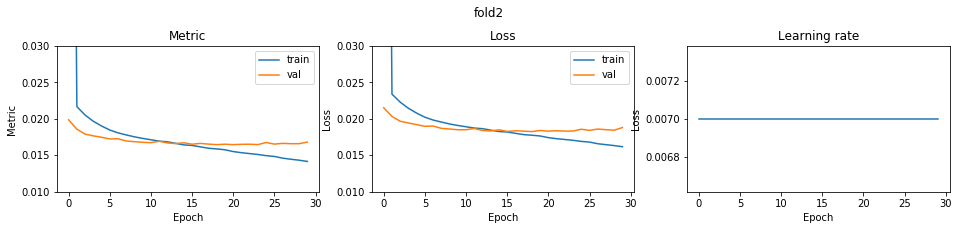

fold 3


epoch1 save best model... 0.020100376917927574
epoch2 save best model... 0.018684304679970943
epoch3 save best model... 0.018273472290800074
epoch4 save best model... 0.01788000681337843
epoch5 save best model... 0.017601280678530354
epoch6 save best model... 0.017394187615373955
epoch7 save best model... 0.017182905197669678
epoch11 save best model... 0.016926826619392512
epoch13 save best model... 0.01685219916784478
epoch14 save best model... 0.016841747752201992
epoch15 save best model... 0.016763734306232125
epoch18 save best model... 0.01675459112386497
epoch19 save best model... 0.0167077249556712
epoch20 save best model... 0.01666627669694212
epoch22 save best model... 0.01657514751237522
fold3 score: 0.016575147565258443


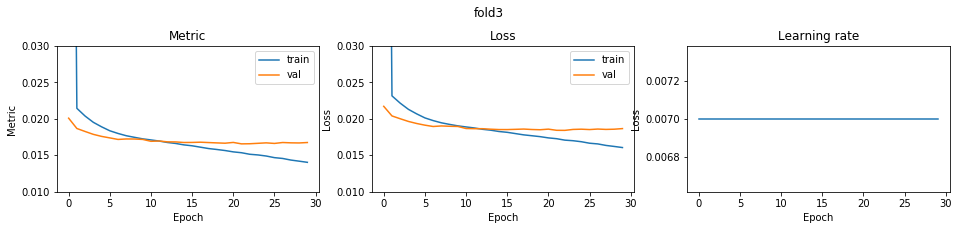

fold 4


epoch1 save best model... 0.019733937380831172
epoch2 save best model... 0.018391288491072036
epoch3 save best model... 0.017859523689505857
epoch4 save best model... 0.017664163444691884
epoch5 save best model... 0.017494691365264815
epoch6 save best model... 0.017112475559369986
epoch7 save best model... 0.017095286183161047
epoch8 save best model... 0.017058758430420536
epoch9 save best model... 0.0169154835313321
epoch11 save best model... 0.01691224659349693
epoch13 save best model... 0.016748053039124994
epoch16 save best model... 0.016695532530274643
epoch17 save best model... 0.01662447851677351
epoch18 save best model... 0.016621126743258403
epoch21 save best model... 0.016601017552400368
epoch22 save best model... 0.01659612382098116
epoch23 save best model... 0.01656450719354093
epoch24 save best model... 0.016545738496208787
fold4 score: 0.016545738347457664


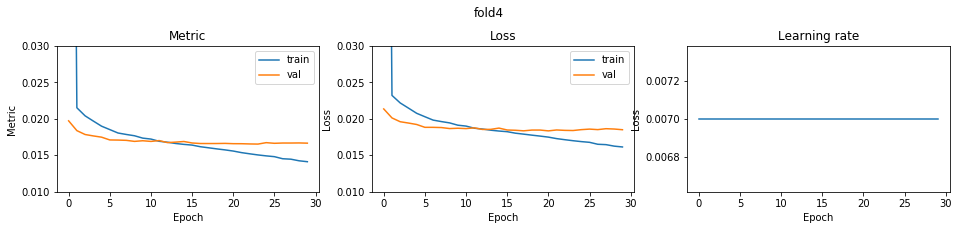

CV score: 0.016507832216526356

optimizer: AdamW
fold 0


epoch1 save best model... 0.01995389378355956
epoch2 save best model... 0.018522652362500888
epoch3 save best model... 0.017894819600333657
epoch4 save best model... 0.017488126445705906
epoch5 save best model... 0.017386221691355074
epoch6 save best model... 0.017301016853345827
epoch7 save best model... 0.017132351865699186
epoch8 save best model... 0.016874480435034953
epoch9 save best model... 0.01681811287490002
epoch10 save best model... 0.01675447338602266
epoch11 save best model... 0.016728732292805554
epoch12 save best model... 0.016574186167270286
epoch13 save best model... 0.016527052682767152
epoch14 save best model... 0.016481598012641513
epoch16 save best model... 0.016477020668260466
epoch17 save best model... 0.016472089544770252
epoch18 save best model... 0.01640237443327293
epoch19 save best model... 0.016387342984930258
epoch21 save best model... 0.016362354787308426
epoch22 save best model... 0.01636219082277158
fold0 score: 0.0163621906942919


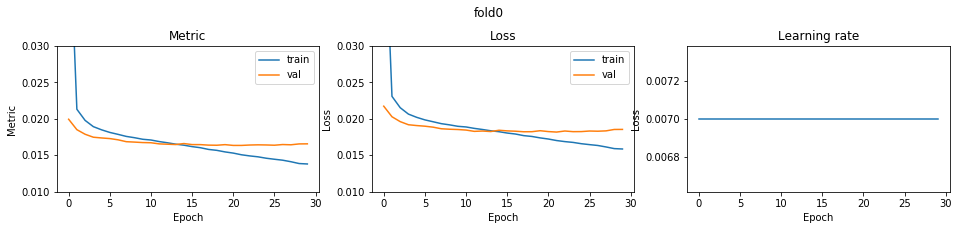

fold 1


epoch1 save best model... 0.019863268304900553
epoch2 save best model... 0.01878354764709198
epoch3 save best model... 0.018224650227071537
epoch4 save best model... 0.0176576342345418
epoch5 save best model... 0.017501244922825294
epoch6 save best model... 0.01733172354690508
epoch7 save best model... 0.017203267753687825
epoch8 save best model... 0.017189377105284943
epoch9 save best model... 0.017052021490842423
epoch10 save best model... 0.016904570205159626
epoch12 save best model... 0.016821283934942192
epoch15 save best model... 0.01674701863809432
epoch17 save best model... 0.01668154543970611
epoch20 save best model... 0.016675990872300685
epoch21 save best model... 0.016665217390898882
fold1 score: 0.01666521728433915


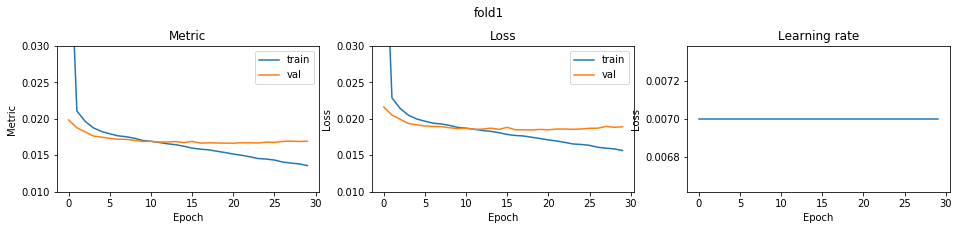

fold 2


epoch1 save best model... 0.020031227513988187
epoch2 save best model... 0.018517921740046177
epoch3 save best model... 0.018027869331372248
epoch4 save best model... 0.017468702319248117
epoch5 save best model... 0.017346862200660323
epoch6 save best model... 0.01715429049468198
epoch7 save best model... 0.017099891862676894
epoch8 save best model... 0.016916382735933346
epoch9 save best model... 0.01684391180655562
epoch10 save best model... 0.016807272237946026
epoch11 save best model... 0.01675145039990575
epoch12 save best model... 0.016704124904401714
epoch13 save best model... 0.01666207177792399
epoch14 save best model... 0.01663082228253319
epoch15 save best model... 0.016452827294373883
epoch16 save best model... 0.01636589428473168
fold2 score: 0.01636589415655246


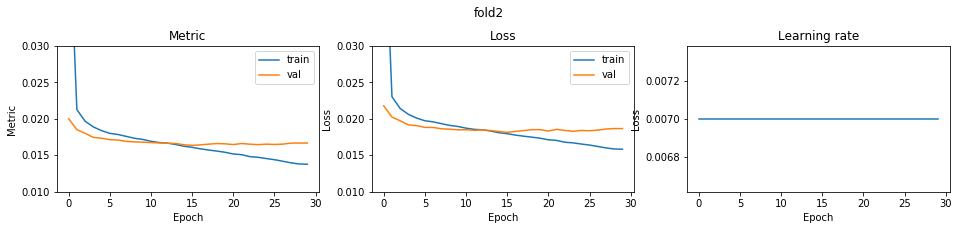

fold 3


epoch1 save best model... 0.0199067949268602
epoch2 save best model... 0.01873005282405365
epoch3 save best model... 0.018099421708672764
epoch4 save best model... 0.017840202586780513
epoch5 save best model... 0.0174884047541674
epoch6 save best model... 0.01743244556943485
epoch7 save best model... 0.017326629538606673
epoch8 save best model... 0.017097784247851862
epoch9 save best model... 0.017062563908653405
epoch10 save best model... 0.016848134847277253
epoch12 save best model... 0.016841738773318928
epoch13 save best model... 0.016727572883604463
epoch14 save best model... 0.016641775511230653
epoch17 save best model... 0.016632343921598243
epoch19 save best model... 0.01660757481008089
epoch22 save best model... 0.016515598764774604
fold3 score: 0.016515598596881967


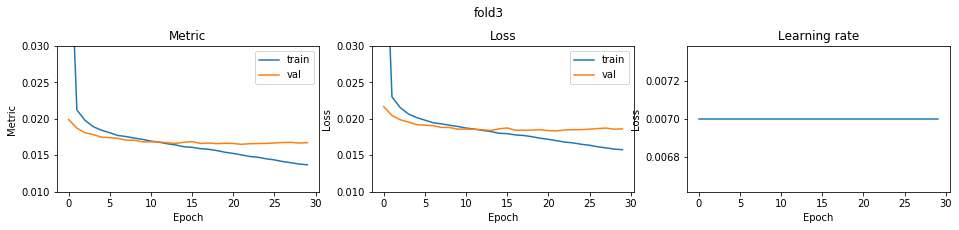

fold 4


epoch1 save best model... 0.020504870205472706
epoch2 save best model... 0.01838134840249608
epoch3 save best model... 0.01784151595272548
epoch4 save best model... 0.01754185898793789
epoch5 save best model... 0.017290250075756144
epoch6 save best model... 0.017176142187708465
epoch7 save best model... 0.017097836586907677
epoch8 save best model... 0.016993779901219936
epoch9 save best model... 0.01699013458289087
epoch10 save best model... 0.016935230472076318
epoch11 save best model... 0.016871923520091862
epoch12 save best model... 0.016693577304448516
epoch14 save best model... 0.016633443387144654
epoch16 save best model... 0.01660306563002645
epoch20 save best model... 0.016558768862862658
fold4 score: 0.016558768829263132


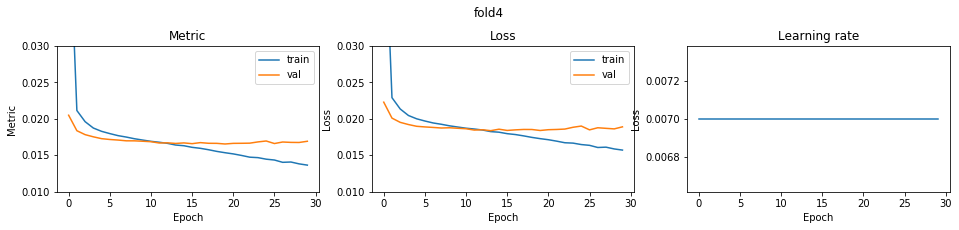

CV score: 0.01649353190553999

optimizer: AdamP
fold 0


epoch1 save best model... 0.02078800522690482
epoch2 save best model... 0.01876420739418689
epoch3 save best model... 0.017810766452367593
epoch4 save best model... 0.017490070104463226
epoch5 save best model... 0.01728283496645697
epoch6 save best model... 0.017211928317887638
epoch7 save best model... 0.017124832146599517
epoch8 save best model... 0.016853223096978148
epoch11 save best model... 0.016786041036927074
epoch13 save best model... 0.01674852311814836
epoch14 save best model... 0.01674196436780596
epoch15 save best model... 0.016633230913642598
epoch16 save best model... 0.016567776218939206
epoch19 save best model... 0.01647235353292732
epoch23 save best model... 0.016407695043076823
epoch24 save best model... 0.016392763587805295
epoch25 save best model... 0.01633330571692191
epoch28 save best model... 0.016310395678857465
fold0 score: 0.016310395616779123


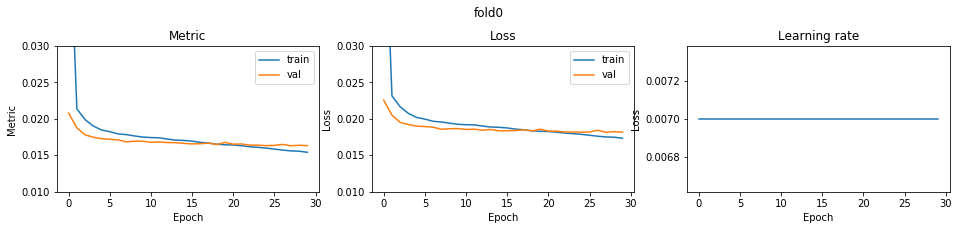

fold 1


epoch1 save best model... 0.019764554045379745
epoch2 save best model... 0.018609238732041733
epoch3 save best model... 0.01797607597358326
epoch4 save best model... 0.017667896254338268
epoch5 save best model... 0.017568768930869075
epoch6 save best model... 0.0174788520441196
epoch7 save best model... 0.017179235173476314
epoch9 save best model... 0.017115696574614134
epoch11 save best model... 0.017056398949693862
epoch12 save best model... 0.016981792677169264
epoch13 save best model... 0.016889660453687404
epoch15 save best model... 0.01687832957222348
epoch16 save best model... 0.01684121520692
epoch17 save best model... 0.016813974546157816
epoch19 save best model... 0.016748004546484473
epoch23 save best model... 0.016628211752041974
epoch30 save best model... 0.01661575008412888
fold1 score: 0.016615749872643745


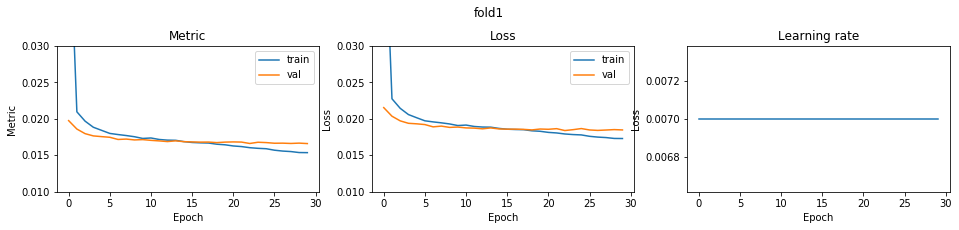

fold 2


epoch1 save best model... 0.02055298665054202
epoch2 save best model... 0.018698090722194076
epoch3 save best model... 0.018015227057540516
epoch4 save best model... 0.017639637745850638
epoch5 save best model... 0.017317262360404716
epoch7 save best model... 0.017137194905785715
epoch10 save best model... 0.01698608235234306
epoch11 save best model... 0.016772150646833208
epoch12 save best model... 0.016709959099659562
epoch14 save best model... 0.01667856676773503
epoch15 save best model... 0.016673288090584434
epoch17 save best model... 0.01658644287522961
epoch22 save best model... 0.016537406307166217
epoch24 save best model... 0.016446882693360542
epoch25 save best model... 0.016427901540588995
epoch26 save best model... 0.016418911439003148
epoch29 save best model... 0.016399600623927944
fold2 score: 0.01639960045611748


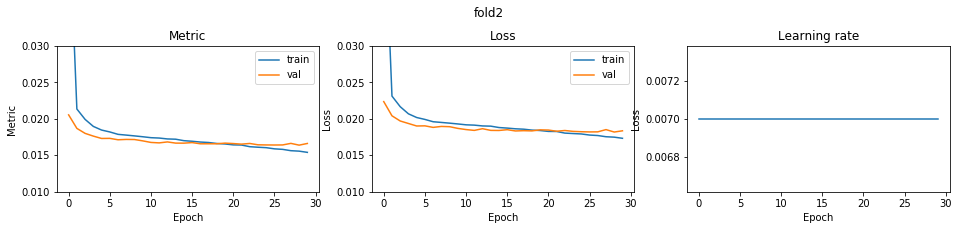

fold 3


epoch1 save best model... 0.020021967316186374
epoch2 save best model... 0.01858424391079872
epoch3 save best model... 0.018186033817945823
epoch4 save best model... 0.017822269186937592
epoch5 save best model... 0.017530431805479772
epoch6 save best model... 0.01738991591493877
epoch7 save best model... 0.01721498201980949
epoch9 save best model... 0.01712119876320107
epoch11 save best model... 0.017107850563519364
epoch12 save best model... 0.016971870489707025
epoch14 save best model... 0.016861660027524334
epoch16 save best model... 0.016846327484926902
epoch17 save best model... 0.016822367775463976
epoch18 save best model... 0.016733010780227483
epoch21 save best model... 0.016620751870859728
epoch26 save best model... 0.016577536694637598
epoch27 save best model... 0.016541296200814036
fold3 score: 0.016541296221461742


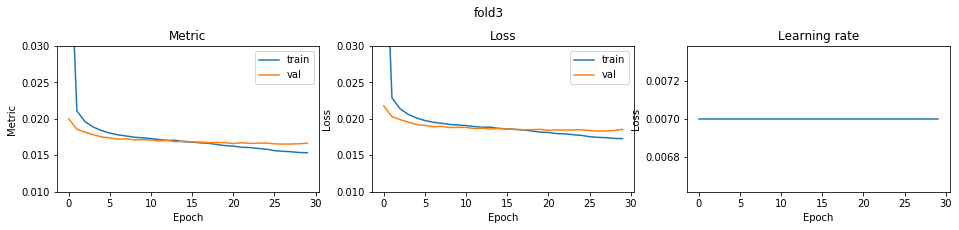

fold 4


epoch1 save best model... 0.019717208022816034
epoch2 save best model... 0.018376326467205426
epoch3 save best model... 0.017970280733663836
epoch4 save best model... 0.01762437909578476
epoch5 save best model... 0.017472522340477328
epoch6 save best model... 0.0173214680292476
epoch7 save best model... 0.017113660377766387
epoch9 save best model... 0.017026395016776268
epoch10 save best model... 0.017000038332490416
epoch11 save best model... 0.016897516495257548
epoch13 save best model... 0.01677158489135987
epoch16 save best model... 0.016661830086914443
epoch20 save best model... 0.01652164985224231
epoch22 save best model... 0.01651255916634358
epoch25 save best model... 0.01643582329425562
fold4 score: 0.016435823275329987


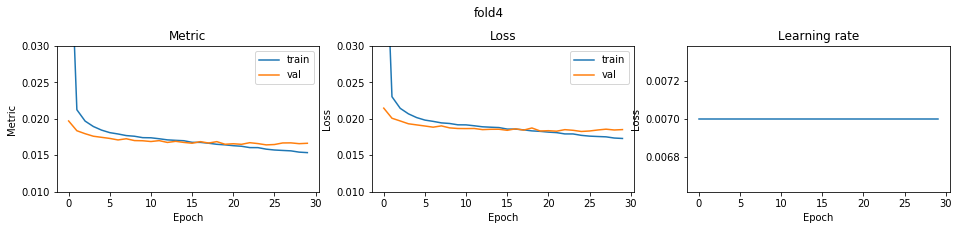

CV score: 0.016460568796314426

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.020084545521197122
epoch2 save best model... 0.01878751601964439
epoch3 save best model... 0.01797283213067978
epoch4 save best model... 0.017679643914409
epoch5 save best model... 0.017394422512323274
epoch6 save best model... 0.017156104172382648
epoch7 save best model... 0.0169944295909994
epoch9 save best model... 0.01688888665449918
epoch11 save best model... 0.016748713541580768
epoch13 save best model... 0.01663865293450399
epoch16 save best model... 0.016608085555866667
epoch18 save best model... 0.016568367019431467
epoch26 save best model... 0.016494908412506885
fold0 score: 0.016494908369958945


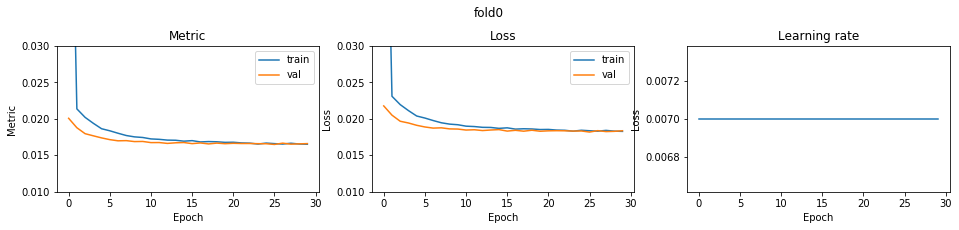

fold 1


epoch1 save best model... 0.020384076222230752
epoch2 save best model... 0.01876320878769901
epoch3 save best model... 0.018061901291623952
epoch4 save best model... 0.0177482583365467
epoch5 save best model... 0.017422360811347733
epoch6 save best model... 0.017371022856929465
epoch7 save best model... 0.017231251147492285
epoch9 save best model... 0.016993927853604224
epoch11 save best model... 0.01697566443776271
epoch14 save best model... 0.01695572756278363
epoch16 save best model... 0.016870208385899768
epoch19 save best model... 0.0168661040407354
epoch20 save best model... 0.016841733181205323
epoch22 save best model... 0.01681605439741775
fold1 score: 0.016816054334396303


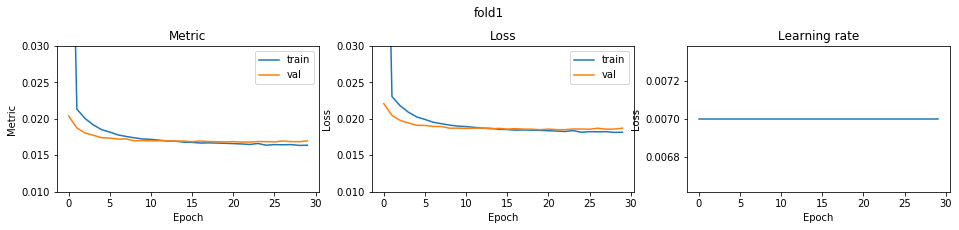

fold 2


epoch1 save best model... 0.02030810342299949
epoch2 save best model... 0.01884306163995385
epoch3 save best model... 0.018120265434676257
epoch4 save best model... 0.017616054211232
epoch5 save best model... 0.01744891375988233
epoch6 save best model... 0.017270109534525034
epoch7 save best model... 0.017100105612772382
epoch8 save best model... 0.016951591091764816
epoch9 save best model... 0.01687158710107048
epoch10 save best model... 0.016838186222098227
epoch13 save best model... 0.0168075419832543
epoch14 save best model... 0.016764612357463373
epoch16 save best model... 0.0166956766638595
epoch17 save best model... 0.01667558027214506
epoch19 save best model... 0.016598448571938946
epoch22 save best model... 0.016578639497164375
epoch24 save best model... 0.016572170083466845
fold2 score: 0.016572170048783086


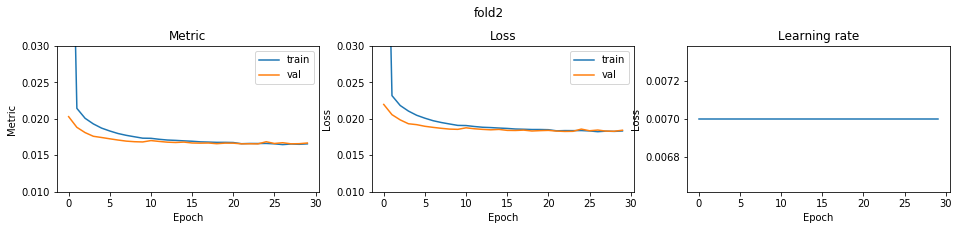

fold 3


epoch1 save best model... 0.020294850838533975
epoch2 save best model... 0.019104080129168706
epoch3 save best model... 0.01837423375228543
epoch4 save best model... 0.017882864337185386
epoch5 save best model... 0.017566520484389232
epoch6 save best model... 0.01748617757620939
epoch7 save best model... 0.01737131542931385
epoch8 save best model... 0.017180436608171545
epoch9 save best model... 0.01717902624635938
epoch10 save best model... 0.0170621544703977
epoch11 save best model... 0.017060463556888297
epoch12 save best model... 0.016902315759594323
epoch15 save best model... 0.01686139457004149
epoch16 save best model... 0.016778360634770645
epoch22 save best model... 0.016769685365836687
epoch28 save best model... 0.01674809497452271
fold3 score: 0.016748094986972748


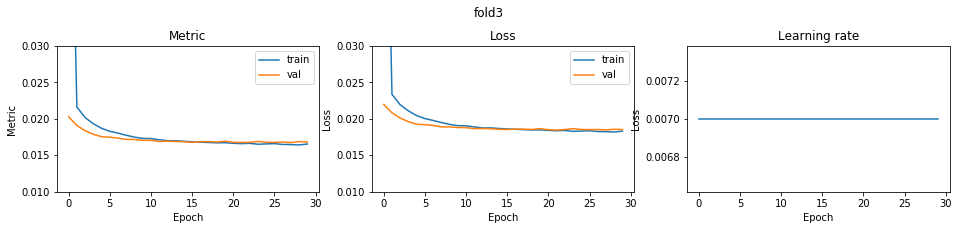

fold 4


epoch1 save best model... 0.019996864281611727
epoch2 save best model... 0.018711131000742825
epoch3 save best model... 0.01797531540834415
epoch4 save best model... 0.01765192507814981
epoch5 save best model... 0.017409469505903524
epoch6 save best model... 0.01719488957408892
epoch7 save best model... 0.017044603787277717
epoch8 save best model... 0.017013644952759793
epoch10 save best model... 0.016922912935478134
epoch11 save best model... 0.016841470409855078
epoch13 save best model... 0.016796412758087922
epoch15 save best model... 0.01670972229976521
epoch20 save best model... 0.016703839174096298
epoch25 save best model... 0.0166976076154068
epoch28 save best model... 0.016662045756613748
epoch29 save best model... 0.01665054691789973
fold4 score: 0.01665054677657926


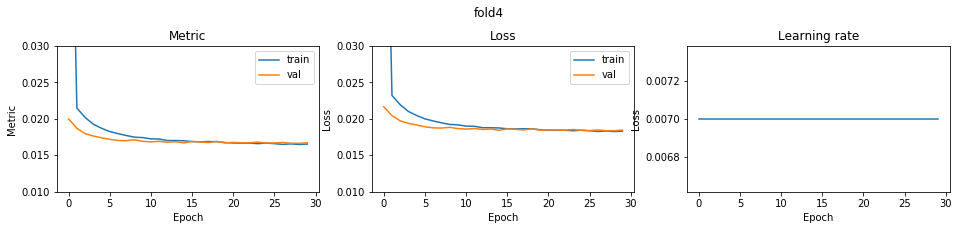

CV score: 0.016656351462724962

optimizer: Lamb
fold 0


epoch1 save best model... 0.020170473498302876
epoch2 save best model... 0.01836798859077054
epoch3 save best model... 0.017826112535419388
epoch4 save best model... 0.01758760793266101
epoch5 save best model... 0.017242625239464307
epoch6 save best model... 0.016972821853325146
epoch7 save best model... 0.016909812578341683
epoch8 save best model... 0.016764000519804638
epoch9 save best model... 0.01663174143226516
epoch10 save best model... 0.016550679426801503
epoch11 save best model... 0.016479892835258622
epoch12 save best model... 0.016396771227953646
epoch14 save best model... 0.016331447552304063
epoch15 save best model... 0.016290606947823645
fold0 score: 0.016290606859216978


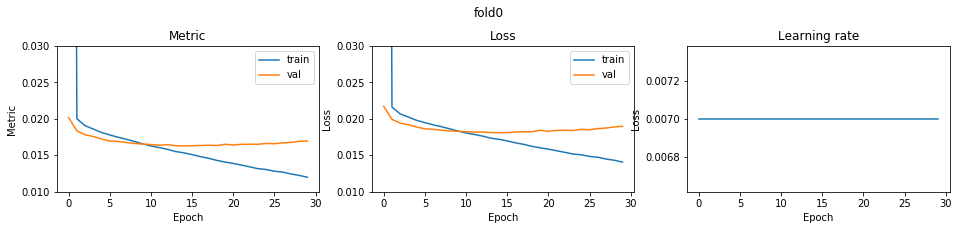

fold 1


epoch1 save best model... 0.02003333178610051
epoch2 save best model... 0.01838154188429652
epoch3 save best model... 0.018126274544154084
epoch4 save best model... 0.017710245626696992
epoch5 save best model... 0.017518754879606423
epoch6 save best model... 0.01733678519194464
epoch7 save best model... 0.017168919293782413
epoch8 save best model... 0.017062188638597015
epoch9 save best model... 0.01693145225431849
epoch10 save best model... 0.016901666567147144
epoch11 save best model... 0.016806102798533184
epoch12 save best model... 0.016733377311471235
epoch13 save best model... 0.0166609885460065
epoch14 save best model... 0.016653759082905333
epoch15 save best model... 0.016649839938736012
fold1 score: 0.016649839932121147


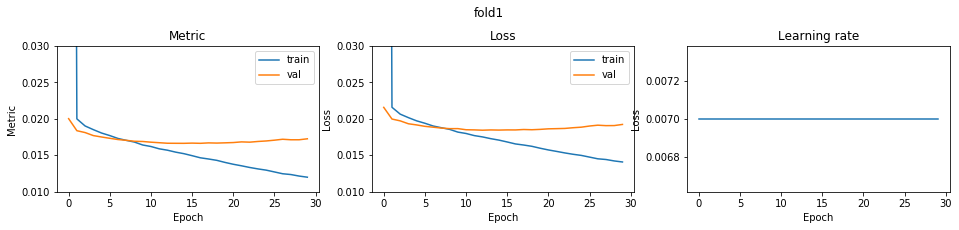

fold 2


epoch1 save best model... 0.020073322249938453
epoch2 save best model... 0.018440485761116187
epoch3 save best model... 0.017871671740121005
epoch4 save best model... 0.017588041610947895
epoch5 save best model... 0.017396867176567497
epoch6 save best model... 0.01714039304458992
epoch7 save best model... 0.01694932064912767
epoch8 save best model... 0.01678977803640979
epoch9 save best model... 0.016652231627307522
epoch10 save best model... 0.016640081747476835
epoch11 save best model... 0.01656166320986236
epoch12 save best model... 0.01650029413404627
epoch13 save best model... 0.016438441863718515
epoch15 save best model... 0.016437565586148783
epoch16 save best model... 0.016409243236761222
epoch18 save best model... 0.01636125642817326
fold2 score: 0.016361256369695945


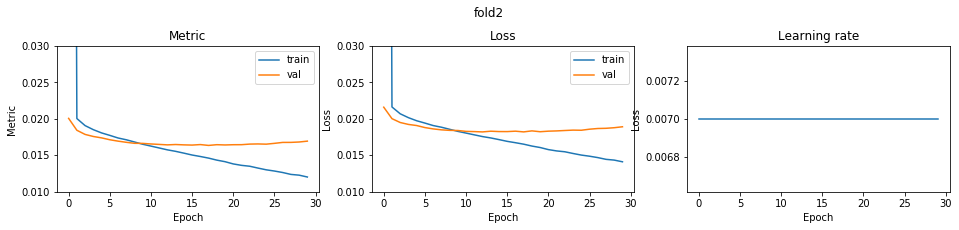

fold 3


epoch1 save best model... 0.02048412424751933
epoch2 save best model... 0.018571609740224
epoch3 save best model... 0.017964472695081952
epoch4 save best model... 0.01767987348860584
epoch5 save best model... 0.017446263890993487
epoch6 save best model... 0.017293050752821164
epoch7 save best model... 0.01712411753366572
epoch8 save best model... 0.01703529212250457
epoch9 save best model... 0.01688829374654486
epoch10 save best model... 0.016837250832086408
epoch12 save best model... 0.01671021860177737
epoch13 save best model... 0.016661380408310538
epoch14 save best model... 0.0166213950456241
epoch20 save best model... 0.01661160818867572
fold3 score: 0.016611608108779544


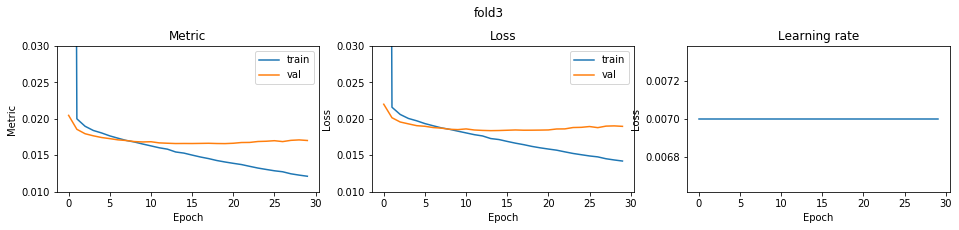

fold 4


epoch1 save best model... 0.01986548883632538
epoch2 save best model... 0.018252723320792502
epoch3 save best model... 0.017846915064748708
epoch4 save best model... 0.017526106066272036
epoch5 save best model... 0.017321896419387337
epoch6 save best model... 0.017204955930064235
epoch7 save best model... 0.01707898148914676
epoch8 save best model... 0.016906893229990314
epoch9 save best model... 0.016818581437925407
epoch10 save best model... 0.01676663450073612
epoch11 save best model... 0.016672331187661933
epoch12 save best model... 0.016617324119667123
epoch15 save best model... 0.01655193231787728
fold4 score: 0.016551932324598416


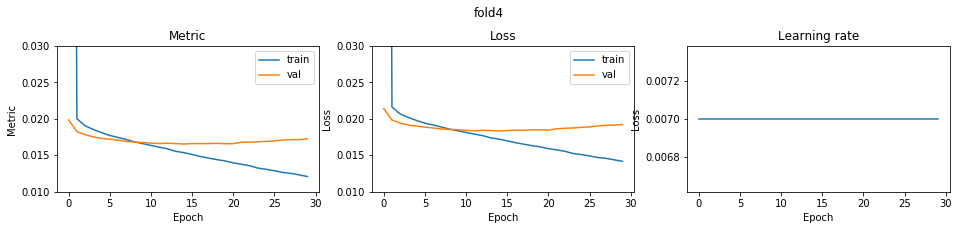

CV score: 0.01649304757987821

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018501669087008083
epoch2 save best model... 0.01772869570278361
epoch3 save best model... 0.017281105698580622
epoch4 save best model... 0.017070259940481676
epoch5 save best model... 0.016920622396611677
epoch6 save best model... 0.016623517225978043
epoch7 save best model... 0.016548555554792385
epoch8 save best model... 0.01643855162983196
epoch9 save best model... 0.016349086298656085
epoch10 save best model... 0.016339495622792657
epoch11 save best model... 0.016279970286392813
epoch12 save best model... 0.016258085234799255
epoch14 save best model... 0.016202692556404986
epoch15 save best model... 0.01618400104937901
fold0 score: 0.016184001005598893


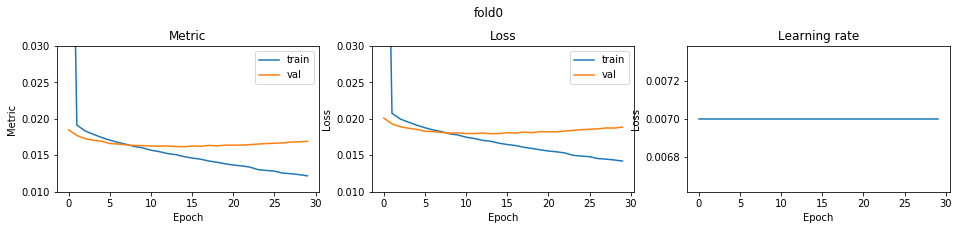

fold 1


epoch1 save best model... 0.018617009714765247
epoch2 save best model... 0.017873448426254886
epoch3 save best model... 0.01745659738989565
epoch4 save best model... 0.017177096028012467
epoch5 save best model... 0.016974462403332925
epoch7 save best model... 0.01679076563514299
epoch8 save best model... 0.016693390741193994
epoch9 save best model... 0.01667350026768055
epoch10 save best model... 0.016566083433162137
epoch13 save best model... 0.0165610072392046
fold1 score: 0.016561007131508654


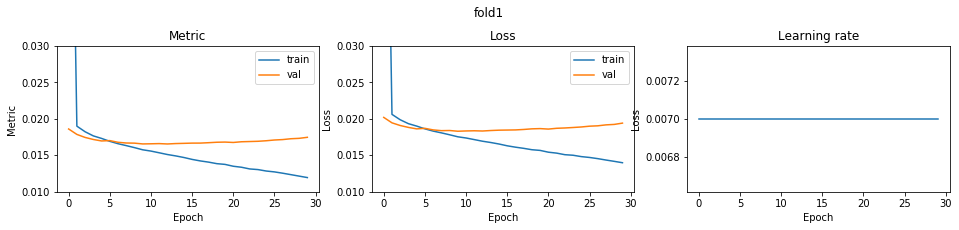

fold 2


epoch1 save best model... 0.01847165915499681
epoch2 save best model... 0.017696845147221446
epoch3 save best model... 0.01737684261573253
epoch4 save best model... 0.017056216556671392
epoch5 save best model... 0.017007242353905928
epoch6 save best model... 0.016712026462836524
epoch7 save best model... 0.0166083559496585
epoch8 save best model... 0.01657939073475836
epoch9 save best model... 0.01651703390318499
epoch10 save best model... 0.016415334736139403
epoch11 save best model... 0.016370596232791985
epoch12 save best model... 0.01629229626979269
fold2 score: 0.016292296223408952


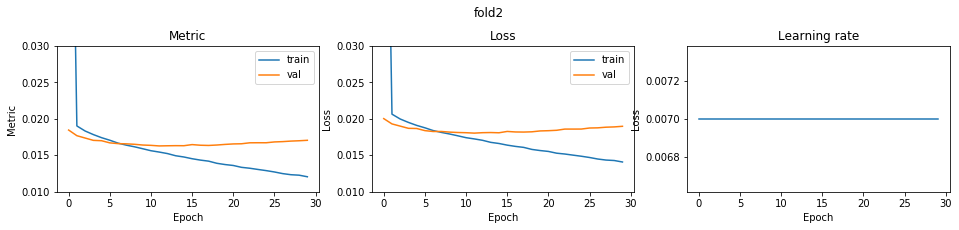

fold 3


epoch1 save best model... 0.01880167521078114
epoch2 save best model... 0.01780090039269256
epoch3 save best model... 0.017535035546385344
epoch4 save best model... 0.01727309795542024
epoch5 save best model... 0.017069116084579727
epoch6 save best model... 0.01687721504165806
epoch7 save best model... 0.01675904284237729
epoch8 save best model... 0.016647985056551823
epoch9 save best model... 0.016587648888655295
epoch10 save best model... 0.01650959054827011
epoch11 save best model... 0.016448015042056664
epoch14 save best model... 0.016445054527550323
epoch15 save best model... 0.016416228451853053
fold3 score: 0.01641622843468572


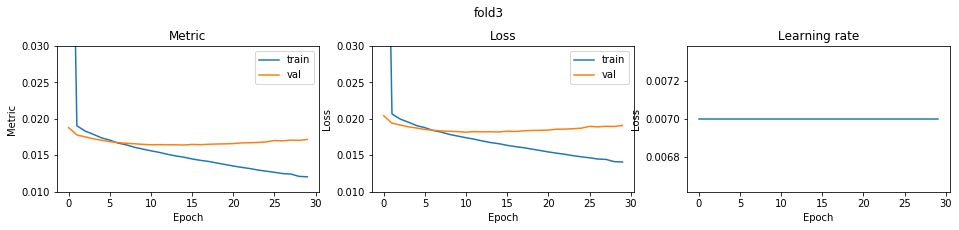

fold 4


epoch1 save best model... 0.018485726282883072
epoch2 save best model... 0.01766435648049472
epoch3 save best model... 0.017374586068297438
epoch4 save best model... 0.017225651209219307
epoch5 save best model... 0.017055528069547205
epoch6 save best model... 0.01680612115482195
epoch7 save best model... 0.01671581398186556
epoch8 save best model... 0.016565428406068023
epoch11 save best model... 0.016505108729157607
epoch12 save best model... 0.016461693729721602
fold4 score: 0.016461693735592656


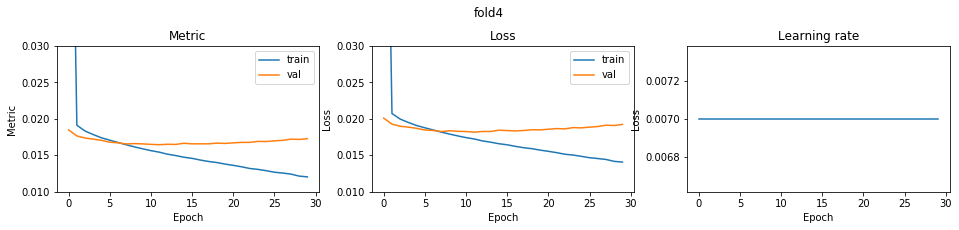

CV score: 0.016383041332551238

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.0201660403213835
epoch2 save best model... 0.018846071517447133
epoch3 save best model... 0.018312777205453105
epoch4 save best model... 0.017624458345607906
epoch5 save best model... 0.01746282910414736
epoch6 save best model... 0.017226177953811605
epoch7 save best model... 0.01707899713960894
epoch9 save best model... 0.016945493427489234
epoch10 save best model... 0.016710482586115804
epoch12 save best model... 0.016621518736717914
epoch14 save best model... 0.01661725528198793
epoch15 save best model... 0.016489186852847934
epoch16 save best model... 0.016406489198004873
epoch19 save best model... 0.01637016625561516
epoch20 save best model... 0.016363805623678385
epoch24 save best model... 0.016270933747885574
fold0 score: 0.01627093372258861


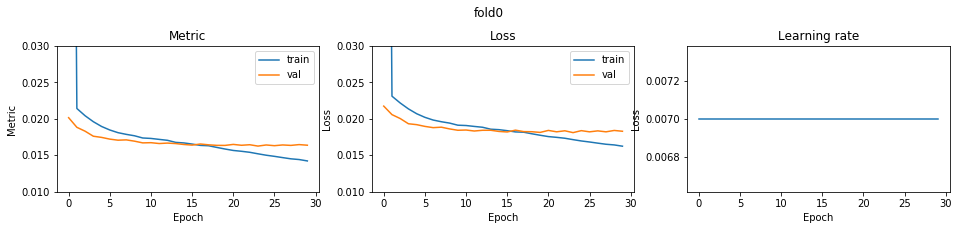

fold 1


epoch1 save best model... 0.020665349191367477
epoch2 save best model... 0.019065509596744058
epoch3 save best model... 0.01833762622110106
epoch4 save best model... 0.01808689224265735
epoch5 save best model... 0.017694630716560467
epoch6 save best model... 0.017548340372104638
epoch7 save best model... 0.017272992253958785
epoch8 save best model... 0.017122234817272604
epoch10 save best model... 0.017036752101381076
epoch11 save best model... 0.0169872024615789
epoch12 save best model... 0.016918470630433693
epoch13 save best model... 0.016834195328107808
epoch14 save best model... 0.01676641401488272
epoch15 save best model... 0.016756865199961703
epoch20 save best model... 0.01662377524067639
epoch22 save best model... 0.016594885943313615
fold1 score: 0.01659488593040112


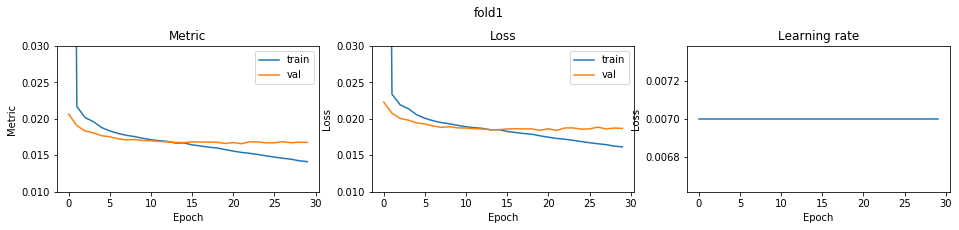

fold 2


epoch1 save best model... 0.02059398761019535
epoch2 save best model... 0.018976091382837047
epoch3 save best model... 0.018368352891647698
epoch4 save best model... 0.01795849384662332
epoch5 save best model... 0.017597764348927406
epoch6 save best model... 0.017302545610629404
epoch8 save best model... 0.017147925489905295
epoch9 save best model... 0.017137537646073637
epoch10 save best model... 0.01699989916186794
epoch11 save best model... 0.01677312512089931
epoch14 save best model... 0.016758652367241007
epoch15 save best model... 0.016725270701438616
epoch16 save best model... 0.016687882723366108
epoch17 save best model... 0.016638501393011422
epoch18 save best model... 0.016595076157408645
epoch19 save best model... 0.016507155800696168
epoch22 save best model... 0.016388036633633106
fold2 score: 0.01638803661520128


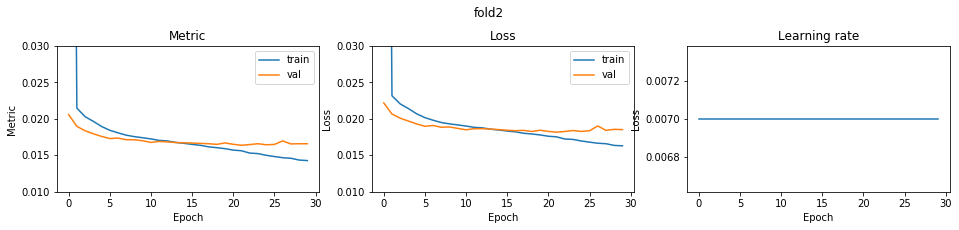

fold 3


epoch1 save best model... 0.020584172861553
epoch2 save best model... 0.019028153864068566
epoch3 save best model... 0.01839384995613052
epoch4 save best model... 0.017952791767742206
epoch5 save best model... 0.01782783476046047
epoch6 save best model... 0.017569041494407387
epoch7 save best model... 0.017426995409902925
epoch8 save best model... 0.017355628016750606
epoch9 save best model... 0.017245026492430978
epoch10 save best model... 0.01704902194126388
epoch12 save best model... 0.017029864705912345
epoch13 save best model... 0.017000824290673528
epoch14 save best model... 0.016980317510358972
epoch15 save best model... 0.016925839697920924
epoch16 save best model... 0.016719204808133475
epoch21 save best model... 0.016594340189324017
fold3 score: 0.01659433999622896


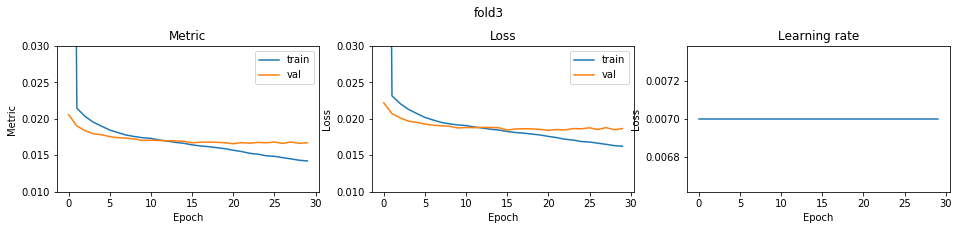

fold 4


epoch1 save best model... 0.019968820282667537
epoch2 save best model... 0.018857354274473593
epoch3 save best model... 0.018069333277201463
epoch4 save best model... 0.0178509872589167
epoch5 save best model... 0.01761644707530194
epoch6 save best model... 0.017352122755335105
epoch7 save best model... 0.017098690790457307
epoch8 save best model... 0.017089604072120033
epoch9 save best model... 0.017050331938324458
epoch10 save best model... 0.01691140535039348
epoch13 save best model... 0.016875694430770527
epoch14 save best model... 0.016843916342120645
epoch15 save best model... 0.016735936369925125
epoch17 save best model... 0.016697696777981344
epoch20 save best model... 0.016620861290867074
epoch25 save best model... 0.01652192417744352
fold4 score: 0.016521924142385774


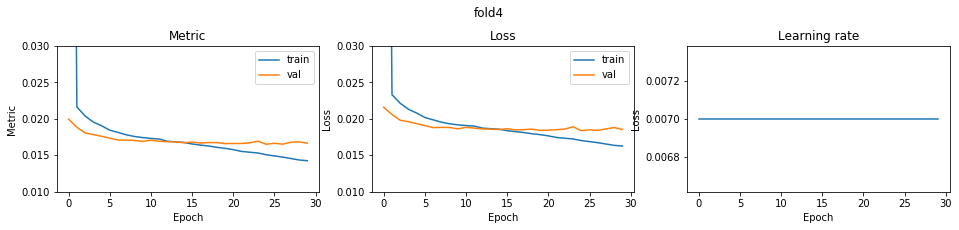

CV score: 0.016474022492406218

optimizer: QHAdam
fold 0


epoch1 save best model... 0.0201504300125707
epoch2 save best model... 0.018420173211663893
epoch3 save best model... 0.017870464353293928
epoch4 save best model... 0.017614581355303187
epoch5 save best model... 0.017350730388202538
epoch6 save best model... 0.01727732897890999
epoch9 save best model... 0.01709955083906379
fold0 score: 0.01709955096777737


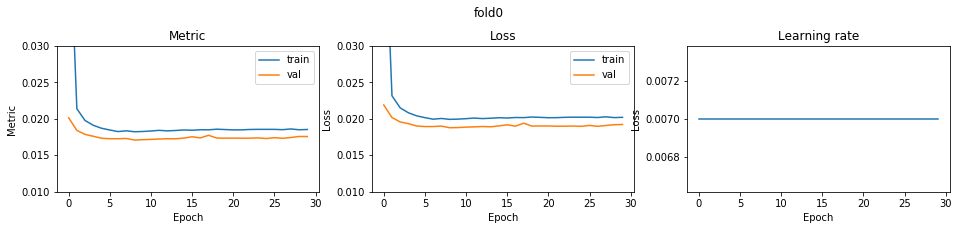

fold 1


epoch1 save best model... 0.0201515352235049
epoch2 save best model... 0.01860007434093713
epoch3 save best model... 0.018334170536486755
epoch4 save best model... 0.017803295902733
epoch5 save best model... 0.017627525403688237
epoch6 save best model... 0.017495847516581772
epoch8 save best model... 0.017443620774018165
epoch9 save best model... 0.01739285222967031
fold1 score: 0.017392852312076216


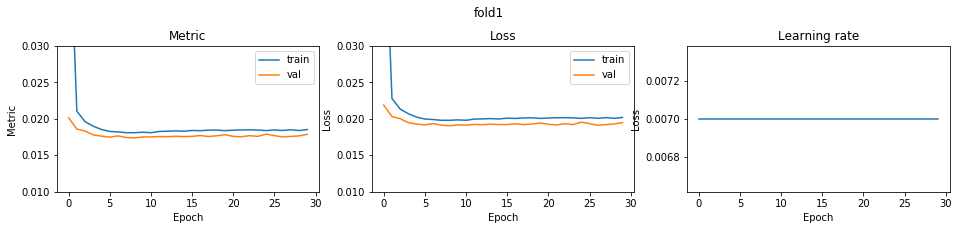

fold 2


epoch1 save best model... 0.020170826498842588
epoch2 save best model... 0.018824111701236088
epoch3 save best model... 0.017950556093076143
epoch4 save best model... 0.017541114651905932
epoch6 save best model... 0.017464999614105622
epoch7 save best model... 0.017176887633923613
fold2 score: 0.017176887643919118


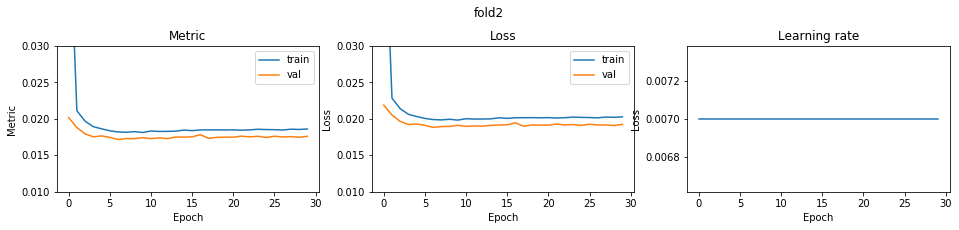

fold 3


epoch1 save best model... 0.02029732412749855
epoch2 save best model... 0.01866816375828889
epoch3 save best model... 0.0181419142948332
epoch4 save best model... 0.017731687778305763
epoch5 save best model... 0.01766407909996146
epoch6 save best model... 0.017513821414483027
epoch10 save best model... 0.01746585346028582
epoch11 save best model... 0.01746522091787334
epoch14 save best model... 0.01743931918275587
fold3 score: 0.01743931921492138


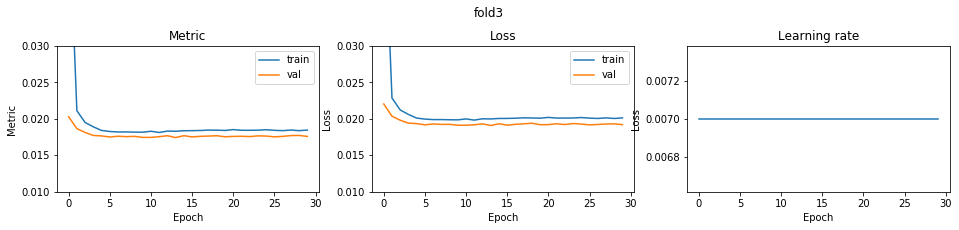

fold 4


epoch1 save best model... 0.019707174635659862
epoch2 save best model... 0.018346688438181453
epoch3 save best model... 0.01786733017025138
epoch4 save best model... 0.01774151154532859
epoch5 save best model... 0.017526389772161536
epoch6 save best model... 0.017388993273818005
epoch7 save best model... 0.017386089134664363
epoch10 save best model... 0.017349123199531864
epoch11 save best model... 0.01732384250552345
fold4 score: 0.01732384253734988


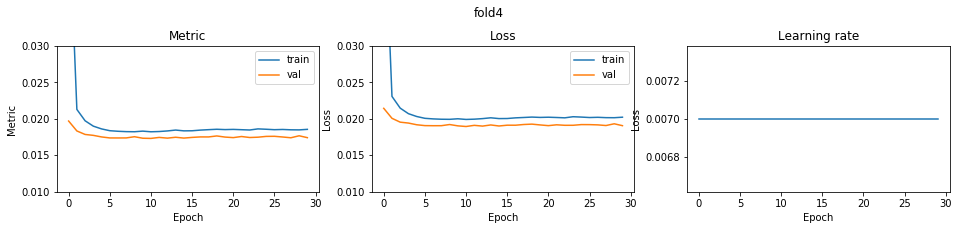

CV score: 0.01728649068288122

optimizer: RAdam
fold 0


epoch1 save best model... 0.02045595294844724
epoch2 save best model... 0.01889260104838292
epoch3 save best model... 0.018173623856386184
epoch4 save best model... 0.01774205552638935
epoch5 save best model... 0.01764797509259678
epoch6 save best model... 0.017194492092402758
epoch7 save best model... 0.017165719520020592
epoch8 save best model... 0.016927834920975503
epoch9 save best model... 0.016885641717048604
epoch10 save best model... 0.016834783833261775
epoch11 save best model... 0.0167742244076145
epoch12 save best model... 0.016605620871983248
epoch15 save best model... 0.01653091316121993
epoch16 save best model... 0.016437082223865737
epoch19 save best model... 0.016405738772217668
epoch20 save best model... 0.01640084574257866
epoch22 save best model... 0.016372533902474985
epoch23 save best model... 0.016357605001445782
epoch24 save best model... 0.016266029752400577
fold0 score: 0.016266029607960947


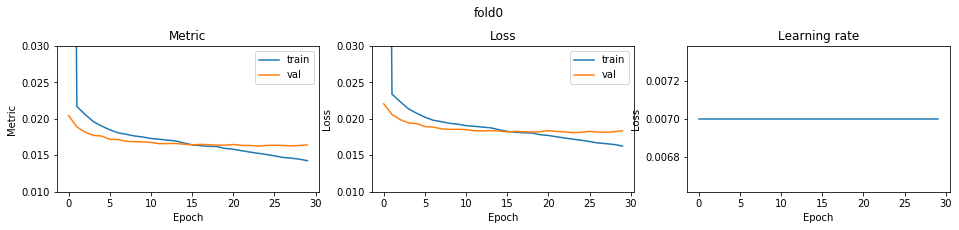

fold 1


epoch1 save best model... 0.020975953959375043
epoch2 save best model... 0.019383817182471442
epoch3 save best model... 0.01842920117650591
epoch4 save best model... 0.01806221057114052
epoch5 save best model... 0.017862358894203376
epoch6 save best model... 0.017461535922960583
epoch7 save best model... 0.017190757281628413
epoch9 save best model... 0.01713277984560758
epoch10 save best model... 0.017094375546974943
epoch12 save best model... 0.01699426526080254
epoch13 save best model... 0.016951444541187105
epoch15 save best model... 0.016897490681385664
epoch17 save best model... 0.01672469418496742
epoch19 save best model... 0.01666947459158233
epoch22 save best model... 0.016645440206867018
epoch26 save best model... 0.016588547839308878
fold1 score: 0.016588547773041293


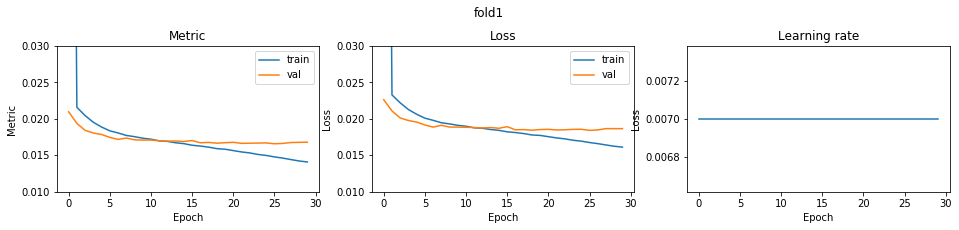

fold 2


epoch1 save best model... 0.021107302544484462
epoch2 save best model... 0.018855312828965083
epoch3 save best model... 0.018148152045625494
epoch4 save best model... 0.017861053172739144
epoch5 save best model... 0.01775336056721933
epoch6 save best model... 0.017266242398005543
epoch7 save best model... 0.01706494578183899
epoch8 save best model... 0.016995199438456957
epoch9 save best model... 0.016926759517206083
epoch10 save best model... 0.016883104657221693
epoch11 save best model... 0.016787044731333536
epoch12 save best model... 0.016721983100921017
epoch16 save best model... 0.016610650666097106
epoch19 save best model... 0.016517345565011544
epoch21 save best model... 0.016512032705627587
epoch22 save best model... 0.01648576939501858
epoch24 save best model... 0.016445786396827058
fold2 score: 0.01644578624219286


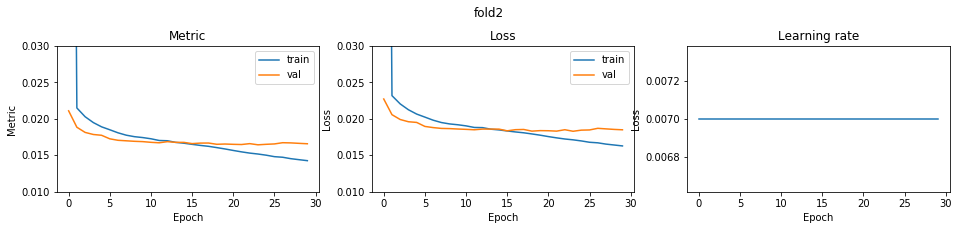

fold 3


epoch1 save best model... 0.020609166628441398
epoch2 save best model... 0.019120348964081674
epoch3 save best model... 0.01856055177943378
epoch4 save best model... 0.018055997466019318
epoch5 save best model... 0.017760029730041232
epoch6 save best model... 0.017646944970910804
epoch7 save best model... 0.01736099644349824
epoch9 save best model... 0.017139428280344857
epoch10 save best model... 0.017018052829951388
epoch12 save best model... 0.016955622051819174
epoch13 save best model... 0.01685738270648316
epoch16 save best model... 0.01676847796615612
epoch19 save best model... 0.01670511774973337
epoch20 save best model... 0.016645822318903
epoch21 save best model... 0.016582636746889774
fold3 score: 0.01658263658092146


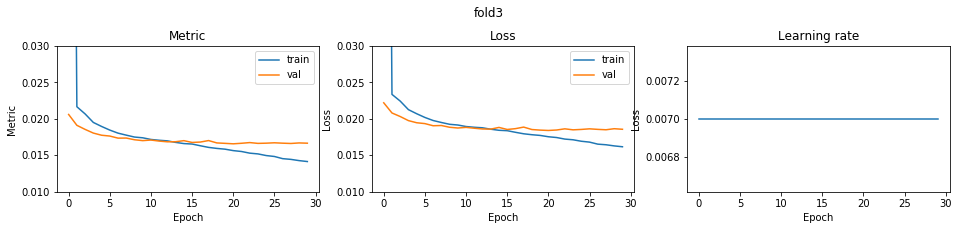

fold 4


epoch1 save best model... 0.019930497577290873
epoch2 save best model... 0.018734040992983654
epoch3 save best model... 0.01798607076354885
epoch4 save best model... 0.017809065761031893
epoch5 save best model... 0.017493535975388896
epoch6 save best model... 0.017363791681554566
epoch7 save best model... 0.017278275594268002
epoch8 save best model... 0.017243993502950344
epoch9 save best model... 0.017077047914130814
epoch10 save best model... 0.016998183173986665
epoch11 save best model... 0.016971083844593962
epoch12 save best model... 0.016924311562201564
epoch13 save best model... 0.01682388050723524
epoch14 save best model... 0.01681264838785069
epoch15 save best model... 0.0167550443334331
epoch18 save best model... 0.016617340867350342
epoch20 save best model... 0.01657253745858449
epoch23 save best model... 0.016506666321400767
epoch24 save best model... 0.0164626263574207
fold4 score: 0.016462626272875522


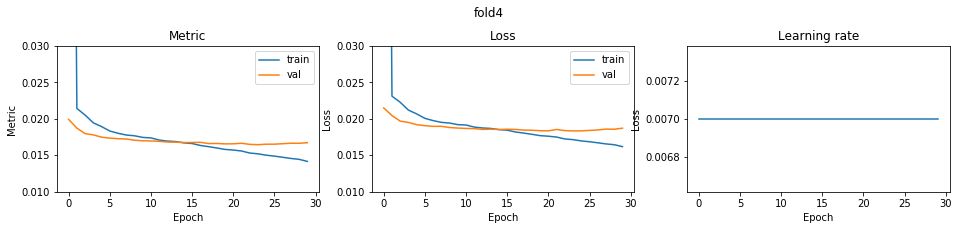

CV score: 0.016469120917622565

optimizer: Ranger
fold 0


epoch1 save best model... 0.02151327611186917
epoch2 save best model... 0.01963745720752415
epoch3 save best model... 0.0185043840904578
epoch4 save best model... 0.017963598551470488
epoch5 save best model... 0.017634143725309123
epoch6 save best model... 0.01728803673865176
epoch7 save best model... 0.017090332958686054
epoch9 save best model... 0.016791372237926462
epoch10 save best model... 0.016671974693503493
epoch11 save best model... 0.016642796739952847
epoch13 save best model... 0.01649086126094527
epoch14 save best model... 0.01646141739888859
epoch15 save best model... 0.016432472720216102
epoch16 save best model... 0.016356675762148543
epoch18 save best model... 0.016323191714992826
epoch19 save best model... 0.016288654417953623
fold0 score: 0.01628865446864535


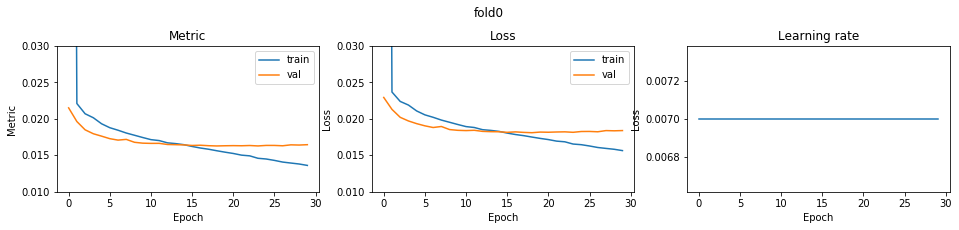

fold 1


epoch1 save best model... 0.021192501914660083
epoch2 save best model... 0.01965827399075004
epoch3 save best model... 0.01870852799296352
epoch4 save best model... 0.018339204101800566
epoch5 save best model... 0.017819915411581778
epoch6 save best model... 0.017507420958877695
epoch7 save best model... 0.017454616629532786
epoch8 save best model... 0.01743205553814039
epoch9 save best model... 0.01718175068338936
epoch10 save best model... 0.0169717754719248
epoch12 save best model... 0.016737069839118934
epoch14 save best model... 0.01670107739285996
epoch16 save best model... 0.016631156767810375
epoch18 save best model... 0.01662565677136685
epoch20 save best model... 0.016587156027692968
fold1 score: 0.016587155922344717


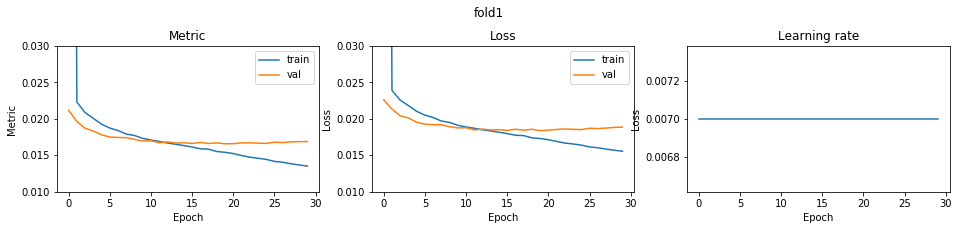

fold 2


epoch1 save best model... 0.0213765499336311
epoch2 save best model... 0.01979082017393448
epoch3 save best model... 0.018578684363173826
epoch4 save best model... 0.018154684967926042
epoch5 save best model... 0.01766811653239176
epoch6 save best model... 0.017298284645187446
epoch7 save best model... 0.01724483035453891
epoch8 save best model... 0.017208940621977257
epoch9 save best model... 0.016916156239513928
epoch10 save best model... 0.016781405554471104
epoch12 save best model... 0.016697932362571735
epoch13 save best model... 0.016641747632112094
epoch14 save best model... 0.016602669673846424
epoch16 save best model... 0.016502908004269998
epoch18 save best model... 0.016494890049186497
epoch20 save best model... 0.016455822049430684
epoch21 save best model... 0.016428609469667413
epoch22 save best model... 0.016398733882388404
fold2 score: 0.016398733801539868


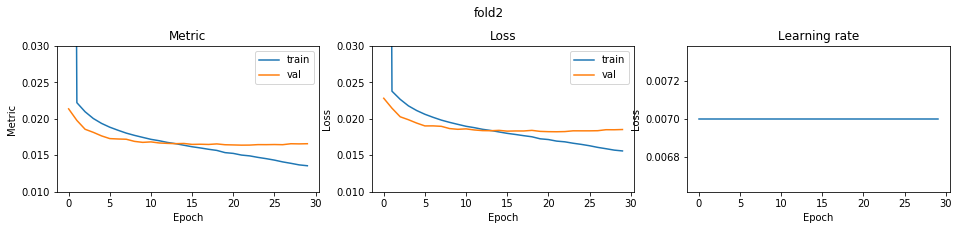

fold 3


epoch1 save best model... 0.021409080036680357
epoch2 save best model... 0.01954600687577879
epoch3 save best model... 0.018632620824225128
epoch4 save best model... 0.018164842332668754
epoch5 save best model... 0.017945326070867667
epoch6 save best model... 0.017638284804677093
epoch7 save best model... 0.01732900121073177
epoch9 save best model... 0.0170548932185579
epoch11 save best model... 0.017054363701212515
epoch12 save best model... 0.01681016589088497
epoch14 save best model... 0.01669712273535533
epoch15 save best model... 0.01668733708127688
epoch18 save best model... 0.016553913717049944
epoch19 save best model... 0.016531299000737472
epoch21 save best model... 0.01650658728414828
epoch24 save best model... 0.016477473431048332
fold3 score: 0.01647747332260883


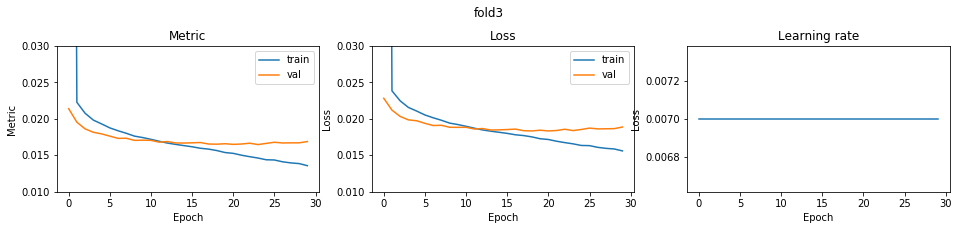

fold 4


epoch1 save best model... 0.020800554082815902
epoch2 save best model... 0.01916444629668375
epoch3 save best model... 0.01828141911358388
epoch4 save best model... 0.017943443833576656
epoch5 save best model... 0.017678758333986605
epoch6 save best model... 0.017448700673810307
epoch7 save best model... 0.01730947793208928
epoch8 save best model... 0.01714291645591582
epoch9 save best model... 0.016998735404146967
epoch10 save best model... 0.016933407010362063
epoch11 save best model... 0.01687312066801113
epoch12 save best model... 0.016704360276443675
epoch15 save best model... 0.016696640951368014
epoch16 save best model... 0.01664132645697352
epoch17 save best model... 0.016527085537875838
epoch19 save best model... 0.0164861233599467
epoch20 save best model... 0.0164715126211965
fold4 score: 0.01647151262929826


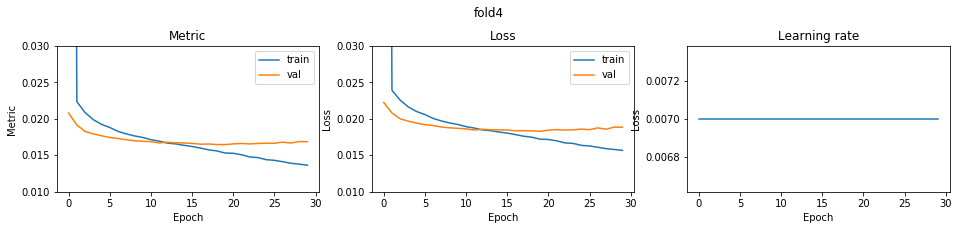

CV score: 0.01644470163314902

optimizer: RangerQH
fold 0


epoch1 save best model... 0.020216503259906194
epoch2 save best model... 0.018826810133925603
epoch3 save best model... 0.017991875824019957
epoch4 save best model... 0.017655224260579208
epoch5 save best model... 0.01737549037657729
epoch6 save best model... 0.01712156043797392
epoch7 save best model... 0.016981520010731214
epoch9 save best model... 0.01672072554164161
epoch10 save best model... 0.016697724744813316
epoch12 save best model... 0.016618207629540922
epoch13 save best model... 0.016605432308650234
epoch15 save best model... 0.01649196543783832
epoch18 save best model... 0.016489730411313117
epoch19 save best model... 0.016477053972270873
epoch20 save best model... 0.016474578100636364
epoch21 save best model... 0.016450985300870174
epoch24 save best model... 0.01640629701290899
epoch27 save best model... 0.016389661921710114
epoch28 save best model... 0.01637032936435354
fold0 score: 0.016370329389376367


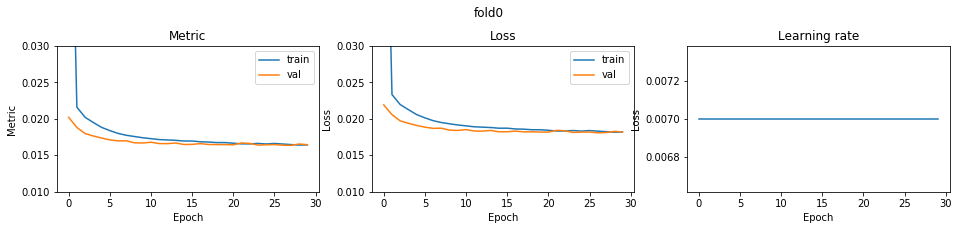

fold 1


epoch1 save best model... 0.0199579531846767
epoch2 save best model... 0.019112337631461803
epoch3 save best model... 0.018192596840304037
epoch4 save best model... 0.017743671448308424
epoch5 save best model... 0.017577647124785285
epoch6 save best model... 0.017375441535451765
epoch7 save best model... 0.017362883520319186
epoch8 save best model... 0.01722351405459782
epoch9 save best model... 0.017054014056870077
epoch10 save best model... 0.01698752368383804
epoch11 save best model... 0.016939724128380143
epoch12 save best model... 0.016877512876805886
epoch17 save best model... 0.016867844892487924
epoch19 save best model... 0.016820739469845098
epoch22 save best model... 0.0168102154422082
epoch24 save best model... 0.01680021724175839
epoch27 save best model... 0.016783230916161313
fold1 score: 0.016783230793477093


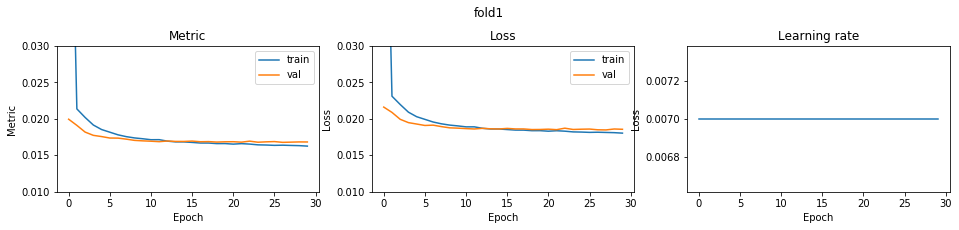

fold 2


epoch1 save best model... 0.020365449334041733
epoch2 save best model... 0.018908753650130117
epoch3 save best model... 0.018022207670995112
epoch4 save best model... 0.017576271699693526
epoch5 save best model... 0.017554946400362665
epoch6 save best model... 0.01711988323137901
epoch7 save best model... 0.017089137141833643
epoch8 save best model... 0.01700615697224385
epoch9 save best model... 0.016806039878982677
epoch10 save best model... 0.016799283050947904
epoch12 save best model... 0.016706431363483282
epoch14 save best model... 0.016705222585293476
epoch15 save best model... 0.01663034408626788
epoch18 save best model... 0.016608363197380956
epoch21 save best model... 0.016567733348235844
epoch22 save best model... 0.016566288347682166
epoch27 save best model... 0.016518687258359307
fold2 score: 0.016518687294581957


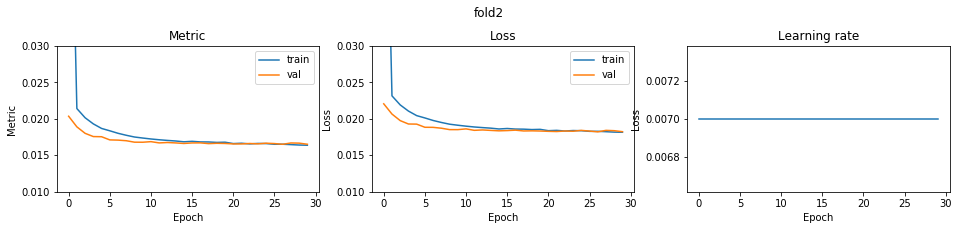

fold 3


epoch1 save best model... 0.020099987894092987
epoch2 save best model... 0.01887183529505154
epoch3 save best model... 0.01811538696127831
epoch4 save best model... 0.01777165194417526
epoch5 save best model... 0.017731520160608385
epoch6 save best model... 0.01731723039867123
epoch7 save best model... 0.017236434076414158
epoch8 save best model... 0.01716660752315456
epoch9 save best model... 0.017019242260834216
epoch10 save best model... 0.016923498668217848
epoch12 save best model... 0.016776655275366165
epoch16 save best model... 0.016765967115403443
epoch18 save best model... 0.016710022990517572
epoch20 save best model... 0.016698030168126956
epoch26 save best model... 0.016695499842337296
epoch27 save best model... 0.016627623927026377
fold3 score: 0.016627623880037353


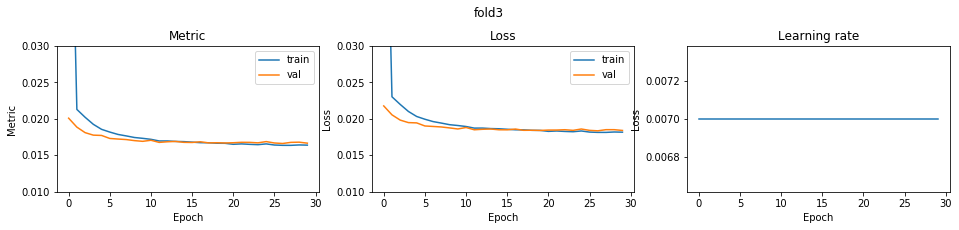

fold 4


epoch1 save best model... 0.01981989337483544
epoch2 save best model... 0.01904852066044791
epoch3 save best model... 0.017938621484320228
epoch4 save best model... 0.0176310603076206
epoch5 save best model... 0.017537158194734188
epoch6 save best model... 0.017330555983973935
epoch7 save best model... 0.017160671776275158
epoch8 save best model... 0.01706252494585066
epoch9 save best model... 0.0168659596358148
epoch12 save best model... 0.01681530703758664
epoch13 save best model... 0.016811418336453363
epoch15 save best model... 0.016767834902132156
epoch18 save best model... 0.016762338413651143
epoch19 save best model... 0.01674933485932869
epoch21 save best model... 0.016746315340976103
epoch22 save best model... 0.016719601090768338
epoch23 save best model... 0.016684274020729955
epoch24 save best model... 0.01665383951785149
fold4 score: 0.01665307353916377


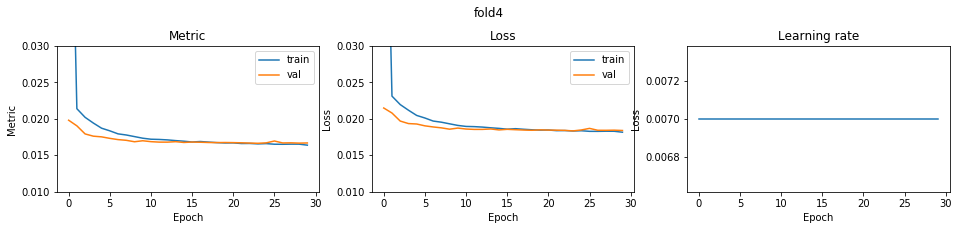

CV score: 0.016590583478136797

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5351057974515581
epoch2 save best model... 0.05886515974828757
epoch3 save best model... 0.02799553391279691
epoch4 save best model... 0.023416355238688562
epoch5 save best model... 0.021902466383773266
epoch6 save best model... 0.021252061050716184
epoch7 save best model... 0.020720527842131724
epoch8 save best model... 0.020355112664825824
epoch9 save best model... 0.020116879314964888
epoch10 save best model... 0.019930994102481014
epoch11 save best model... 0.019746111408894318
epoch12 save best model... 0.019551643881106702
epoch13 save best model... 0.019370715578928895
epoch14 save best model... 0.019226568064107167
epoch15 save best model... 0.019092772798379353
epoch16 save best model... 0.018942106351392145
epoch17 save best model... 0.018809899286386093
epoch18 save best model... 0.018690083118193784
epoch19 save best model... 0.018609835703884824
epoch20 save best model... 0.01848065668466694
epoch21 save best model... 0.01843375513215543
epoch22

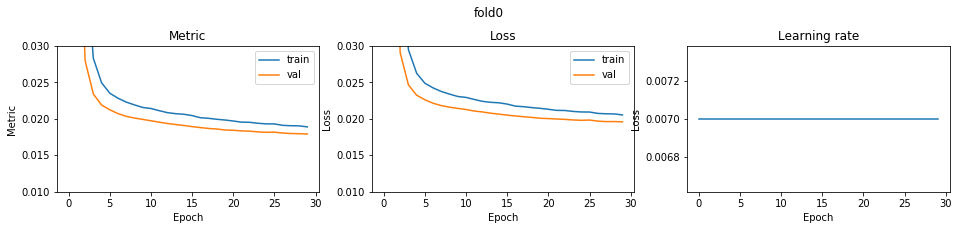

fold 1


epoch1 save best model... 0.5410839644616979
epoch2 save best model... 0.059133750511943195
epoch3 save best model... 0.02802911297583477
epoch4 save best model... 0.0234403178005847
epoch5 save best model... 0.021980279784986574
epoch6 save best model... 0.02130763960875338
epoch7 save best model... 0.020788645195673094
epoch8 save best model... 0.02049312704491246
epoch9 save best model... 0.02027403526339153
epoch10 save best model... 0.02007797730784871
epoch11 save best model... 0.02002622538319846
epoch12 save best model... 0.019692095090361603
epoch13 save best model... 0.019491625365356185
epoch14 save best model... 0.019433282812266667
epoch15 save best model... 0.01929578838131916
epoch16 save best model... 0.01916488907012412
epoch17 save best model... 0.019011516095151604
epoch18 save best model... 0.018897327941821793
epoch19 save best model... 0.018808378860707516
epoch20 save best model... 0.01862950823644308
epoch21 save best model... 0.018629385726677036
epoch22 save b

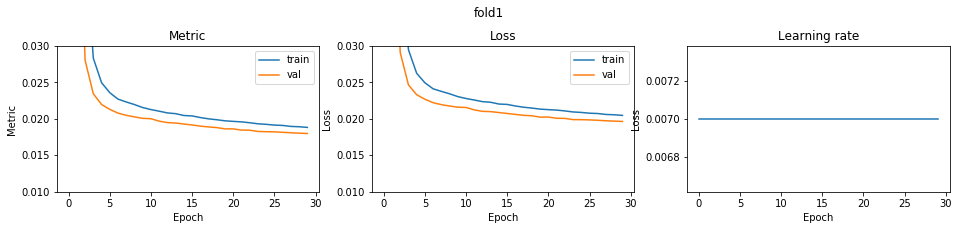

fold 2


epoch1 save best model... 0.5322257395647848
epoch2 save best model... 0.058343736383971445
epoch3 save best model... 0.027645021659192855
epoch4 save best model... 0.023390477611905054
epoch5 save best model... 0.021812627822802397
epoch6 save best model... 0.021207572687752536
epoch7 save best model... 0.020675699466974812
epoch8 save best model... 0.020388081359154382
epoch9 save best model... 0.020162932798402214
epoch10 save best model... 0.019933279570617336
epoch11 save best model... 0.019782377408227934
epoch12 save best model... 0.019627283417464225
epoch13 save best model... 0.01943426210612337
epoch14 save best model... 0.019282483118701888
epoch15 save best model... 0.019122134897527728
epoch16 save best model... 0.019005045072169408
epoch17 save best model... 0.01883850248068347
epoch18 save best model... 0.01877914988502646
epoch19 save best model... 0.018665069524062116
epoch20 save best model... 0.018575296142471897
epoch21 save best model... 0.018407380184819456
epoch2

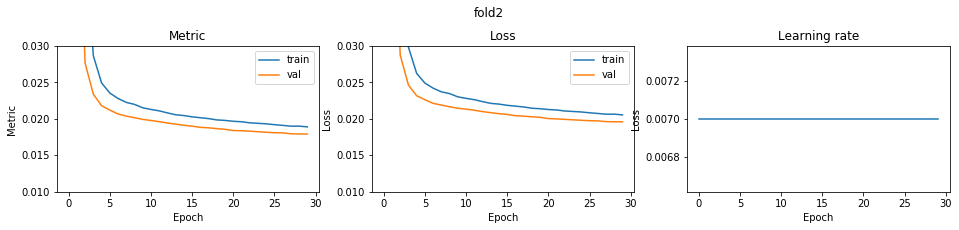

fold 3


epoch1 save best model... 0.5448750358236135
epoch2 save best model... 0.06045227134960931
epoch3 save best model... 0.028559190319991056
epoch4 save best model... 0.02361380868508631
epoch5 save best model... 0.02223788195274821
epoch6 save best model... 0.021437228806231994
epoch7 save best model... 0.021017930236197413
epoch8 save best model... 0.020602667983833506
epoch9 save best model... 0.02043067855009457
epoch10 save best model... 0.02021316175130546
epoch11 save best model... 0.020060829528032512
epoch12 save best model... 0.019805084528286936
epoch13 save best model... 0.01969523276616066
epoch14 save best model... 0.019540372523553416
epoch15 save best model... 0.01934858361526407
epoch16 save best model... 0.01922573485541113
epoch17 save best model... 0.01914056144476548
epoch18 save best model... 0.018981708069003116
epoch19 save best model... 0.018870525697250437
epoch20 save best model... 0.01885465307326686
epoch21 save best model... 0.018708463162523194
epoch22 save 

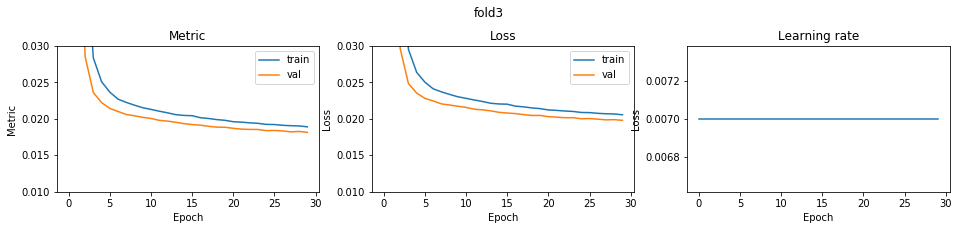

fold 4


epoch1 save best model... 0.5319957133849281
epoch2 save best model... 0.05750637646586314
epoch3 save best model... 0.027337436221862438
epoch4 save best model... 0.023001567645163905
epoch5 save best model... 0.021508800306257736
epoch6 save best model... 0.0207876506030288
epoch7 save best model... 0.02050742520303688
epoch8 save best model... 0.020139341921055508
epoch9 save best model... 0.019878954252817906
epoch10 save best model... 0.019654524363662225
epoch11 save best model... 0.01943224618945415
epoch12 save best model... 0.019345174004283473
epoch13 save best model... 0.019133925716263288
epoch14 save best model... 0.019007945434107595
epoch15 save best model... 0.018898187418190385
epoch16 save best model... 0.018727044805307323
epoch17 save best model... 0.018657433418960125
epoch18 save best model... 0.018566600328357996
epoch19 save best model... 0.018496281298085334
epoch20 save best model... 0.018394961354910377
epoch21 save best model... 0.018347708562681777
epoch22 

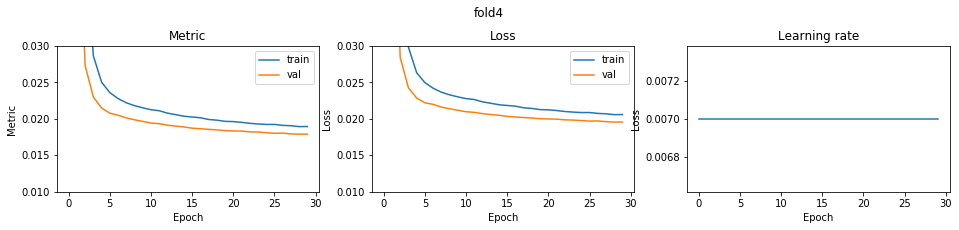

CV score: 0.017985454998788016

optimizer: SWATS
fold 0


epoch1 save best model... 0.02047952175191296
epoch2 save best model... 0.018912082510853953
epoch3 save best model... 0.018127056117888736
epoch4 save best model... 0.017803906330282976
epoch5 save best model... 0.017526608039381022
epoch6 save best model... 0.017177480047649296
epoch7 save best model... 0.01707168781540117
epoch8 save best model... 0.0168189568415386
epoch9 save best model... 0.01679872480689936
epoch10 save best model... 0.016725519268109477
epoch11 save best model... 0.016624061342388186
epoch12 save best model... 0.016441293159215487
epoch14 save best model... 0.01636980292100909
epoch15 save best model... 0.016271777114574212
epoch18 save best model... 0.016255959705502677
epoch20 save best model... 0.016203558475525886
fold0 score: 0.016203558322546073


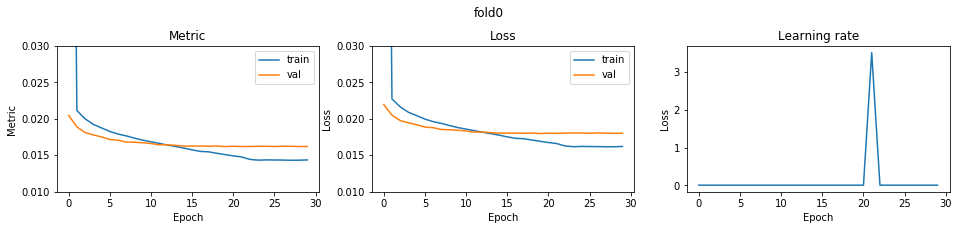

fold 1


epoch1 save best model... 0.020409318255835633
epoch2 save best model... 0.0191425207211267
epoch3 save best model... 0.01854033938866456
epoch4 save best model... 0.01787835420812757
epoch5 save best model... 0.017551707114882582
epoch6 save best model... 0.017441544328695498
epoch7 save best model... 0.01741227906602177
epoch8 save best model... 0.017201590329479943
epoch9 save best model... 0.017089838619556343
epoch10 save best model... 0.016984810181408544
epoch11 save best model... 0.016924786025360752
epoch12 save best model... 0.01681131115626721
epoch13 save best model... 0.016690555675386853
epoch16 save best model... 0.016660553948326925
epoch17 save best model... 0.016630732365237755
epoch18 save best model... 0.0165839642553666
epoch20 save best model... 0.016572606218072692
fold1 score: 0.016572606177874236


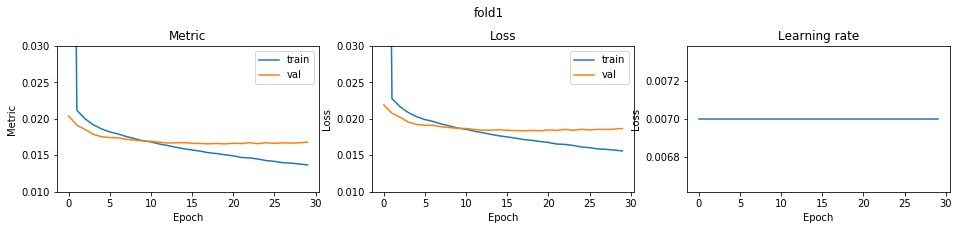

fold 2


epoch1 save best model... 0.020461430050828212
epoch2 save best model... 0.01888586786200243
epoch3 save best model... 0.018166272879779122
epoch4 save best model... 0.017711911800553638
epoch5 save best model... 0.017324877633590325
epoch6 save best model... 0.017216802347009234
epoch7 save best model... 0.017021302382702993
epoch8 save best model... 0.016947603023571328
epoch9 save best model... 0.01676922549864315
epoch10 save best model... 0.016719036224629415
epoch11 save best model... 0.016556030687638175
epoch12 save best model... 0.016549112695812718
epoch13 save best model... 0.016441856327176596
epoch15 save best model... 0.016399243715187157
epoch17 save best model... 0.016339349843507326
epoch19 save best model... 0.016321861664905693
fold2 score: 0.016321861623122463


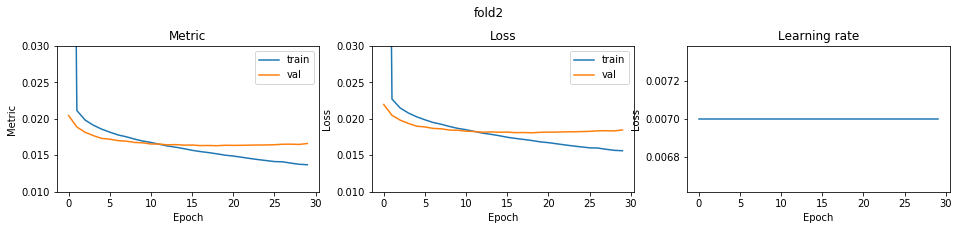

fold 3


epoch1 save best model... 0.020445616362968582
epoch2 save best model... 0.01919378944606879
epoch3 save best model... 0.018485418871757923
epoch4 save best model... 0.017998357364538725
epoch5 save best model... 0.017742753576631562
epoch6 save best model... 0.017490691279648782
epoch7 save best model... 0.01737447109090372
epoch8 save best model... 0.017153677446576757
epoch9 save best model... 0.017040548365401923
epoch10 save best model... 0.01690021088699002
epoch11 save best model... 0.016839552462813795
epoch12 save best model... 0.016797044584718545
epoch13 save best model... 0.016708609598830918
epoch14 save best model... 0.016667290740903118
epoch15 save best model... 0.01656743018911273
epoch17 save best model... 0.016555572419951335
epoch18 save best model... 0.016537586322949525
epoch19 save best model... 0.016484219073858917
fold3 score: 0.016484218968050707


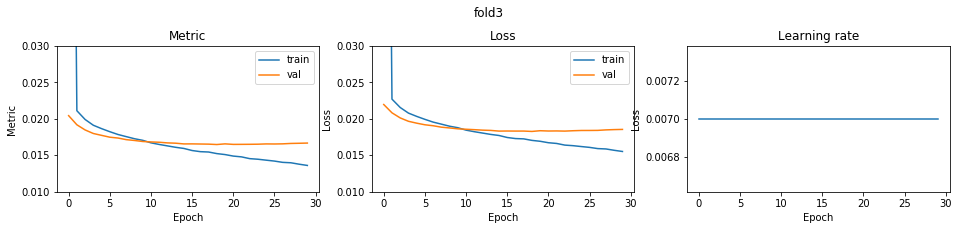

fold 4


epoch1 save best model... 0.02015846303339564
epoch2 save best model... 0.01886587939341818
epoch3 save best model... 0.018170510853613157
epoch4 save best model... 0.017780801237630817
epoch5 save best model... 0.0174943083137749
epoch6 save best model... 0.017344362672274096
epoch7 save best model... 0.017189563611832052
epoch8 save best model... 0.017057181509945687
epoch9 save best model... 0.016909466862067547
epoch11 save best model... 0.016764948416951034
epoch12 save best model... 0.016649776190128984
epoch13 save best model... 0.016617838445635077
epoch14 save best model... 0.01658416006518931
epoch16 save best model... 0.016490351332347324
epoch18 save best model... 0.016446954361534337
fold4 score: 0.016446954312891785


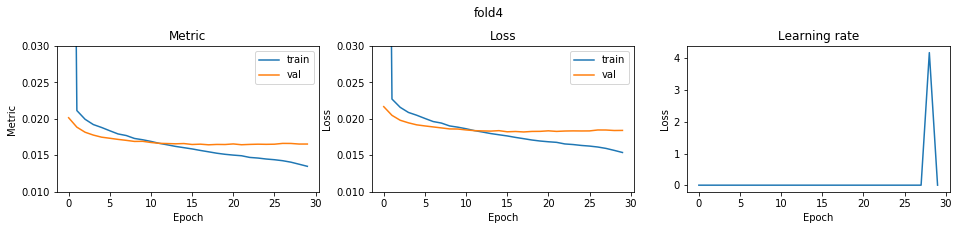

CV score: 0.016405836108888707

optimizer: Yogi
fold 0


epoch1 save best model... 0.02071255784659967
epoch2 save best model... 0.01932397713473147
epoch3 save best model... 0.01854522733743343
epoch4 save best model... 0.018038938796160434
epoch5 save best model... 0.01772807457978606
epoch6 save best model... 0.01756215846603036
epoch7 save best model... 0.01729891072016778
epoch8 save best model... 0.017186042985503386
epoch9 save best model... 0.01702815810120866
epoch10 save best model... 0.016943263001994554
epoch11 save best model... 0.016807779647698435
epoch12 save best model... 0.016693384527039962
epoch13 save best model... 0.01664490487791411
epoch14 save best model... 0.016571356879721198
epoch15 save best model... 0.01643939240918344
epoch16 save best model... 0.016381655140421385
epoch18 save best model... 0.016316829026933412
epoch19 save best model... 0.01628181632514831
epoch20 save best model... 0.016216441833653863
epoch22 save best model... 0.016208671518773317
epoch23 save best model... 0.016189575992134275
epoch24 sav

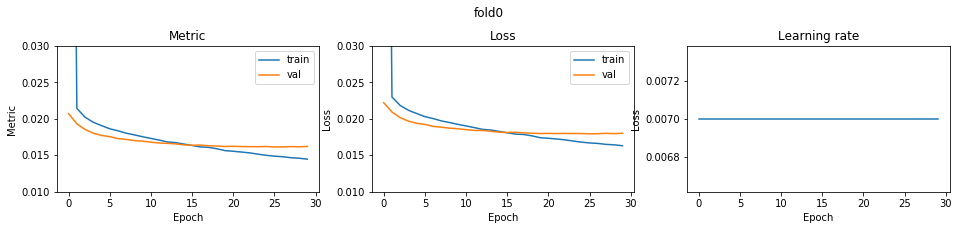

fold 1


epoch1 save best model... 0.020715069880899602
epoch2 save best model... 0.019334098823685992
epoch3 save best model... 0.018525851432952965
epoch4 save best model... 0.018053136637366886
epoch5 save best model... 0.017836235304473202
epoch6 save best model... 0.017583823550427168
epoch7 save best model... 0.017405885625032227
epoch8 save best model... 0.0173598242489467
epoch9 save best model... 0.017255316786153982
epoch10 save best model... 0.01714689310323502
epoch11 save best model... 0.016969510920873725
epoch13 save best model... 0.016888874646180323
epoch14 save best model... 0.016775377064401794
epoch15 save best model... 0.01674268793762002
epoch16 save best model... 0.016732182835204765
epoch17 save best model... 0.016656672638898477
epoch18 save best model... 0.016624580109634114
epoch20 save best model... 0.016623859387124542
epoch21 save best model... 0.016587400262104635
epoch22 save best model... 0.01657213950238988
epoch24 save best model... 0.016541352040605656
epoch2

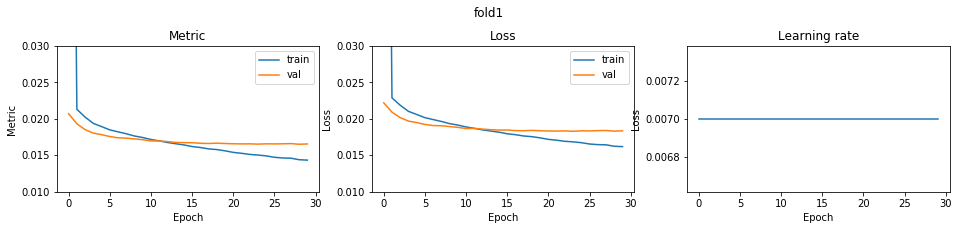

fold 2


epoch1 save best model... 0.020712124929426198
epoch2 save best model... 0.01925886126999453
epoch3 save best model... 0.018508327706220632
epoch4 save best model... 0.017973043426436724
epoch5 save best model... 0.017693897346821887
epoch6 save best model... 0.01747209803127202
epoch7 save best model... 0.017291364106601096
epoch8 save best model... 0.01713672951844178
epoch9 save best model... 0.01697653210043948
epoch10 save best model... 0.01685628449931778
epoch11 save best model... 0.01680246965972824
epoch12 save best model... 0.0167237036800155
epoch13 save best model... 0.0166305056498334
epoch14 save best model... 0.016571741372705062
epoch15 save best model... 0.016530977033068484
epoch16 save best model... 0.016485568687258645
epoch17 save best model... 0.016444548051638794
epoch18 save best model... 0.01640805727799034
epoch19 save best model... 0.01633436322754589
epoch20 save best model... 0.016319764270023865
epoch23 save best model... 0.01630613284440587
epoch26 save b

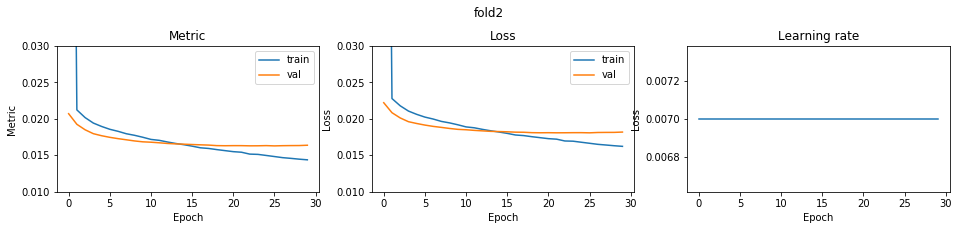

fold 3


epoch1 save best model... 0.020643666219432966
epoch2 save best model... 0.01950015898556332
epoch3 save best model... 0.01873208624491116
epoch4 save best model... 0.018175996217562697
epoch5 save best model... 0.017964195312427225
epoch6 save best model... 0.017666804664057588
epoch7 save best model... 0.01746901036165909
epoch8 save best model... 0.017331700522562908
epoch9 save best model... 0.017233357421951985
epoch10 save best model... 0.017080783902122247
epoch11 save best model... 0.016999155952083903
epoch12 save best model... 0.016922888024402505
epoch14 save best model... 0.016764471728719584
epoch15 save best model... 0.016697492920167763
epoch16 save best model... 0.016662430142504344
epoch18 save best model... 0.016584050628210254
epoch20 save best model... 0.01657676964548495
epoch21 save best model... 0.016498768675418947
epoch22 save best model... 0.016451834917390943
epoch25 save best model... 0.01644569457060995
fold3 score: 0.01644569440861187


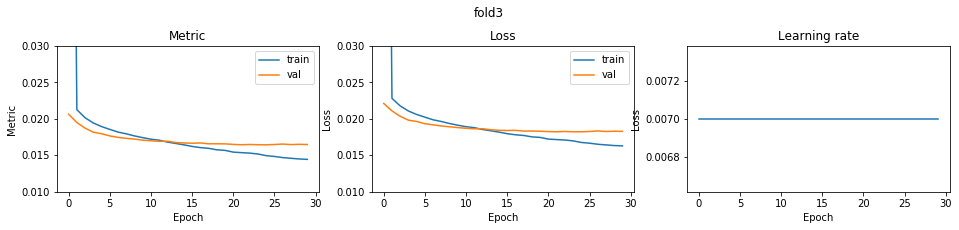

fold 4


epoch1 save best model... 0.020321210113975616
epoch2 save best model... 0.019042274489964876
epoch3 save best model... 0.018315621410286507
epoch4 save best model... 0.017946209924842884
epoch5 save best model... 0.01766479964408353
epoch6 save best model... 0.017448877712928083
epoch7 save best model... 0.01731213006256721
epoch8 save best model... 0.017208950327187438
epoch9 save best model... 0.01708015669816108
epoch10 save best model... 0.017022652083961188
epoch11 save best model... 0.016871437754541432
epoch12 save best model... 0.016812227444048623
epoch13 save best model... 0.016754714345266715
epoch14 save best model... 0.016678240864297932
epoch15 save best model... 0.016671424733733668
epoch16 save best model... 0.01658345715085507
epoch17 save best model... 0.016573387119231706
epoch18 save best model... 0.016556548461284074
epoch19 save best model... 0.016504128937077006
epoch20 save best model... 0.01650331052898478
epoch21 save best model... 0.016437815408092967
epoch2

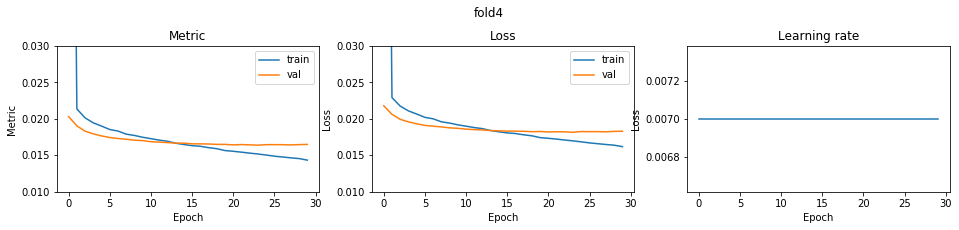

CV score: 0.016363270859293406

optimizer: Adam
fold 0


epoch1 save best model... 0.020014831468734492
epoch2 save best model... 0.018401151778418275
epoch3 save best model... 0.017879194790043428
epoch4 save best model... 0.017603777113088442
epoch5 save best model... 0.01748824231156863
epoch6 save best model... 0.01741815256824662
epoch7 save best model... 0.017343813641705383
epoch9 save best model... 0.017193861206429153
fold0 score: 0.017193861068654514


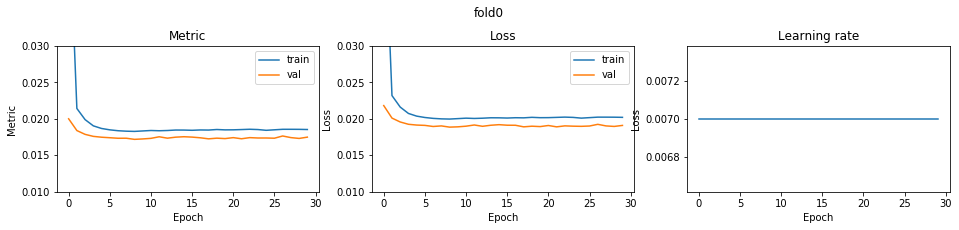

fold 1


epoch1 save best model... 0.019961307303142672
epoch2 save best model... 0.018681480476068702
epoch3 save best model... 0.017903104403681543
epoch4 save best model... 0.017757357842753407
epoch5 save best model... 0.017602445228175126
epoch7 save best model... 0.01749186269815024
epoch9 save best model... 0.017480717225844374
epoch21 save best model... 0.01746471861696075
fold1 score: 0.017464718797266864


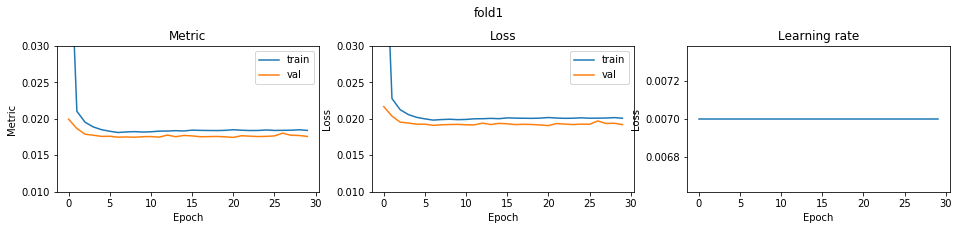

fold 2


epoch1 save best model... 0.02054571612691602
epoch2 save best model... 0.018626920732472827
epoch3 save best model... 0.018019643890393244
epoch4 save best model... 0.01762493552271286
epoch5 save best model... 0.017589135336105902
epoch6 save best model... 0.017367419068047795
epoch8 save best model... 0.01729071594237446
fold2 score: 0.017290715866942245


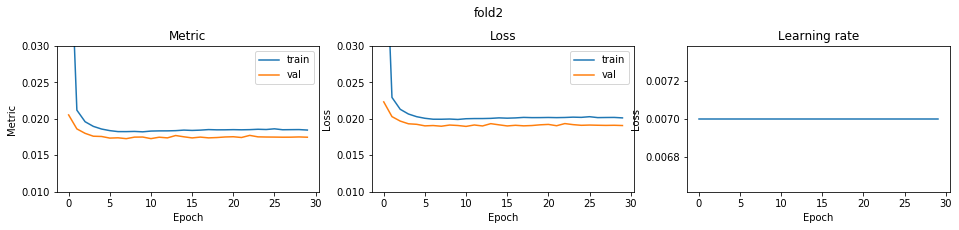

fold 3


epoch1 save best model... 0.02027473168316083
epoch2 save best model... 0.019017935262522014
epoch3 save best model... 0.018312622104815986
epoch4 save best model... 0.017937860455881628
epoch5 save best model... 0.0178563186754568
epoch6 save best model... 0.01757652986972913
epoch11 save best model... 0.01749269053475732
epoch12 save best model... 0.01748616747973924
fold3 score: 0.017486167549264263


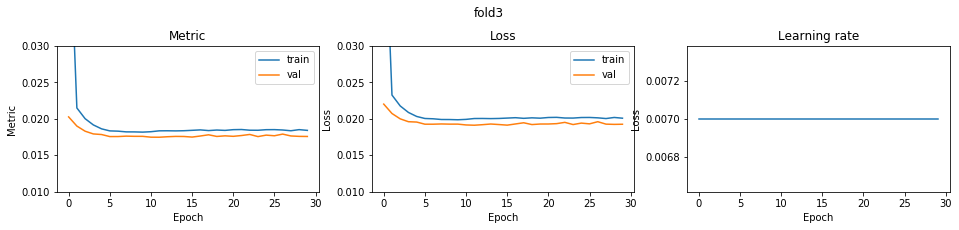

fold 4


epoch1 save best model... 0.01956353678976892
epoch2 save best model... 0.018453300775692783
epoch3 save best model... 0.0177782253648636
epoch4 save best model... 0.017563417167795276
epoch5 save best model... 0.017463180666751225
epoch6 save best model... 0.01743195612908496
epoch8 save best model... 0.017239890542466847
epoch12 save best model... 0.017208126546700477
fold4 score: 0.01720812660428756


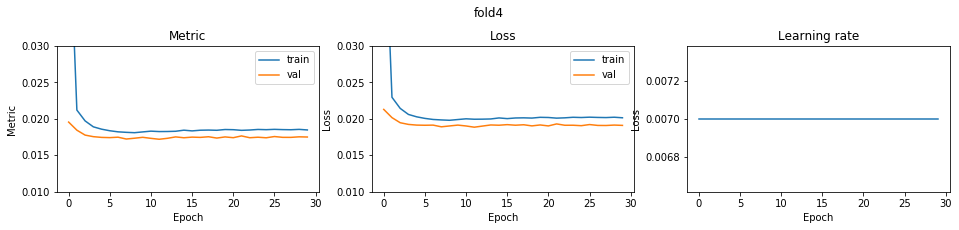

CV score: 0.017328713512242553

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.0200355836998561
epoch2 save best model... 0.01872089030666612
epoch3 save best model... 0.018013850793853436
epoch4 save best model... 0.01755114142997254
epoch5 save best model... 0.017329875062429823
epoch6 save best model... 0.017127999918777198
epoch7 save best model... 0.016957104458115095
epoch8 save best model... 0.016951124292876835
epoch9 save best model... 0.0169109886881295
epoch10 save best model... 0.016766524093399557
epoch12 save best model... 0.016695049849756758
epoch14 save best model... 0.01667718922036248
epoch15 save best model... 0.016584803836084988
epoch18 save best model... 0.016494604350748666
epoch21 save best model... 0.0164817681854298
epoch25 save best model... 0.01647128081903846
epoch30 save best model... 0.016463077552022587
fold0 score: 0.01646307745800949


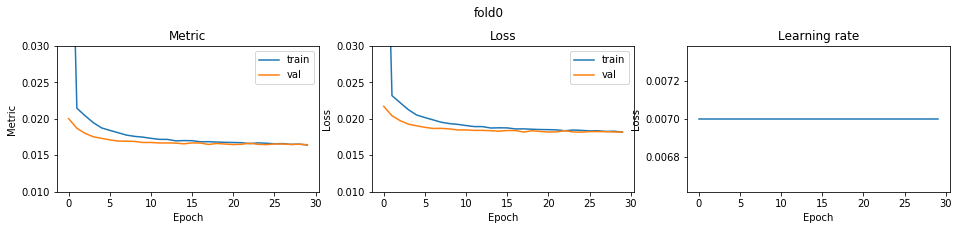

fold 1


epoch1 save best model... 0.020445671008921452
epoch2 save best model... 0.019158065862704122
epoch3 save best model... 0.01820064599777061
epoch4 save best model... 0.01795615728729799
epoch5 save best model... 0.01765286785843881
epoch6 save best model... 0.017483024683726433
epoch7 save best model... 0.0172276580135435
epoch8 save best model... 0.017184470360684868
epoch9 save best model... 0.017060326922860605
epoch10 save best model... 0.017023199161917385
epoch11 save best model... 0.01700585280343683
epoch12 save best model... 0.016955846156284135
epoch13 save best model... 0.016852610130656632
epoch15 save best model... 0.016825938100785892
epoch19 save best model... 0.01674865435946399
fold1 score: 0.016748654241116212


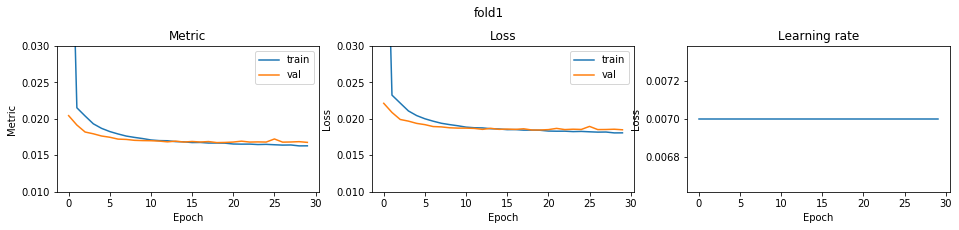

fold 2


epoch1 save best model... 0.020000269087776287
epoch2 save best model... 0.019276990980464998
epoch3 save best model... 0.0182770448515103
epoch4 save best model... 0.01777698066150084
epoch5 save best model... 0.017456529250143127
epoch6 save best model... 0.017213493081199727
epoch7 save best model... 0.017091480659023453
epoch8 save best model... 0.016979380733976267
epoch9 save best model... 0.016906502769314012
epoch11 save best model... 0.016846859680374544
epoch12 save best model... 0.016767562562453365
epoch13 save best model... 0.016758760477261953
epoch16 save best model... 0.016679683541482252
epoch19 save best model... 0.01661549941512488
epoch21 save best model... 0.016594286856327887
fold2 score: 0.016594286822820235


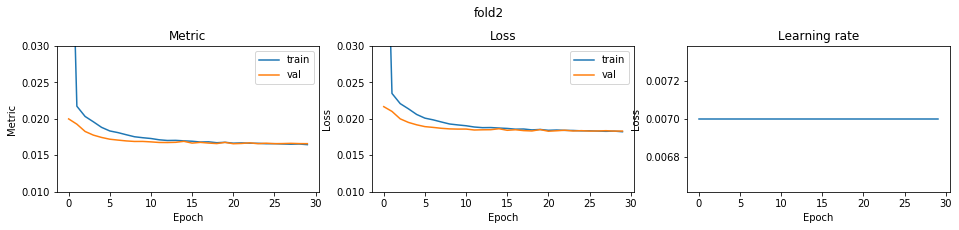

fold 3


epoch1 save best model... 0.020470394491555344
epoch2 save best model... 0.019088792044389357
epoch3 save best model... 0.01836687999147421
epoch4 save best model... 0.017789391433323705
epoch5 save best model... 0.017637625152928275
epoch6 save best model... 0.017492355116068094
epoch7 save best model... 0.017380370009172887
epoch8 save best model... 0.017326281728872135
epoch9 save best model... 0.017123859779217657
epoch10 save best model... 0.017048087196343986
epoch12 save best model... 0.017002648845365894
epoch13 save best model... 0.016994260086472188
epoch14 save best model... 0.016880398931019943
epoch15 save best model... 0.016777267094896704
epoch19 save best model... 0.01675491355792333
epoch24 save best model... 0.016721797206678803
epoch30 save best model... 0.016699925060373367
fold3 score: 0.01669992503926049


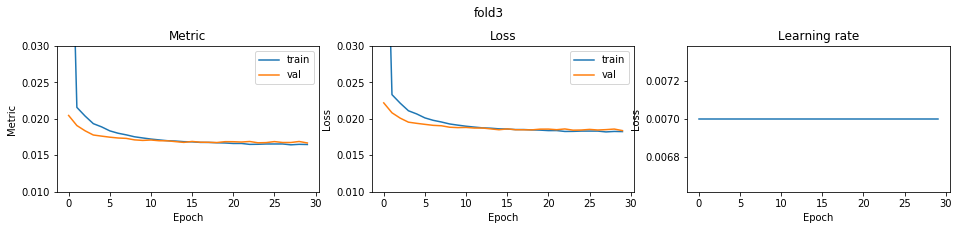

fold 4


epoch1 save best model... 0.020007941213379146
epoch2 save best model... 0.018895531432164287
epoch3 save best model... 0.01796057818877534
epoch4 save best model... 0.017724741552797293
epoch5 save best model... 0.01752449409412496
epoch6 save best model... 0.01724550678587788
epoch7 save best model... 0.017070970669015393
epoch8 save best model... 0.01702416723335251
epoch9 save best model... 0.0169048944182677
epoch10 save best model... 0.016886345393412612
epoch12 save best model... 0.01681705158509331
epoch13 save best model... 0.016774607728530306
epoch14 save best model... 0.016742049965472863
epoch18 save best model... 0.01670220437881819
epoch21 save best model... 0.016696099596255055
epoch24 save best model... 0.0166733762105091
fold4 score: 0.016673376083791214


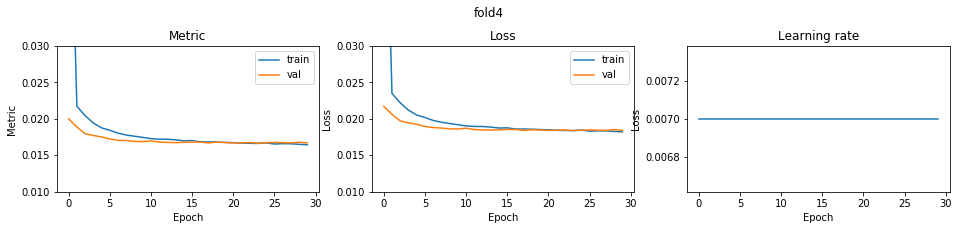

CV score: 0.016635860684366493

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.020734610712338147
epoch2 save best model... 0.019335730327187203
epoch3 save best model... 0.01847550370444062
epoch4 save best model... 0.017960561679544643
epoch5 save best model... 0.01766470967620136
epoch6 save best model... 0.017337613083540985
epoch7 save best model... 0.017215222673562774
epoch8 save best model... 0.017079348253735378
epoch9 save best model... 0.016848163626629834
epoch10 save best model... 0.01674942771028006
epoch11 save best model... 0.016648964369605914
epoch12 save best model... 0.01653412032897896
epoch13 save best model... 0.01649732066653584
epoch14 save best model... 0.016477498151616518
epoch15 save best model... 0.016421021449385988
epoch16 save best model... 0.016393804856934552
epoch17 save best model... 0.016364735931769046
epoch19 save best model... 0.016328754648141954
fold0 score: 0.016328754480238687


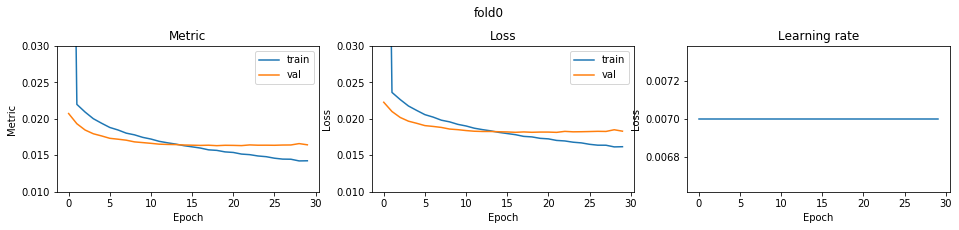

fold 1


epoch1 save best model... 0.020984581199097564
epoch2 save best model... 0.01957268212147619
epoch3 save best model... 0.018911799687130845
epoch4 save best model... 0.018336788453900153
epoch5 save best model... 0.017994583589673097
epoch6 save best model... 0.017565052244217255
epoch7 save best model... 0.01744002607258707
epoch8 save best model... 0.01738965431536811
epoch9 save best model... 0.017146654455061246
epoch10 save best model... 0.017077266847840826
epoch11 save best model... 0.016858936592386506
epoch12 save best model... 0.01677373908103653
epoch13 save best model... 0.01675530402174427
epoch16 save best model... 0.016679452774432137
epoch20 save best model... 0.01666518075017763
fold1 score: 0.016665180838453007


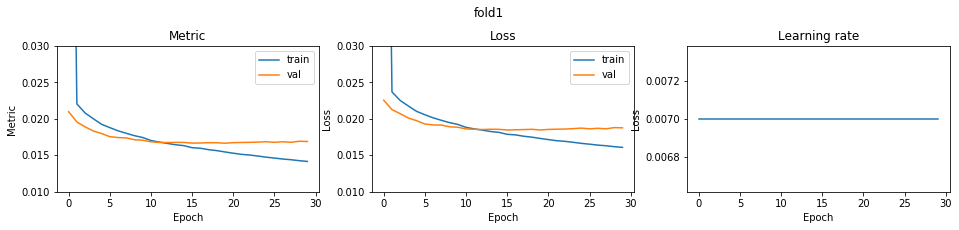

fold 2


epoch1 save best model... 0.02063120086926701
epoch2 save best model... 0.019702328804232762
epoch3 save best model... 0.018481828761451484
epoch4 save best model... 0.018131644602107023
epoch5 save best model... 0.017706089961393653
epoch6 save best model... 0.01738616662203084
epoch7 save best model... 0.017178601362099744
epoch8 save best model... 0.01708115522398964
epoch9 save best model... 0.01676151942012725
epoch10 save best model... 0.016750842141228146
epoch11 save best model... 0.01674874758805785
epoch12 save best model... 0.016619197065152837
epoch13 save best model... 0.01651956241193367
epoch16 save best model... 0.0164637188075968
epoch19 save best model... 0.016392020897599866
fold2 score: 0.016392020766729472


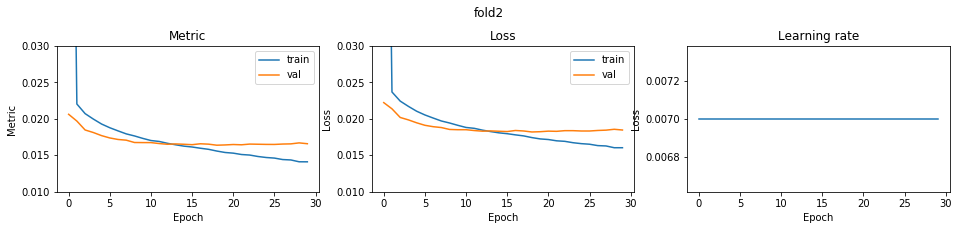

fold 3


epoch1 save best model... 0.020773528521808377
epoch2 save best model... 0.01959083022630364
epoch3 save best model... 0.019093446833652217
epoch4 save best model... 0.018171718591455038
epoch5 save best model... 0.017798126154581345
epoch6 save best model... 0.017588411566879864
epoch7 save best model... 0.017317836222945287
epoch8 save best model... 0.017199627408897824
epoch9 save best model... 0.01711494857466574
epoch10 save best model... 0.016930417919739368
epoch12 save best model... 0.01676833310030859
epoch13 save best model... 0.016717725017602325
epoch14 save best model... 0.016686533476334225
epoch15 save best model... 0.01660287602081182
epoch16 save best model... 0.016581634866128885
epoch19 save best model... 0.016560790484138936
fold3 score: 0.01656079034981435


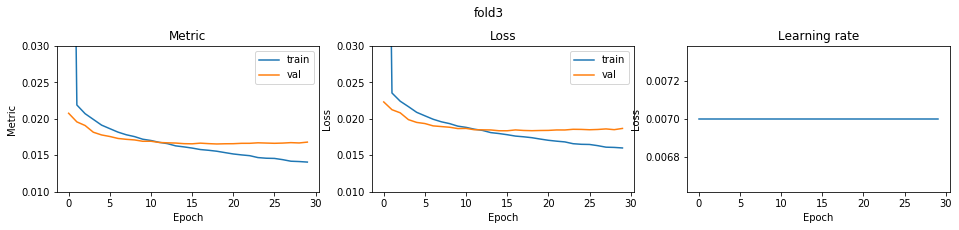

fold 4


epoch1 save best model... 0.020386206556391607
epoch2 save best model... 0.019345317661320974
epoch3 save best model... 0.018443819517290946
epoch4 save best model... 0.017997594048737936
epoch5 save best model... 0.017599408005646393
epoch6 save best model... 0.017369447945105868
epoch7 save best model... 0.017204086223282004
epoch8 save best model... 0.017143913560413282
epoch9 save best model... 0.016962964436917614
epoch10 save best model... 0.016888091480253362
epoch11 save best model... 0.016810852152153274
epoch12 save best model... 0.016769319983593833
epoch13 save best model... 0.016686309930488703
epoch14 save best model... 0.016613121512759656
epoch16 save best model... 0.016588093399797867
epoch18 save best model... 0.016521824972284004
fold4 score: 0.016521824910797293


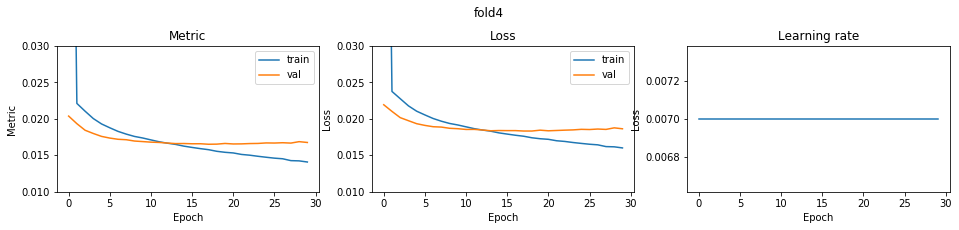

CV score: 0.016493711090189486

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.02217877148088399
epoch2 save best model... 0.020338701279430833
epoch3 save best model... 0.01945216814586405
epoch4 save best model... 0.018860233542859418
epoch5 save best model... 0.018440663823879117
epoch6 save best model... 0.01812156463266777
epoch7 save best model... 0.017882857273984063
epoch8 save best model... 0.017766133228270233
epoch9 save best model... 0.017574307630538667
epoch10 save best model... 0.01741199735424785
epoch11 save best model... 0.017306180569875755
epoch12 save best model... 0.01720626122723408
epoch13 save best model... 0.017141587518851416
epoch14 save best model... 0.0169883931933951
epoch16 save best model... 0.016906296573833888
epoch17 save best model... 0.0168367393747617
epoch18 save best model... 0.016783120282045257
epoch19 save best model... 0.016677723858921294
epoch21 save best model... 0.016633423328705148
epoch22 save best model... 0.016531915534160405
epoch23 save best model... 0.01649475203814295
epoch24 sav

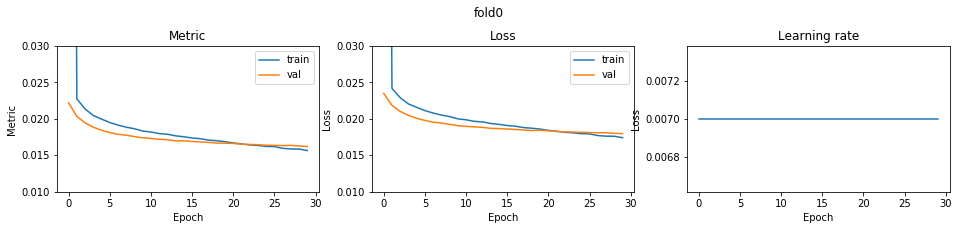

fold 1


epoch1 save best model... 0.02200192364905005
epoch2 save best model... 0.020206705742407616
epoch3 save best model... 0.01936649401135544
epoch4 save best model... 0.01883158380516666
epoch5 save best model... 0.018482567256541044
epoch6 save best model... 0.01815908934303964
epoch7 save best model... 0.017974326874671206
epoch8 save best model... 0.017781504253543003
epoch9 save best model... 0.017675787559736967
epoch10 save best model... 0.01754689815596992
epoch11 save best model... 0.017394503395207435
epoch12 save best model... 0.0173755347890846
epoch13 save best model... 0.017330948085163198
epoch14 save best model... 0.017207041018663494
epoch15 save best model... 0.01712041044780485
epoch16 save best model... 0.017039129076371517
epoch18 save best model... 0.01692947244373914
epoch19 save best model... 0.0169229554044247
epoch20 save best model... 0.01687531507351005
epoch22 save best model... 0.016814012987775556
epoch23 save best model... 0.01679847406180553
epoch24 save b

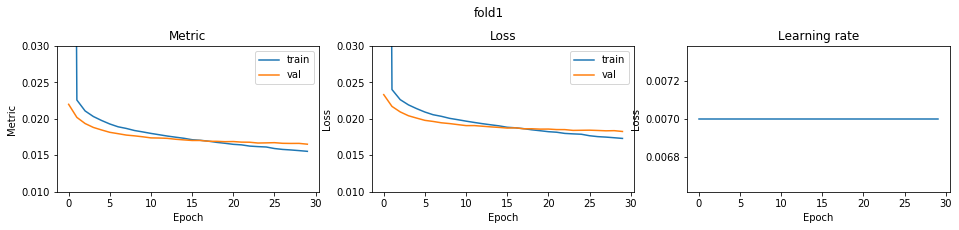

fold 2


epoch1 save best model... 0.021980512306674735
epoch2 save best model... 0.020220688336475154
epoch3 save best model... 0.019445872904448908
epoch4 save best model... 0.018752820414865947
epoch5 save best model... 0.01836898283980741
epoch6 save best model... 0.01811101104436906
epoch7 save best model... 0.01786997615056073
epoch8 save best model... 0.017740507440598657
epoch9 save best model... 0.017555591799267863
epoch10 save best model... 0.017456312115542043
epoch11 save best model... 0.01725554050727881
epoch12 save best model... 0.017218995863547575
epoch13 save best model... 0.017118978217977494
epoch14 save best model... 0.017015140035967807
epoch15 save best model... 0.016959066053109335
epoch16 save best model... 0.016886382911623365
epoch17 save best model... 0.016837973633556574
epoch18 save best model... 0.01675344935999655
epoch19 save best model... 0.016748395558097796
epoch20 save best model... 0.0167030663747068
epoch21 save best model... 0.01670129916179347
epoch22 s

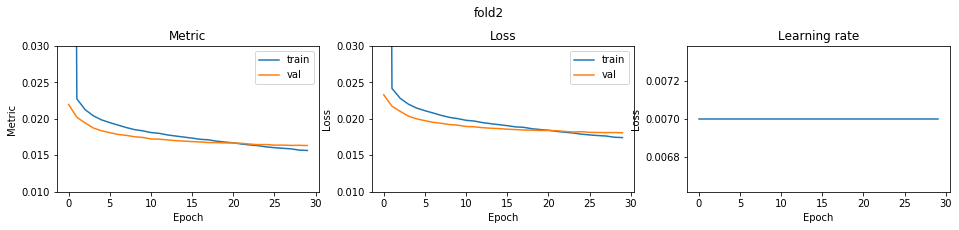

fold 3


epoch1 save best model... 0.02203834177268529
epoch2 save best model... 0.020240196227127843
epoch3 save best model... 0.019476362957209687
epoch4 save best model... 0.018938837397275046
epoch5 save best model... 0.01852636477593884
epoch6 save best model... 0.018208350716816403
epoch7 save best model... 0.01806534027769856
epoch8 save best model... 0.017850237436473775
epoch9 save best model... 0.01766474948971106
epoch10 save best model... 0.01763047583460604
epoch11 save best model... 0.01755054381830885
epoch12 save best model... 0.017420481632469998
epoch13 save best model... 0.01734231293948202
epoch14 save best model... 0.01726885850844663
epoch15 save best model... 0.017194767971363996
epoch16 save best model... 0.017108068282976917
epoch17 save best model... 0.01699962994902647
epoch19 save best model... 0.016946892439894768
epoch20 save best model... 0.016942728407137893
epoch21 save best model... 0.01681969057267918
epoch22 save best model... 0.016813868462428418
epoch23 sav

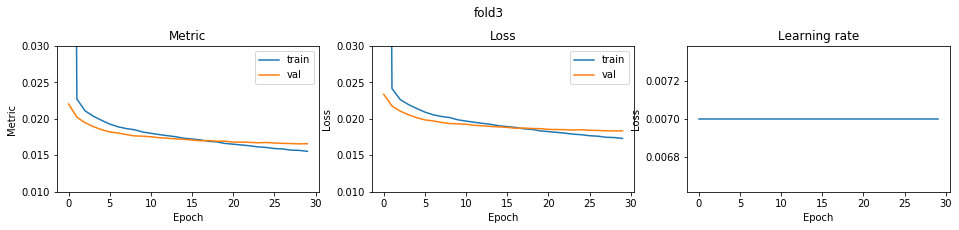

fold 4


epoch1 save best model... 0.022004489057563702
epoch2 save best model... 0.020007043411628532
epoch3 save best model... 0.019237014019102334
epoch4 save best model... 0.01861082811782599
epoch5 save best model... 0.018302602975168912
epoch6 save best model... 0.018007746724950698
epoch7 save best model... 0.017807406426358603
epoch8 save best model... 0.01773911938240968
epoch9 save best model... 0.017561004336728185
epoch10 save best model... 0.017415906745168235
epoch11 save best model... 0.017342092202030174
epoch12 save best model... 0.017241800873877656
epoch13 save best model... 0.017223692950548642
epoch14 save best model... 0.01709379786137568
epoch15 save best model... 0.017039592023132738
epoch16 save best model... 0.01696242078425944
epoch17 save best model... 0.01692254674962482
epoch18 save best model... 0.016878942437979112
epoch19 save best model... 0.01679912046412672
epoch20 save best model... 0.016790707429323624
epoch21 save best model... 0.016786808790405682
epoch22

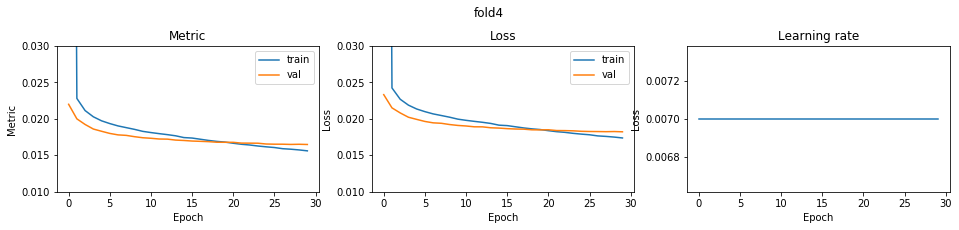

CV score: 0.016431822935369062


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'AggMo': 0.01801755562768027,
 'Apollo': 0.13689226317013786,
 'PID': 0.136080639279654,
 'QHM': 0.13933325898791465,
 'SGDP': 0.1365583274961922,
 'SGDW': 0.14176966434648114,
 'SGD': 0.13611751974435948,
 'AdaBelief': 0.016494313854572642,
 'AdaBound': 0.020099573496562093,
 'AdaMod': 0.016507832216526346,
 'AdamW': 0.01649353190554002,
 'AdamP': 0.016460568796314457,
 'DiffGrad': 0.016656351462724973,
 'Lamb': 0.01649304757987833,
 'NovoGrad': 0.016383041332551335,
 'PlainRAdam': 0.01647402249240629,
 'QHAdam': 0.01728649068288133,
 'RAdam': 0.016469120917622516,
 'Ranger': 0.01644470163314904,
 'RangerQH': 0.016590583478136755,
 'RangerVA': 0.017985454998787884,
 'SWATS': 0.016405836108888728,
 'Yogi': 0.016363270859293375,
 'Adam': 0.017328713512242466,
 'LookaheadAdam': 0.016635860684366566,
 'LookaheadDiffGrad': 0.01649371109018943,
 'LookaheadYogi': 0.016431822935369166}

In [27]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
AggMo              0.018018
Apollo             0.136892
PID                0.136081
QHM                0.139333
SGDP               0.136558
SGDW               0.141770
SGD                0.136118
AdaBelief          0.016494
AdaBound           0.020100
AdaMod             0.016508
AdamW              0.016494
AdamP              0.016461
DiffGrad           0.016656
Lamb               0.016493
NovoGrad           0.016383
PlainRAdam         0.016474
QHAdam             0.017286
RAdam              0.016469
Ranger             0.016445
RangerQH           0.016591
RangerVA           0.017985
SWATS              0.016406
Yogi               0.016363
Adam               0.017329
LookaheadAdam      0.016636
LookaheadDiffGrad  0.016494
LookaheadYogi      0.016432

In [28]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
AggMo              0.018018
Apollo             0.136892
PID                0.136081
QHM                0.139333
SGDP               0.136558
SGDW               0.141770
SGD                0.136118
AdaBelief          0.016494
AdaBound           0.020100
AdaMod             0.016508
AdamW              0.016494
AdamP              0.016461
DiffGrad           0.016656
Lamb               0.016493
NovoGrad           0.016383
PlainRAdam         0.016474
QHAdam             0.017286
RAdam              0.016469
Ranger             0.016445
RangerQH           0.016591
RangerVA           0.017985
SWATS              0.016406
Yogi               0.016363
Adam               0.017329
LookaheadAdam      0.016636
LookaheadDiffGrad  0.016494
LookaheadYogi      0.016432


In [29]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [30]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
Yogi               0.016363
NovoGrad           0.016383
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdaMod             0.016508
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770

In [31]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
Yogi               0.016363
NovoGrad           0.016383
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdaMod             0.016508
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770



optimizer: RangerLars
fold 0


epoch1 save best model... 0.02164136506107918
epoch2 save best model... 0.019624089309627484
epoch3 save best model... 0.018644656997029763
epoch4 save best model... 0.017960607882478784
epoch5 save best model... 0.01771080533046793
epoch6 save best model... 0.01734845111218699
epoch7 save best model... 0.017152856617894424
epoch8 save best model... 0.016999693560267634
epoch9 save best model... 0.016726200952956235
epoch10 save best model... 0.016599120317633713
epoch11 save best model... 0.01653174451490809
epoch12 save best model... 0.016378073587776047
epoch13 save best model... 0.01637294548765198
epoch14 save best model... 0.016320857026769116
epoch15 save best model... 0.01622654504793991
epoch21 save best model... 0.016221763696394234
fold0 score: 0.016221763551358112


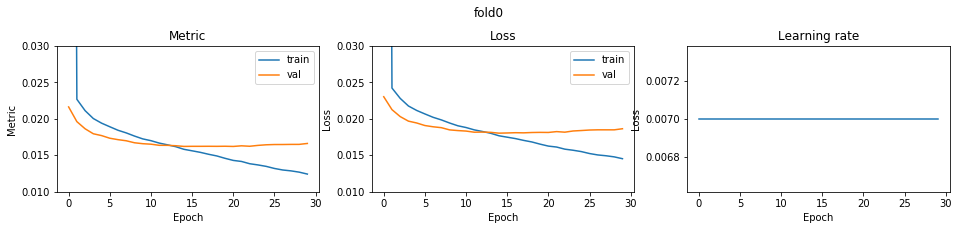

fold 1


epoch1 save best model... 0.022489331452582115
epoch2 save best model... 0.019910897936109232
epoch3 save best model... 0.018945739528354818
epoch4 save best model... 0.018435075160181315
epoch5 save best model... 0.01800818258790797
epoch6 save best model... 0.017590943305469044
epoch7 save best model... 0.017345004712479087
epoch8 save best model... 0.01731999510571133
epoch9 save best model... 0.017088342680814165
epoch10 save best model... 0.016943769724256603
epoch11 save best model... 0.01679489556547211
epoch12 save best model... 0.016735581338862254
epoch13 save best model... 0.016659752279265402
epoch14 save best model... 0.016615468355548845
epoch15 save best model... 0.01655836886919205
epoch18 save best model... 0.016514739476816545
fold1 score: 0.01651473934317031


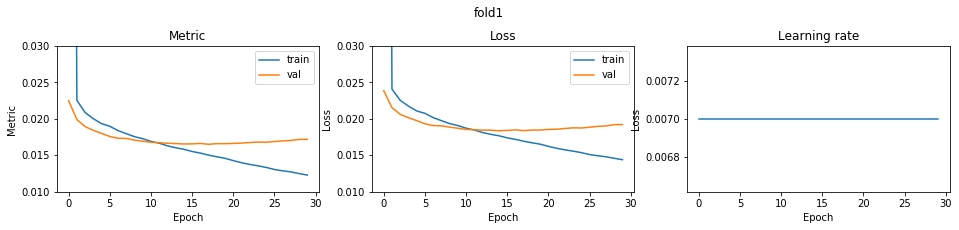

fold 2


epoch1 save best model... 0.021651721561374685
epoch2 save best model... 0.01982752745239012
epoch3 save best model... 0.018630617166625105
epoch4 save best model... 0.0181359504138396
epoch5 save best model... 0.017722614810395266
epoch6 save best model... 0.01734537654996638
epoch7 save best model... 0.01715485567125577
epoch8 save best model... 0.017125237102907403
epoch9 save best model... 0.01686645934422322
epoch10 save best model... 0.01674070911332167
epoch11 save best model... 0.016562344543517016
epoch12 save best model... 0.016507798633742955
epoch14 save best model... 0.016457854886406657
epoch15 save best model... 0.016389352213239092
epoch16 save best model... 0.016364352277669556
fold2 score: 0.016364352154700362


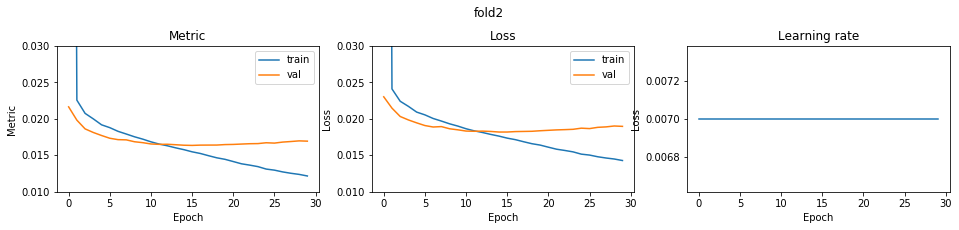

fold 3


epoch1 save best model... 0.02172989216898324
epoch2 save best model... 0.01981528092659416
epoch3 save best model... 0.018774357031190722
epoch4 save best model... 0.01831276278840993
epoch5 save best model... 0.018015487368615316
epoch6 save best model... 0.01768341766445471
epoch7 save best model... 0.017445828144890436
epoch8 save best model... 0.017295934602295754
epoch9 save best model... 0.0170741911540508
epoch10 save best model... 0.016951023524622848
epoch11 save best model... 0.016876293285611958
epoch12 save best model... 0.01676655186038965
epoch13 save best model... 0.016721106993972168
epoch14 save best model... 0.01662602803939296
epoch16 save best model... 0.016554521655574746
epoch17 save best model... 0.016551542787861445
epoch18 save best model... 0.01648707295808271
fold3 score: 0.016487072975444245


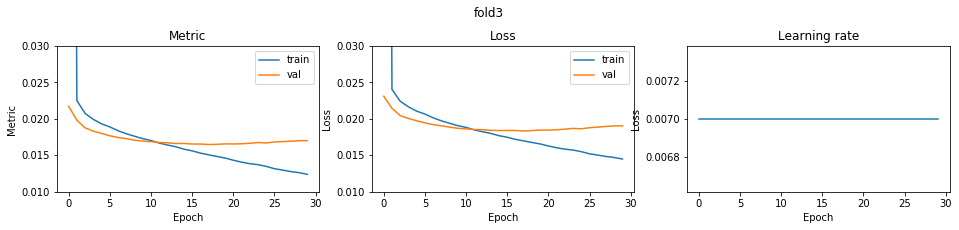

fold 4


epoch1 save best model... 0.021499935242268925
epoch2 save best model... 0.019301854449924685
epoch3 save best model... 0.018426351182179734
epoch4 save best model... 0.01786672266195942
epoch5 save best model... 0.017642217774818184
epoch6 save best model... 0.017374605920106378
epoch7 save best model... 0.01719037288914441
epoch8 save best model... 0.017054267731285176
epoch9 save best model... 0.016884150943699758
epoch10 save best model... 0.016774777266576647
epoch11 save best model... 0.01670417776310091
epoch12 save best model... 0.016579758277022894
epoch13 save best model... 0.01656493930557662
epoch14 save best model... 0.01653107639300321
epoch15 save best model... 0.016439330257085025
epoch19 save best model... 0.01641906501432554
fold4 score: 0.016419064841072046


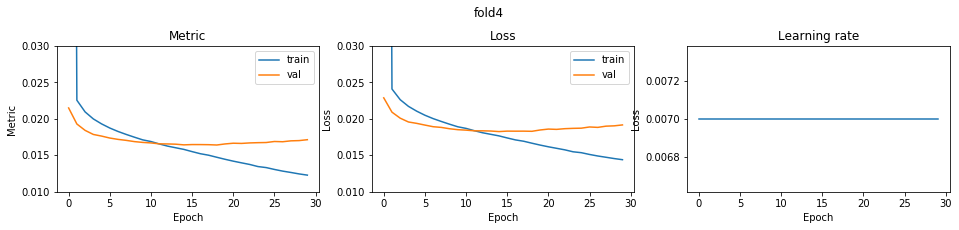

CV score: 0.01640139509700761


In [33]:
optimizer = RangerLars
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score

In [34]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdaMod             0.016508
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770


metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdaMod             0.016508
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.019561554460122265
epoch2 save best model... 0.018421412190604863
epoch3 save best model... 0.01781173760754508
epoch4 save best model... 0.017519156532977326
epoch5 save best model... 0.017453911629821555
epoch6 save best model... 0.01731584571420739
epoch7 save best model... 0.017293696137726442
epoch8 save best model... 0.017191725480529333
fold0 score: 0.017191725379471605


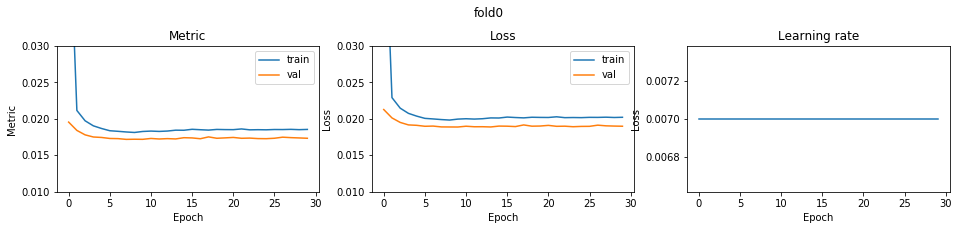

fold 1


epoch1 save best model... 0.019902352621368462
epoch2 save best model... 0.01859019204208576
epoch3 save best model... 0.017940179638795455
epoch4 save best model... 0.01775308045365322
epoch5 save best model... 0.017710539585543427
epoch7 save best model... 0.017499461794247877
epoch11 save best model... 0.017479591133566535
epoch26 save best model... 0.017463437616604422
fold1 score: 0.017463437556961423


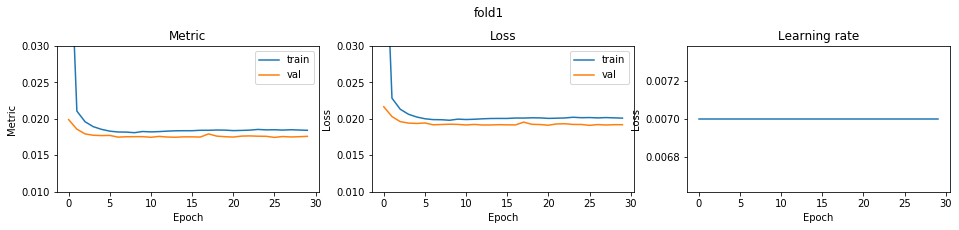

fold 2


epoch1 save best model... 0.01990478852961962
epoch2 save best model... 0.018682665654811834
epoch3 save best model... 0.017822457185682646
epoch4 save best model... 0.017685216881664106
epoch5 save best model... 0.017532975279010356
epoch6 save best model... 0.017346117727621443
epoch9 save best model... 0.017255102174547978
fold2 score: 0.01725510224675544


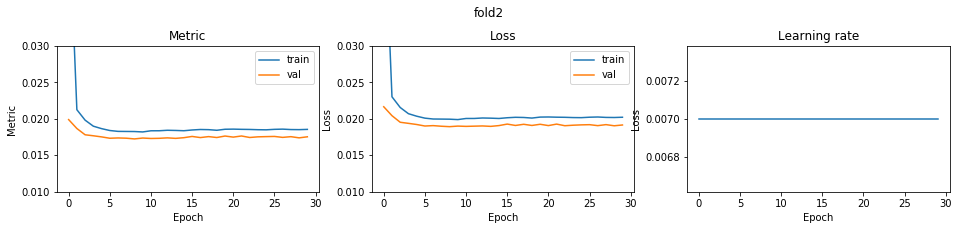

fold 3


epoch1 save best model... 0.019963383656801288
epoch2 save best model... 0.01881492989591762
epoch3 save best model... 0.018169038421591076
epoch4 save best model... 0.01790481867535986
epoch5 save best model... 0.017657145276954205
epoch6 save best model... 0.017519935358375108
epoch7 save best model... 0.017474216014435325
epoch9 save best model... 0.01738827371320651
fold3 score: 0.017388273917668895


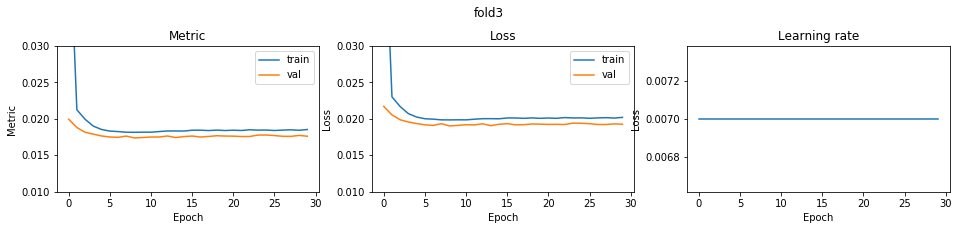

fold 4


epoch1 save best model... 0.019700191005351603
epoch2 save best model... 0.01841784434346376
epoch3 save best model... 0.01787903476251896
epoch4 save best model... 0.017672981216587075
epoch6 save best model... 0.01746841262567763
epoch7 save best model... 0.017411414654776962
epoch8 save best model... 0.01729011368642907
fold4 score: 0.017290113463045032


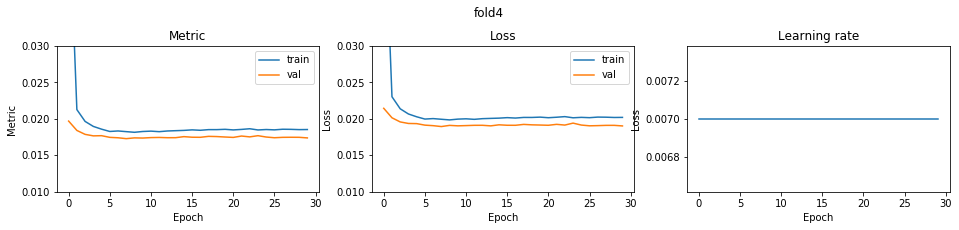

CV score: 0.017317726727525417

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.020098822535034734
epoch2 save best model... 0.01906267915235022
epoch3 save best model... 0.018298472417412424
epoch4 save best model... 0.017852891950204054
epoch5 save best model... 0.017474675282055263
epoch6 save best model... 0.017331921400879944
epoch7 save best model... 0.017189024645911533
epoch8 save best model... 0.017169399267584425
epoch9 save best model... 0.016826421497623034
epoch11 save best model... 0.01675478574779555
epoch13 save best model... 0.016602105884080866
epoch15 save best model... 0.01655929512291264
epoch17 save best model... 0.01646032310292498
epoch18 save best model... 0.01645249592008786
epoch20 save best model... 0.016447985287679354
epoch21 save best model... 0.01644778398028946
epoch25 save best model... 0.016416534467479364
epoch26 save best model... 0.01631829400625343
fold0 score: 0.016318293873096607


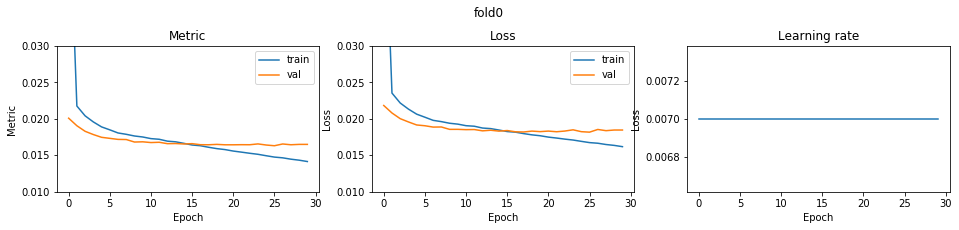

fold 1


epoch1 save best model... 0.02035630178101162
epoch2 save best model... 0.01915879520519933
epoch3 save best model... 0.018216207098087654
epoch4 save best model... 0.01796268739971621
epoch5 save best model... 0.01752756216229502
epoch7 save best model... 0.017250483645956754
epoch10 save best model... 0.01707559575467426
epoch11 save best model... 0.01697834038130445
epoch14 save best model... 0.01683361683440632
epoch18 save best model... 0.016784675718100748
epoch21 save best model... 0.016698265274425157
fold1 score: 0.016698265177978025


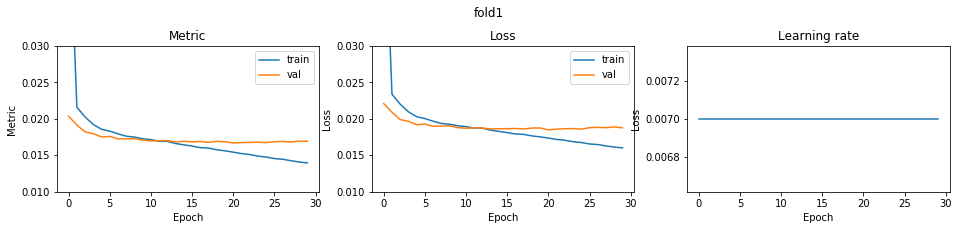

fold 2


epoch1 save best model... 0.019965526969340754
epoch2 save best model... 0.019244194679653135
epoch3 save best model... 0.018316119461131274
epoch4 save best model... 0.01774712877743172
epoch5 save best model... 0.01751974100273762
epoch6 save best model... 0.017349231469163347
epoch7 save best model... 0.01705693344100308
epoch8 save best model... 0.017019160872965705
epoch9 save best model... 0.017013489361237043
epoch10 save best model... 0.01697725833555538
epoch11 save best model... 0.016922949848742846
epoch12 save best model... 0.01677545782379801
epoch13 save best model... 0.01673463100342958
epoch14 save best model... 0.016588256621593685
epoch17 save best model... 0.016582829195316003
epoch18 save best model... 0.01652980385648244
epoch19 save best model... 0.016496837008842087
epoch20 save best model... 0.016377989227776783
fold2 score: 0.01637798912411424


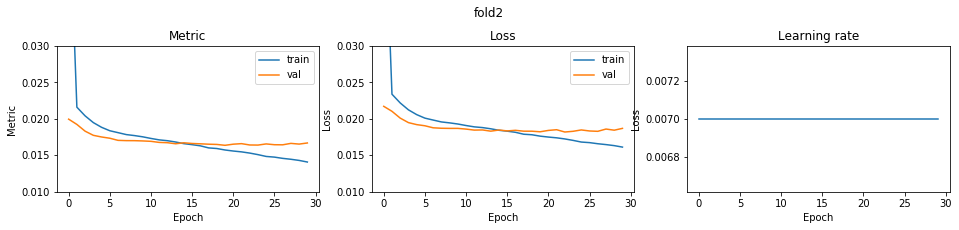

fold 3


epoch1 save best model... 0.020507351664194078
epoch2 save best model... 0.01935896948616366
epoch3 save best model... 0.0184550270336364
epoch4 save best model... 0.018093659668091625
epoch5 save best model... 0.01767264135937145
epoch6 save best model... 0.01749167354790184
epoch7 save best model... 0.01743452715345898
epoch8 save best model... 0.017286961944455573
epoch9 save best model... 0.017187267490545954
epoch11 save best model... 0.017015755288557474
epoch13 save best model... 0.016955483216868718
epoch14 save best model... 0.01683650737785329
epoch15 save best model... 0.01680053281162893
epoch17 save best model... 0.01675762627104081
epoch18 save best model... 0.01670864371090686
epoch19 save best model... 0.016624514942729936
epoch24 save best model... 0.016622321735346234
epoch26 save best model... 0.01659466803014482
fold3 score: 0.01659466790786377


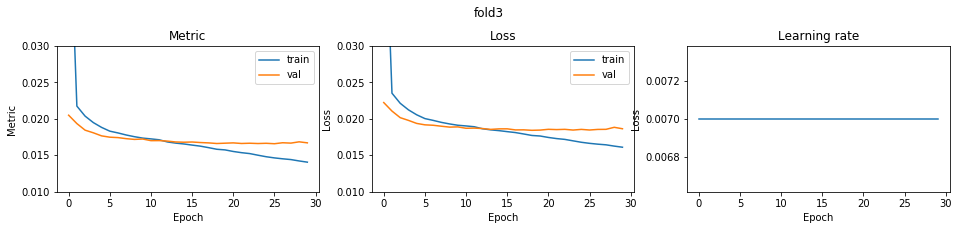

fold 4


epoch1 save best model... 0.019951751211272014
epoch2 save best model... 0.01890978100105
epoch3 save best model... 0.018133460687036394
epoch4 save best model... 0.01784263847900686
epoch5 save best model... 0.017476004518246054
epoch6 save best model... 0.01730082420746802
epoch7 save best model... 0.017211184316741172
epoch8 save best model... 0.017175992338966942
epoch9 save best model... 0.01704526049188913
epoch10 save best model... 0.017040455405407315
epoch11 save best model... 0.01700758416001984
epoch12 save best model... 0.01693345205964423
epoch13 save best model... 0.016756816393354215
epoch14 save best model... 0.016669420514824316
epoch16 save best model... 0.01665405922512055
epoch17 save best model... 0.016643653003443754
epoch19 save best model... 0.0165300647238087
fold4 score: 0.016530064744646338


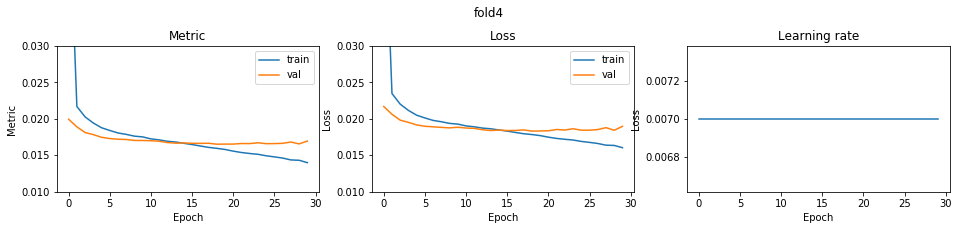

CV score: 0.0165038530426142

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.6955487393844101
epoch2 save best model... 0.6723561806939458
epoch3 save best model... 0.627148351310869
epoch4 save best model... 0.5249917419733382
epoch5 save best model... 0.373156583879423
epoch6 save best model... 0.23040808227447823
epoch7 save best model... 0.13930557001560315
epoch8 save best model... 0.08529788737688086
epoch9 save best model... 0.056607092642023786
epoch10 save best model... 0.041462371615451125
epoch11 save best model... 0.03245142240730668
epoch12 save best model... 0.02710410452920918
epoch13 save best model... 0.02470270464778082
epoch14 save best model... 0.02269543646612037
epoch15 save best model... 0.02178609217761046
epoch16 save best model... 0.0210683562565841
epoch17 save best model... 0.02066657435581733
epoch18 save best model... 0.020494375553550645
epoch19 save best model... 0.020228405301045447
epoch20 save best model... 0.02010572554802433
epoch21 save best model... 0.01990913042633164
epoch22 save best model...

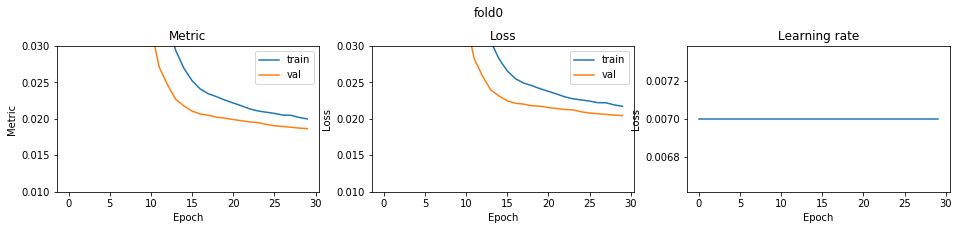

fold 1


epoch1 save best model... 0.6991307388598132
epoch2 save best model... 0.6763351124385192
epoch3 save best model... 0.6306566726132008
epoch4 save best model... 0.5312888057065135
epoch5 save best model... 0.3750018946984331
epoch6 save best model... 0.23772844429112805
epoch7 save best model... 0.14176929515134395
epoch8 save best model... 0.08678628084640021
epoch9 save best model... 0.058738237268514855
epoch10 save best model... 0.042426749690433495
epoch11 save best model... 0.03413475756052823
epoch12 save best model... 0.02823889923003356
epoch13 save best model... 0.025393522198751864
epoch14 save best model... 0.023381218987252452
epoch15 save best model... 0.022221486299965208
epoch16 save best model... 0.021486568926074125
epoch17 save best model... 0.021038894485754394
epoch18 save best model... 0.020820468383223517
epoch19 save best model... 0.020528581112242962
epoch20 save best model... 0.020414976725653136
epoch21 save best model... 0.02014706359179315
epoch22 save best

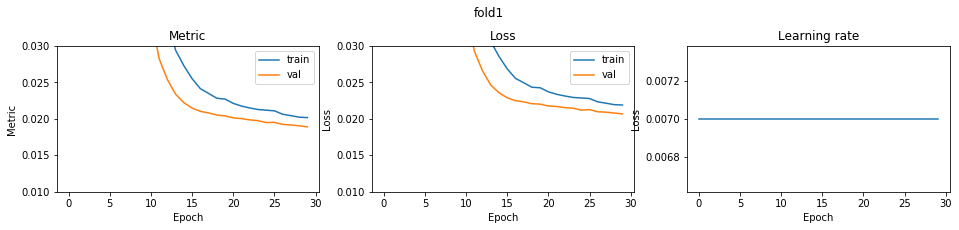

fold 2


epoch1 save best model... 0.700604899621113
epoch2 save best model... 0.679147630461421
epoch3 save best model... 0.6296712601475467
epoch4 save best model... 0.5261810591563627
epoch5 save best model... 0.3704545472498824
epoch6 save best model... 0.23011548613450825
epoch7 save best model... 0.13884481194894444
epoch8 save best model... 0.0847804556626425
epoch9 save best model... 0.056317519612982106
epoch10 save best model... 0.04064318207027864
epoch11 save best model... 0.03225910728451439
epoch12 save best model... 0.027290684102482095
epoch13 save best model... 0.024916133923784126
epoch14 save best model... 0.0228694239960197
epoch15 save best model... 0.02191412679793338
epoch16 save best model... 0.021303452829764355
epoch17 save best model... 0.02079007575849882
epoch18 save best model... 0.02055256409406336
epoch19 save best model... 0.020267361228851446
epoch21 save best model... 0.0200704335236969
epoch22 save best model... 0.01994043686417627
epoch23 save best model... 

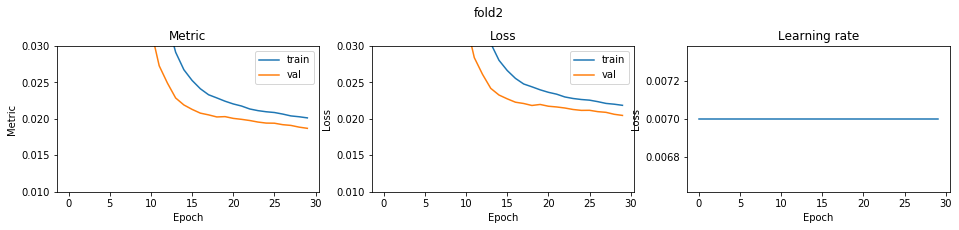

fold 3


epoch1 save best model... 0.6998261412346825
epoch2 save best model... 0.680454314623987
epoch3 save best model... 0.6353590424077115
epoch4 save best model... 0.5336199698524214
epoch5 save best model... 0.380446643384008
epoch6 save best model... 0.23533783377167306
epoch7 save best model... 0.1380678743259782
epoch8 save best model... 0.08643542073650078
epoch9 save best model... 0.05515436397055015
epoch10 save best model... 0.040845677371991795
epoch11 save best model... 0.03239027928382769
epoch12 save best model... 0.02738274119896199
epoch13 save best model... 0.024753245036701135
epoch14 save best model... 0.022948064314782756
epoch15 save best model... 0.021945422104557716
epoch16 save best model... 0.02123292242611731
epoch17 save best model... 0.020900626139872303
epoch18 save best model... 0.020628879843428222
epoch19 save best model... 0.02046666419587537
epoch20 save best model... 0.02034584339156509
epoch21 save best model... 0.020231472159861024
epoch22 save best model

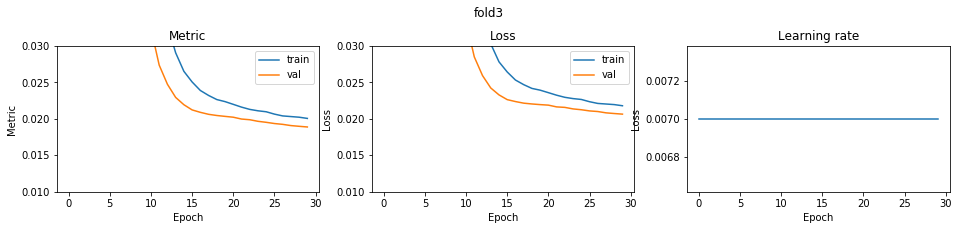

fold 4


epoch1 save best model... 0.7017798145431049
epoch2 save best model... 0.6779516582880042
epoch3 save best model... 0.6316736317169693
epoch4 save best model... 0.5282996982539705
epoch5 save best model... 0.3711177915402588
epoch6 save best model... 0.2358240344733475
epoch7 save best model... 0.13625629419346333
epoch8 save best model... 0.08464630320837938
epoch9 save best model... 0.05589258456963341
epoch10 save best model... 0.04086328068905105
epoch11 save best model... 0.03215932209036209
epoch12 save best model... 0.027547632317336652
epoch13 save best model... 0.024412165781597613
epoch14 save best model... 0.022680514117444022
epoch15 save best model... 0.021727089301294782
epoch16 save best model... 0.020977672144499075
epoch17 save best model... 0.020642755099981685
epoch18 save best model... 0.02036817982063071
epoch19 save best model... 0.020111916865092748
epoch20 save best model... 0.019908116605124333
epoch21 save best model... 0.019780106867975416
epoch22 save best m

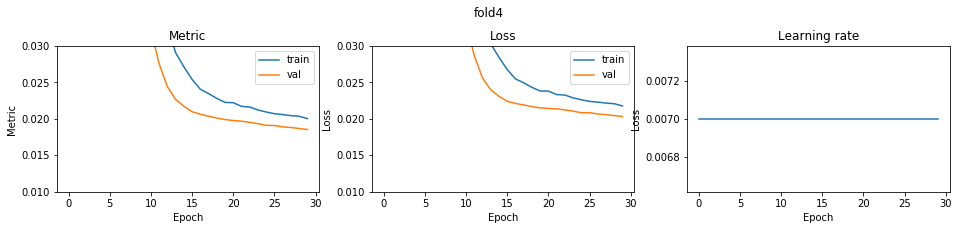

CV score: 0.018745865070328833

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.020372339797148944
epoch2 save best model... 0.019171241584291218
epoch3 save best model... 0.018144748769785387
epoch4 save best model... 0.01779600006012683
epoch5 save best model... 0.01756929238676889
epoch6 save best model... 0.01737765651747822
epoch7 save best model... 0.017277880054569733
epoch8 save best model... 0.016939186029017377
epoch10 save best model... 0.016838901338076265
epoch11 save best model... 0.016726543729305945
epoch14 save best model... 0.01653593855831509
epoch19 save best model... 0.016498971403765245
epoch20 save best model... 0.016461909676059774
epoch21 save best model... 0.016389314296118628
fold0 score: 0.016389314284002615


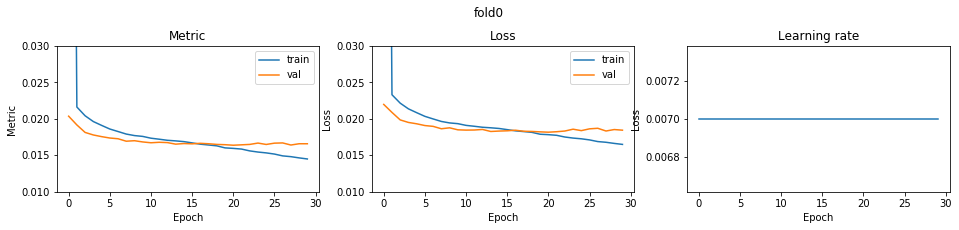

fold 1


epoch1 save best model... 0.020318561214694785
epoch2 save best model... 0.018801887269055663
epoch3 save best model... 0.018247432267052704
epoch4 save best model... 0.0179276275933366
epoch5 save best model... 0.017718514820951676
epoch6 save best model... 0.01753920765997242
epoch7 save best model... 0.01746050478102447
epoch8 save best model... 0.017243537207733094
epoch9 save best model... 0.017185150537666168
epoch10 save best model... 0.01698064921590578
epoch12 save best model... 0.016958324208526304
epoch13 save best model... 0.016912426565909376
epoch15 save best model... 0.016852295382882434
epoch18 save best model... 0.016755296467612656
epoch23 save best model... 0.016680388235015758
fold1 score: 0.016680388143806294


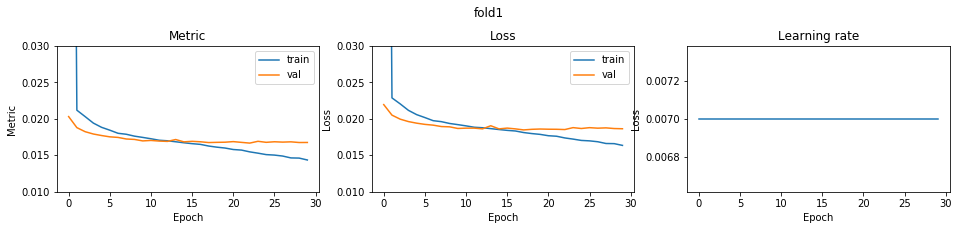

fold 2


epoch1 save best model... 0.020458434577067936
epoch2 save best model... 0.018935229912345922
epoch3 save best model... 0.018286081457051826
epoch4 save best model... 0.017854054867338553
epoch5 save best model... 0.01781759796442163
epoch6 save best model... 0.017370321600101456
epoch7 save best model... 0.017186118335662356
epoch8 save best model... 0.01714511828802188
epoch10 save best model... 0.01695106159106294
epoch12 save best model... 0.01671300601005371
epoch15 save best model... 0.016688010352966073
epoch16 save best model... 0.016666127195020326
epoch17 save best model... 0.016665288875900984
epoch19 save best model... 0.0165473791579874
epoch24 save best model... 0.01648722418899463
fold2 score: 0.016487224116762837


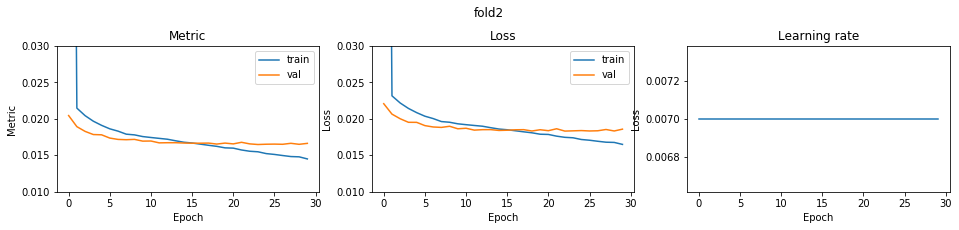

fold 3


epoch1 save best model... 0.020409328424306015
epoch2 save best model... 0.019161263902105204
epoch3 save best model... 0.01839409022632316
epoch4 save best model... 0.017993220201097344
epoch5 save best model... 0.017941312843632453
epoch6 save best model... 0.017595667624952176
epoch7 save best model... 0.017372567459075353
epoch9 save best model... 0.017280021073945835
epoch10 save best model... 0.017219553128784367
epoch12 save best model... 0.01700132917782508
epoch14 save best model... 0.016993534147467862
epoch15 save best model... 0.01685101823384846
epoch17 save best model... 0.016816631043520765
epoch18 save best model... 0.01675053050567593
epoch22 save best model... 0.016683621583654967
epoch24 save best model... 0.01663248834490844
epoch26 save best model... 0.01663055903785321
fold3 score: 0.016630558905140595


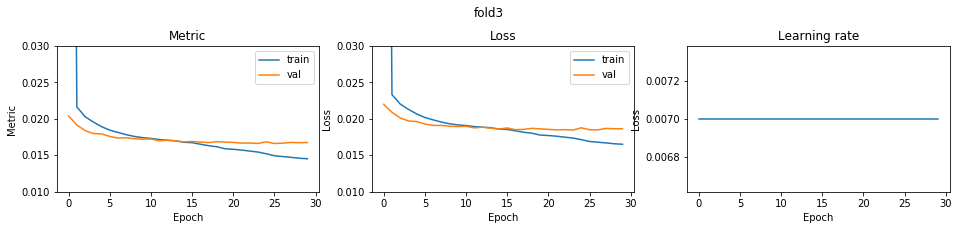

fold 4


epoch1 save best model... 0.02026078591551759
epoch2 save best model... 0.018876391572024937
epoch3 save best model... 0.01820678507022407
epoch4 save best model... 0.017843000373563355
epoch5 save best model... 0.017760156671641762
epoch6 save best model... 0.017439207500843903
epoch7 save best model... 0.017248466584178064
epoch8 save best model... 0.017161373615875875
epoch9 save best model... 0.017117436900989477
epoch11 save best model... 0.016944476365958232
epoch12 save best model... 0.01689477979347687
epoch13 save best model... 0.016855714033975146
epoch14 save best model... 0.01680862797564214
epoch16 save best model... 0.016808413593671315
epoch17 save best model... 0.01679959200738435
epoch18 save best model... 0.01672223019742477
epoch20 save best model... 0.016499295886733267
fold4 score: 0.016499295845898928


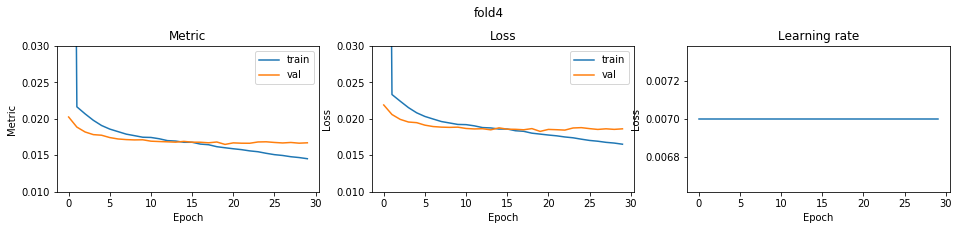

CV score: 0.016537352026402084

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02113725698567876
epoch2 save best model... 0.019594365700332614
epoch3 save best model... 0.018558293997664385
epoch4 save best model... 0.01802617486455989
epoch5 save best model... 0.017611205408133244
epoch6 save best model... 0.017323742976628566
epoch7 save best model... 0.01712481629417399
epoch8 save best model... 0.017016240710855075
epoch9 save best model... 0.016921304158679717
epoch10 save best model... 0.01676215139347084
epoch11 save best model... 0.016608736453607578
epoch12 save best model... 0.01658267770853564
epoch13 save best model... 0.01651448987695921
epoch14 save best model... 0.016458290637999026
epoch15 save best model... 0.016403242186187068
epoch16 save best model... 0.016399000473914495
epoch17 save best model... 0.016340470792628094
epoch20 save best model... 0.016311459642981342
epoch21 save best model... 0.016296490201628967
epoch23 save best model... 0.016286000728199856
fold0 score: 0.016286000725704367


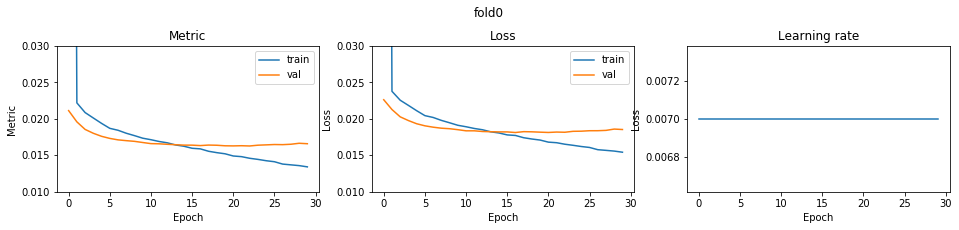

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021533217986013955
epoch2 save best model... 0.01969469573555014
epoch3 save best model... 0.01854066714461096
epoch4 save best model... 0.018207523754508653
epoch5 save best model... 0.018018339150541733
epoch6 save best model... 0.01763514053067169
epoch7 save best model... 0.017462295786269462
epoch8 save best model... 0.017298185518853863
epoch10 save best model... 0.017047435988872178
epoch12 save best model... 0.016895232798553296
epoch13 save best model... 0.016831001917001705
epoch14 save best model... 0.016765016893094235
epoch15 save best model... 0.016680523841651394
epoch18 save best model... 0.016643968829874515
epoch20 save best model... 0.016623717809117623
fold1 score: 0.016623717763368007


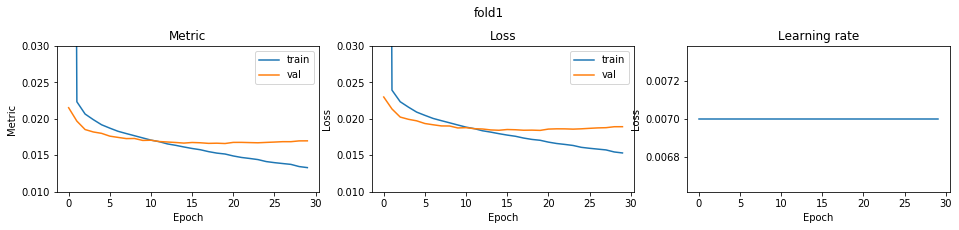

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021457941065748016
epoch2 save best model... 0.019484614519460527
epoch3 save best model... 0.018533010501308442
epoch4 save best model... 0.01800400807080236
epoch5 save best model... 0.01765069725426068
epoch6 save best model... 0.017539533024272268
epoch7 save best model... 0.017313182204588315
epoch8 save best model... 0.017070822298482627
epoch9 save best model... 0.01693550539159488
epoch10 save best model... 0.01675871206991974
epoch11 save best model... 0.016692876792242285
epoch12 save best model... 0.016628645081221582
epoch13 save best model... 0.016555622766652935
epoch15 save best model... 0.016466430062247753
epoch16 save best model... 0.01646421670996028
epoch19 save best model... 0.016404735590939194
epoch21 save best model... 0.016395851801236334
fold2 score: 0.016395851709662325


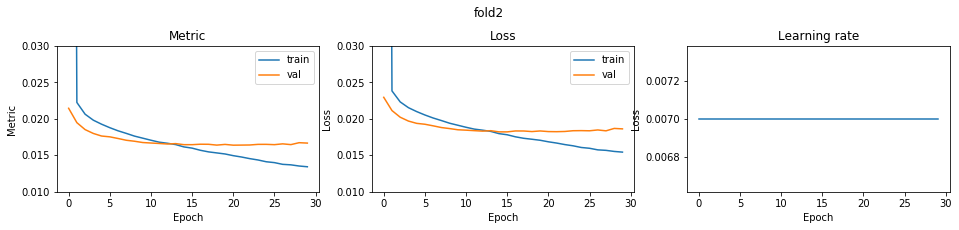

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02139117137140728
epoch2 save best model... 0.019719369002195723
epoch3 save best model... 0.018714390107873905
epoch4 save best model... 0.018110209171806627
epoch5 save best model... 0.017960962028601174
epoch6 save best model... 0.017605082164592785
epoch7 save best model... 0.017353826347560303
epoch8 save best model... 0.01729259277462688
epoch9 save best model... 0.017070754215647393
epoch10 save best model... 0.01704128982842919
epoch11 save best model... 0.01693173865564931
epoch12 save best model... 0.016825120177773382
epoch13 save best model... 0.016669293052192294
epoch14 save best model... 0.01665330031941855
epoch16 save best model... 0.016570920877769624
fold3 score: 0.0165709209079748


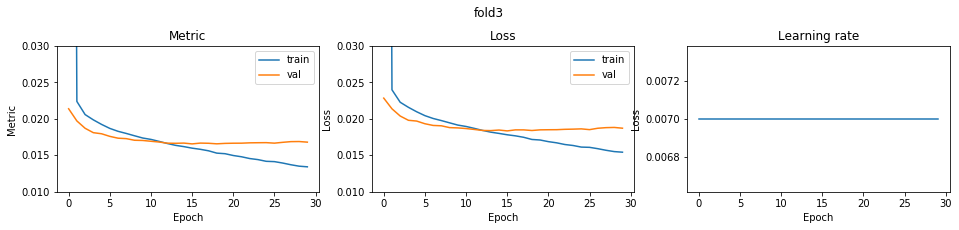

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020912832802411907
epoch2 save best model... 0.01926404147881989
epoch3 save best model... 0.01846679850716933
epoch4 save best model... 0.017943132910580462
epoch5 save best model... 0.017637524567968754
epoch6 save best model... 0.017394877263771237
epoch7 save best model... 0.01728862532730594
epoch8 save best model... 0.01713154337841992
epoch9 save best model... 0.016955779480550583
epoch10 save best model... 0.01684588547796011
epoch11 save best model... 0.016746640021664542
epoch12 save best model... 0.016634398233781916
epoch14 save best model... 0.016557237372260565
epoch15 save best model... 0.016541501546622272
epoch17 save best model... 0.016531875631124935
fold4 score: 0.016531875520815646


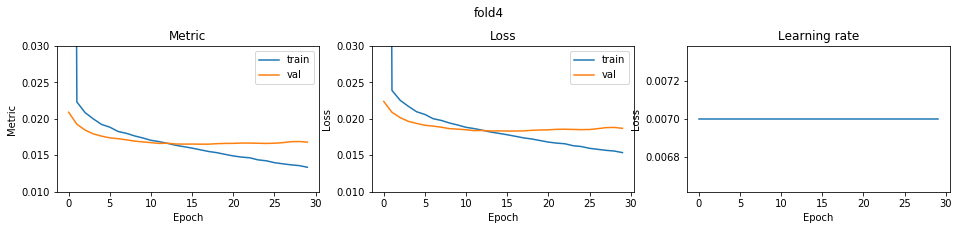

CV score: 0.01648167076386743
                     metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Ranger_CG          0.016482
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdamW_CG           0.016504
AdaMod             0.016508
RAdam_CG           0.016537
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam_CG            0.017318
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
PlainRAdam_CG      0.018746
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770


metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Ranger_CG          0.016482
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdamW_CG           0.016504
AdaMod             0.016508
RAdam_CG           0.016537
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam_CG            0.017318
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
PlainRAdam_CG      0.018746
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770

In [36]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
]

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score
    
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

In [37]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Ranger_CG          0.016482
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdamW_CG           0.016504
AdaMod             0.016508
RAdam_CG           0.016537
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam_CG            0.017318
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
PlainRAdam_CG      0.018746
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770


metric
Yogi               0.016363
NovoGrad           0.016383
RangerLars         0.016401
SWATS              0.016406
LookaheadYogi      0.016432
Ranger             0.016445
AdamP              0.016461
RAdam              0.016469
PlainRAdam         0.016474
Ranger_CG          0.016482
Lamb               0.016493
AdamW              0.016494
LookaheadDiffGrad  0.016494
AdaBelief          0.016494
AdamW_CG           0.016504
AdaMod             0.016508
RAdam_CG           0.016537
RangerQH           0.016591
LookaheadAdam      0.016636
DiffGrad           0.016656
QHAdam             0.017286
Adam_CG            0.017318
Adam               0.017329
RangerVA           0.017985
AggMo              0.018018
PlainRAdam_CG      0.018746
AdaBound           0.020100
PID                0.136081
SGD                0.136118
SGDP               0.136558
Apollo             0.136892
QHM                0.139333
SGDW               0.141770

In [38]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')